In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis

from src.utils import path_project

In [2]:
def import_data(subfolder="raw_data"):
    path_X_train = path_project + 'data/' + subfolder + '/X_train.csv'
    path_X_test = path_project + 'data/' + subfolder + '/X_test.csv'
    path_y_train = path_project + 'data/' + subfolder + '/y_train.csv'

    X_train = pd.read_csv(path_X_train, sep=',', index_col=0)
    X_test = pd.read_csv(path_X_test, sep=',', index_col=0)
    y_train = pd.read_csv(path_y_train, sep=',', index_col=0)

    return X_train, y_train, X_test

In [3]:
X_train, y_train, X_test = import_data()

In [4]:
def preprocess_data(X_train, X_test, preprocessor):
    X_train, X_test = preprocessor(X_train, X_test)
    return X_train, X_test

def preprocessor_minmax(X_train, X_test):
    X_train = X_train.apply(lambda x: (x - min(x))/(max(x)-min(x)), axis=1)
    X_test = X_test.apply(lambda x: (x - min(x))/(max(x)-min(x)), axis=1)
    return X_train, X_test

preprocess_data(X_train[0:5], X_test[0:5], preprocessor_minmax)

(          x0        x1        x2        x3        x4        x5        x6  \
 id                                                                         
 0   0.000000  0.001040  0.002080  0.003121  0.004161  0.004854  0.005895   
 1   0.322202  0.326715  0.334838  0.349278  0.374549  0.392599  0.405235   
 2   0.273848  0.270584  0.266231  0.253174  0.236126  0.220530  0.204933   
 3   0.495202  0.497121  0.499424  0.501344  0.503647  0.505182  0.507486   
 4   0.383160  0.382522  0.382203  0.381990  0.381778  0.381565  0.381246   
 
           x7        x8        x9  ...  x17969  x17970  x17971  x17972  x17973  \
 id                                ...                                           
 0   0.006935  0.008669  0.011096  ...     NaN     NaN     NaN     NaN     NaN   
 1   0.403430  0.382671  0.349278  ...     NaN     NaN     NaN     NaN     NaN   
 2   0.186797  0.164309  0.134204  ...     NaN     NaN     NaN     NaN     NaN   
 3   0.509789  0.511324  0.512092  ...     NaN   

# Visualize class imbalance and length of observations/signals

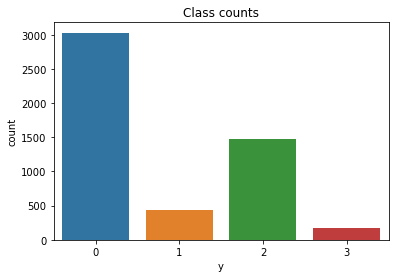

In [8]:
# Visualize class imbalance
sns.countplot(y_train["y"])
plt.title("Class counts")
plt.show()

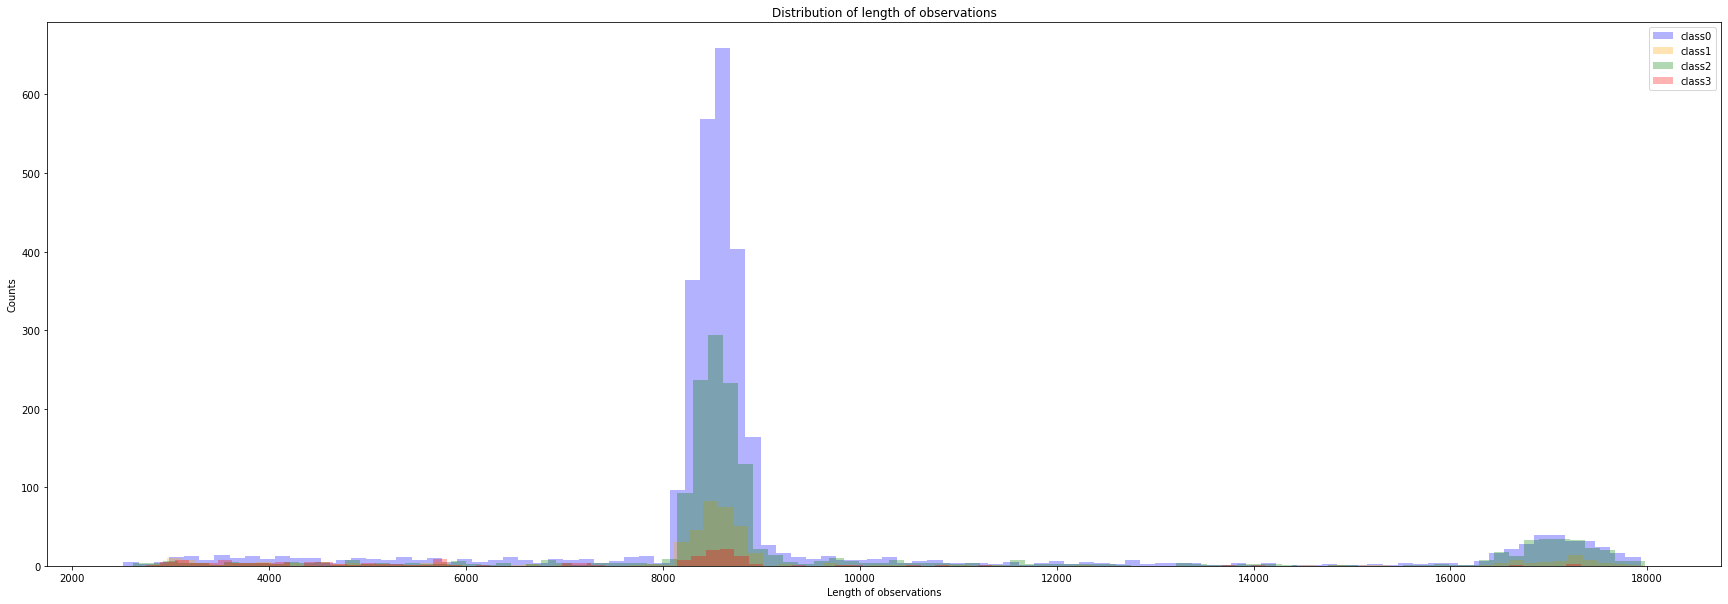

In [44]:
# Visualize distribution of observation length
obs_len = pd.DataFrame(X_train.notna().sum(axis=1), columns=["length"])
obs_len = pd.concat([obs_len, y_train], axis= 1)

obs_len_class0 = obs_len.loc[y_train.values==0, "length"]
obs_len_class1 = obs_len.loc[y_train.values==1, "length"]
obs_len_class2 = obs_len.loc[y_train.values==2, "length"]
obs_len_class3 = obs_len.loc[y_train.values==3, "length"]

plt.figure(figsize=(30,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(obs_len_class0, **kwargs, color="b", label="class0")
plt.hist(obs_len_class1, **kwargs, color="orange", label="class1")
plt.hist(obs_len_class2, **kwargs, color="g", label="class2")
plt.hist(obs_len_class3, **kwargs, color="r", label="class3")
plt.title("Distribution of length of observations")
plt.xlabel("Length of observations")
plt.ylabel("Counts")
plt.legend()
plt.show()

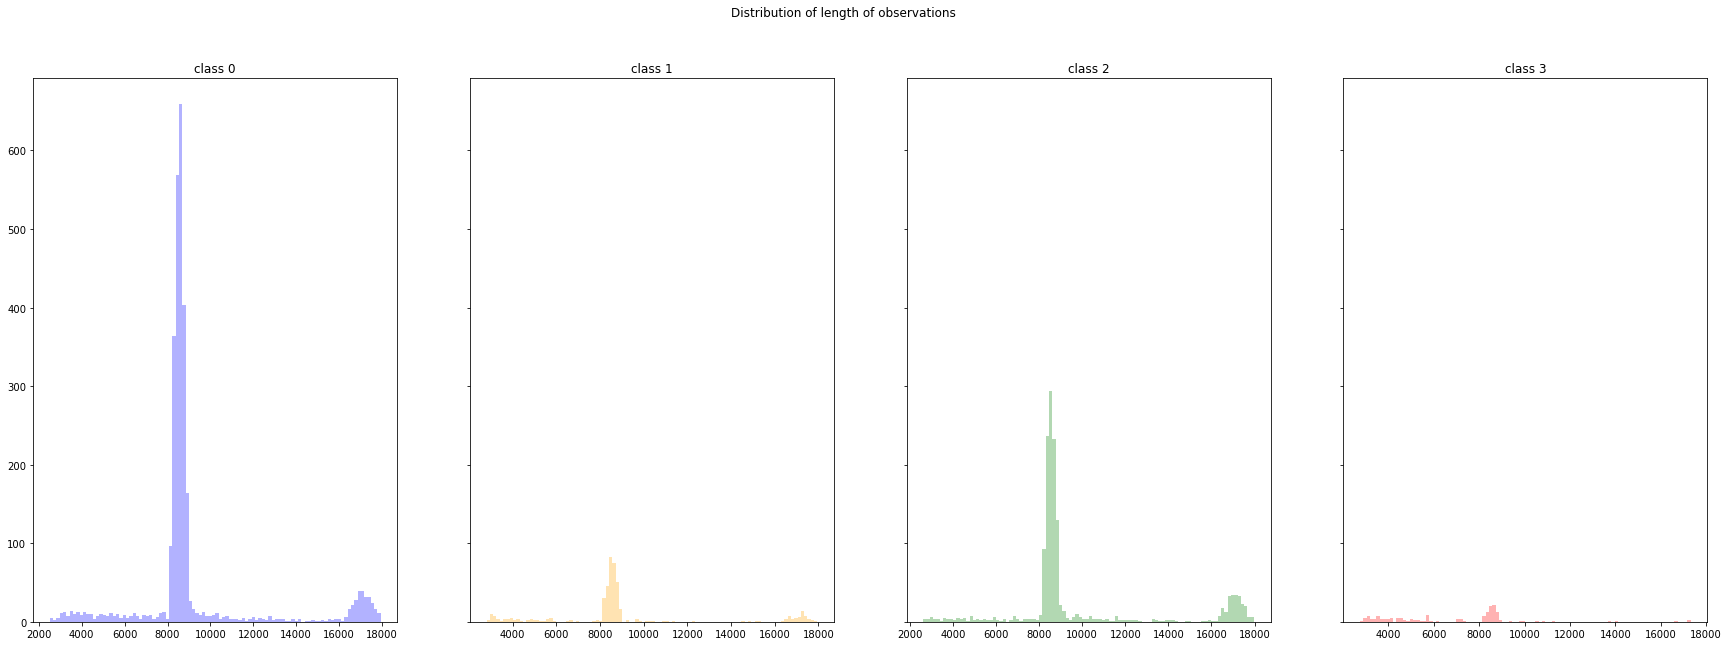

In [61]:
fig, axes = plt.subplots(1, 4, figsize=(30, 10), sharey=True)
colors = {0:'blue', 1:'orange', 2:'green', 3:'red'}
kwargs = dict(alpha=0.3, bins=100)

for (ax, group) in zip(axes.flatten(), np.unique(y_train["y"])):
    x = obs_len.loc[y_train.values==group, "length"]
    ax.hist(x, **kwargs, color=colors[group])
    ax.set_title(f"class {group}")
    
plt.suptitle("Distribution of length of observations")
plt.show()

# Visualize feature for one datapoint/signal

In [4]:
from biosppy.signals import ecg

class Heartbeat:
    def __init__(self, out):
        self.ts = out['ts']
        self.filtered = out['filtered']
        self.rpeaks = out['rpeaks']
        self.templates_ts = out['templates_ts']
        self.templates = out['templates']
        self.heart_rate_ts = out['heart_rate_ts']
        self.heart_rate = out['heart_rate']

In [5]:
def process_ecg(signal, scaler="minmax", plot=True):
    
    signal = signal[signal.notna()]
    if scaler=="standard":
        signal = (signal - signal.mean())/signal.std()
    elif scaler=="minmax":
        signal = (signal - np.min(signal))/(np.max(signal) - np.min(signal))

    #ts, signal_filtered, rpeaks, templates_ts, templates, heart_rate_ts, heart_rate = ecg.ecg(signal=signal, sampling_rate=300.0, show=True)
    ecg_out = Heartbeat(ecg.ecg(signal=signal, sampling_rate=300.0, show=True))
    
    if plot:
        plot_templates(ecg_out)
        
    return ecg_out

def plot_templates(ecg_out):
    templates = ecg_out.templates
    templates_ts = ecg_out.templates_ts
    fig, axes = plt.subplots(2)
    for i in range(len(templates)):
        axes[0].plot(templates_ts, templates[i], color="purple")
    axes[1].plot(templates_ts, templates.mean(axis=0))
    axes[1].plot(templates_ts, np.median(templates, axis=0), color="orange")
    axes[1].fill_between(templates_ts, templates.mean(axis=0)-templates.std(axis=0), templates.mean(axis=0)+templates.std(axis=0), alpha=0.5)
    plt.show()

    print(f"Average standard deviation: {np.mean(templates.std(axis=0))} ({np.std(templates.std(axis=0))})")
    
def extract_template_std(ecg_out, scale="minmax"): 
            
    templates = ecg_out.templates
    
    template_mean = templates.mean(axis=0)
    template_std = templates.std(axis=0)
    
    if scale=="minmax":
        template_std = template_std/(max(template_mean) - min(template_mean))
    elif scale=="mean":
        template_std = template_std/template_mean.mean()
    
    plt.plot(ecg_out.templates_ts, template_std)
    plt.title(f"Template Std. Dev. (Scaled={scale})")
    plt.ylim(0, 1)
    plt.show()
    
    return template_std

def extract_template_mean_median_diff(ecg_out, absolute=False, scale="minmax"):
    
    templates = ecg_out.templates
    template_mean = templates.mean(axis=0)
    template_median = np.median(templates, axis=0)
    
    template_mean_median_diff = template_mean - template_median
    if scale=="minmax":
        template_mean_median_diff = template_mean_median_diff/(max(template_mean) - min(template_mean))
    if absolute:
        template_mean_median_diff = [abs(val) for val in template_mean_median_diff]
    
    plt.plot(ecg_out.templates_ts, template_mean_median_diff)
    plt.title(f"Template mean-median difference (scaled={scale}) (absolute={absolute})")
    plt.ylim(-0.15, 0.15)
    plt.show()
    
    return template_mean_median_diff

In [6]:
X_train_class0 = X_train.loc[y_train.values==0, :]
X_train_class1 = X_train.loc[y_train.values==1, :]
X_train_class2 = X_train.loc[y_train.values==2, :]
X_train_class3 = X_train.loc[y_train.values==3, :]

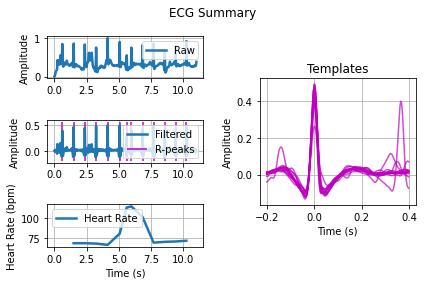

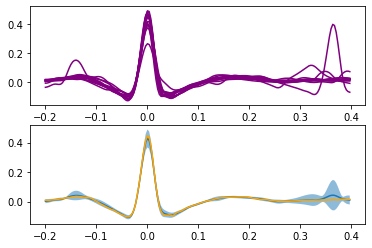

Average standard deviation: 0.020384078191239757 (0.01741699614597025)


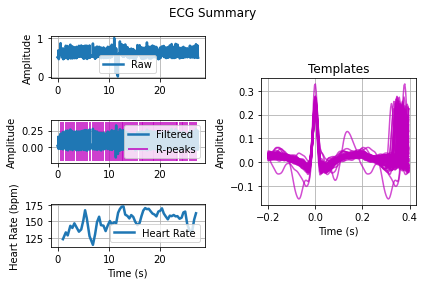

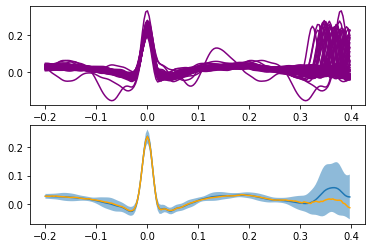

Average standard deviation: 0.021878372163214175 (0.022024071718409765)


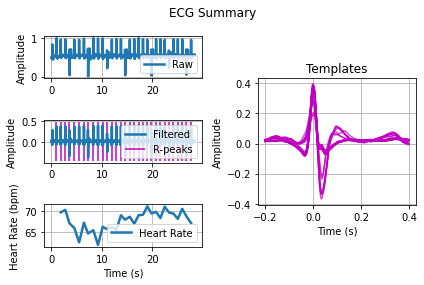

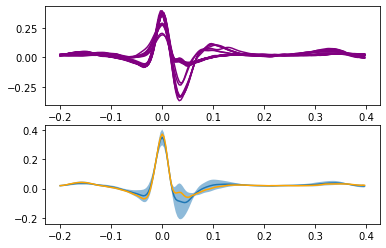

Average standard deviation: 0.01868814608267096 (0.02182261395537663)


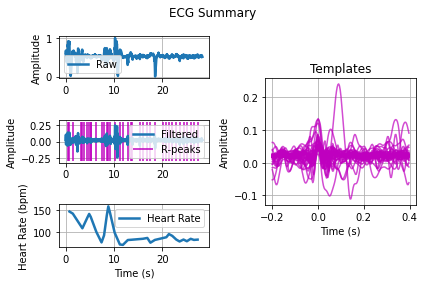

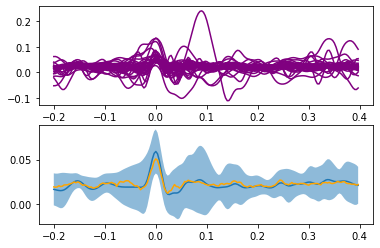

Average standard deviation: 0.01926143041029394 (0.0070722555555332925)


In [7]:
ecg_out_class0 = process_ecg(X_train_class0.iloc[0, :])
ecg_out_class1 = process_ecg(X_train_class1.iloc[0, :])
ecg_out_class2 = process_ecg(X_train_class2.iloc[0, :])
ecg_out_class3 = process_ecg(X_train_class3.iloc[0, :])

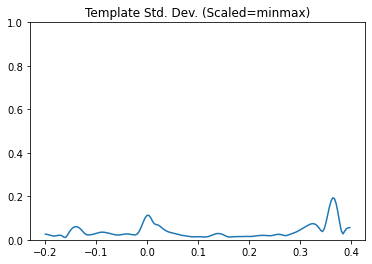

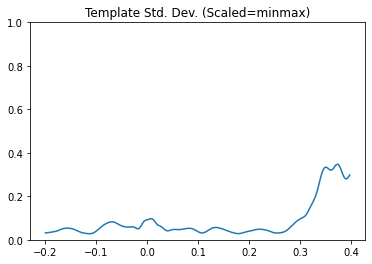

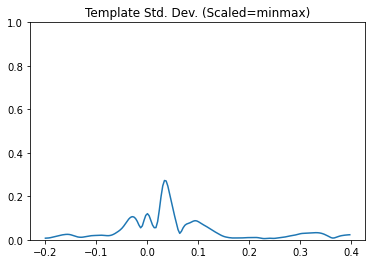

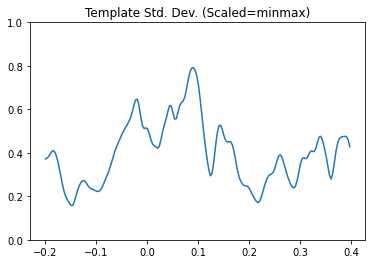

In [12]:
template_std_scaled = extract_template_std(ecg_out_class0, scale="minmax")
template_std_scaled = extract_template_std(ecg_out_class1, scale="minmax")
template_std_scaled = extract_template_std(ecg_out_class2, scale="minmax")
template_std_scaled = extract_template_std(ecg_out_class3, scale="minmax")

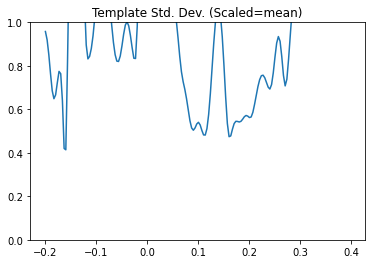

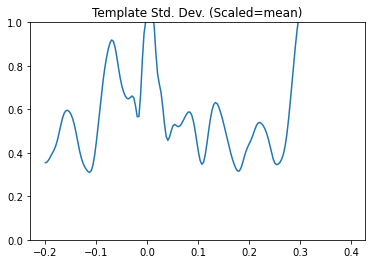

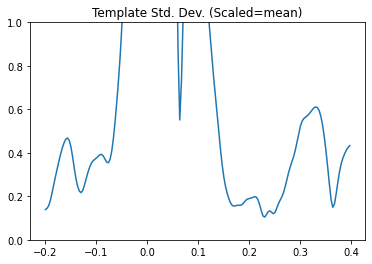

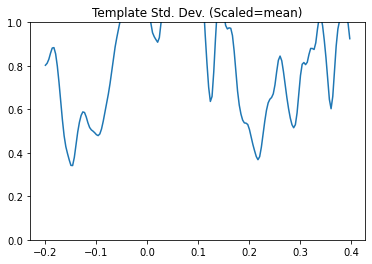

In [13]:
template_std_scaled = extract_template_std(ecg_out_class0, scale="mean")
template_std_scaled = extract_template_std(ecg_out_class1, scale="mean")
template_std_scaled = extract_template_std(ecg_out_class2, scale="mean")
template_std_scaled = extract_template_std(ecg_out_class3, scale="mean")

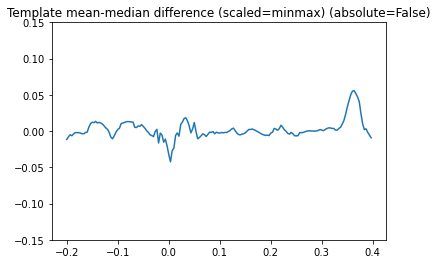

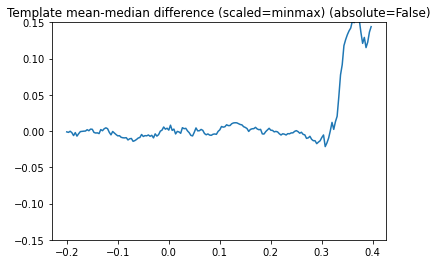

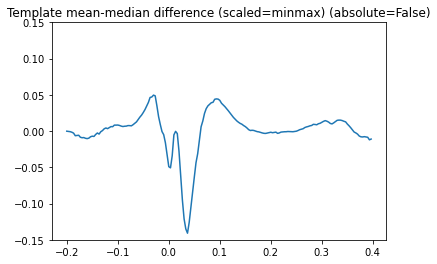

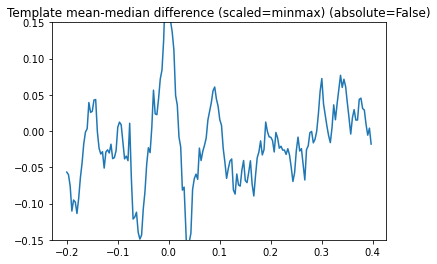

In [14]:
template_mean_median_diff_scaled = extract_template_mean_median_diff(ecg_out_class0, scale="minmax")
template_mean_median_diff_scaled = extract_template_mean_median_diff(ecg_out_class1, scale="minmax")
template_mean_median_diff_scaled = extract_template_mean_median_diff(ecg_out_class2, scale="minmax")
template_mean_median_diff_scaled = extract_template_mean_median_diff(ecg_out_class3, scale="minmax")

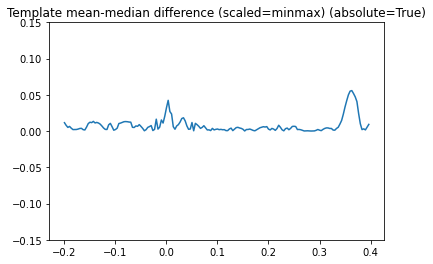

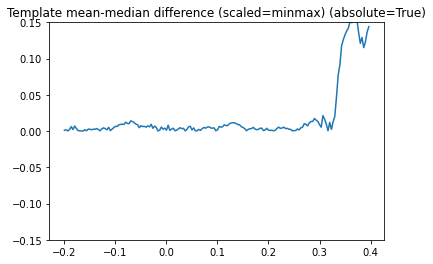

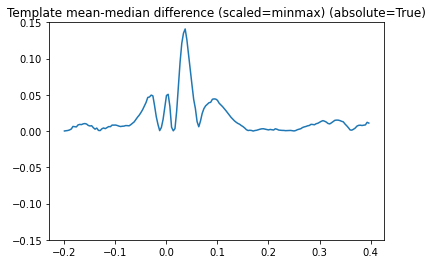

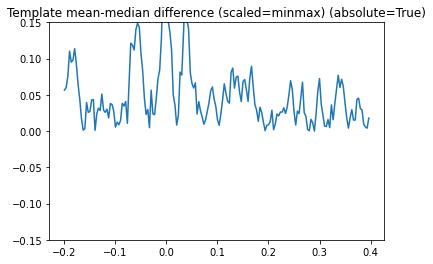

In [16]:
template_mean_median_diff_abs_scaled = extract_template_mean_median_diff(ecg_out_class0, absolute=True, scale="minmax")
template_mean_median_diff_abs_scaled = extract_template_mean_median_diff(ecg_out_class1, absolute=True, scale="minmax")
template_mean_median_diff_abs_scaled = extract_template_mean_median_diff(ecg_out_class2, absolute=True, scale="minmax")
template_mean_median_diff_abs_scaled = extract_template_mean_median_diff(ecg_out_class3, absolute=True, scale="minmax")

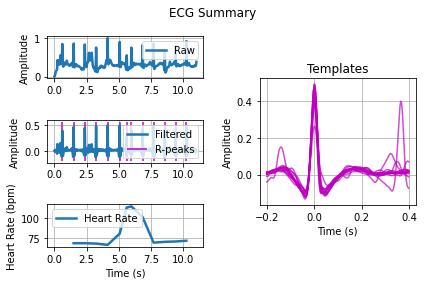

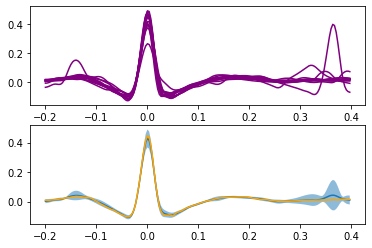

Average standard deviation: 0.020384078191239757 (0.01741699614597025)


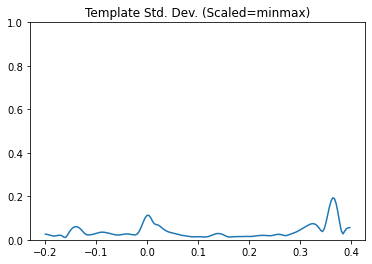

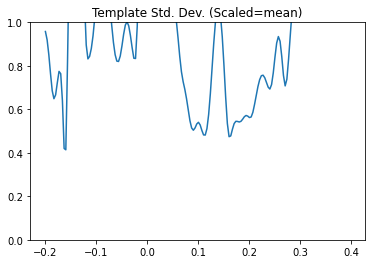

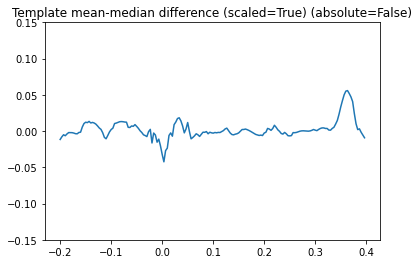

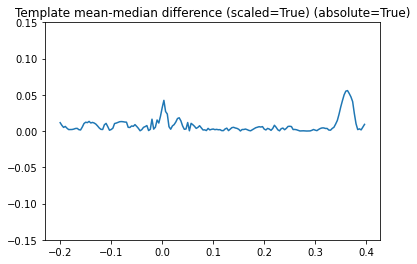

In [199]:
signal = X_train_class0.iloc[0, :]

ecg_out = process_ecg(signal)

#template_std = extract_template_std(ecg_out.templates)
#template_mean_median_diff = extract_template_mean_median_diff(ecg_out.templates)
#template_mean_median_diff_abs = extract_template_mean_median_diff(ecg_out.templates, absolute=True)

template_std_scaled = extract_template_std(ecg_out.templates, scale="minmax")
template_std_scaled = extract_template_std(ecg_out.templates, scale="mean")
template_mean_median_diff_scaled = extract_template_mean_median_diff(ecg_out.templates, scale=True)
template_mean_median_diff_abs_scaled = extract_template_mean_median_diff(ecg_out.templates, absolute=True, scale=True)

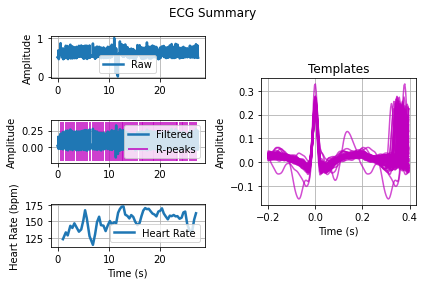

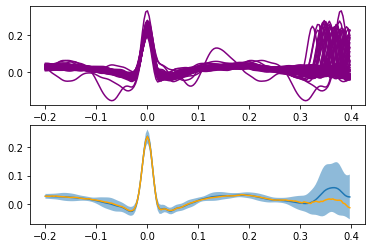

Average standard deviation: 0.021878372163214175 (0.022024071718409765)


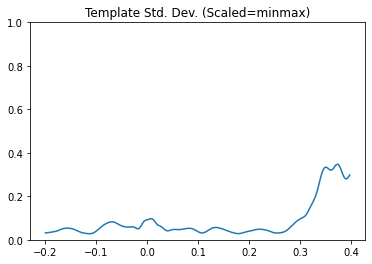

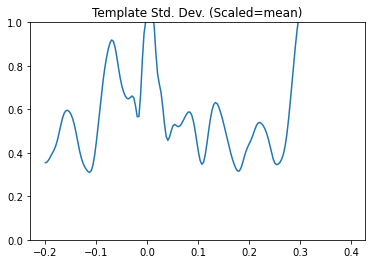

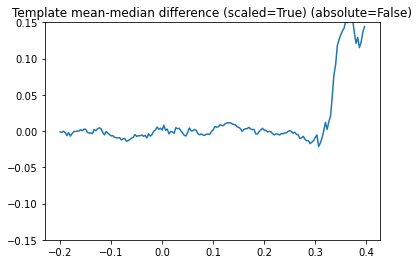

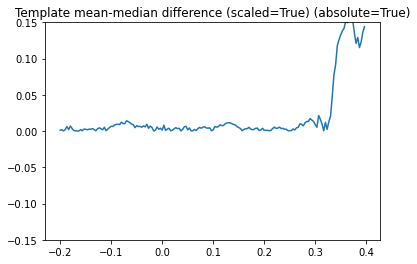

In [200]:
signal = X_train_class1.iloc[0, :]

ecg_out = process_ecg(signal)

#template_std = extract_template_std(ecg_out.templates)
#template_mean_median_diff = extract_template_mean_median_diff(ecg_out.templates)
#template_mean_median_diff_abs = extract_template_mean_median_diff(ecg_out.templates, absolute=True)

template_std_scaled = extract_template_std(ecg_out.templates, scale="minmax")
template_std_scaled = extract_template_std(ecg_out.templates, scale="mean")
template_mean_median_diff_scaled = extract_template_mean_median_diff(ecg_out.templates, scale=True)
template_mean_median_diff_abs_scaled = extract_template_mean_median_diff(ecg_out.templates, absolute=True, scale=True)

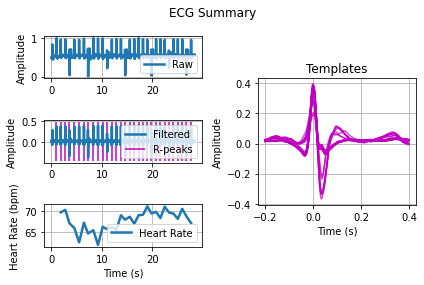

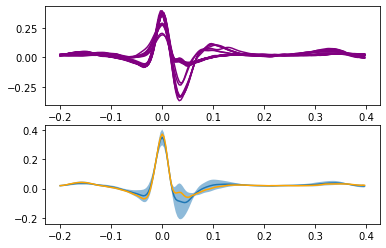

Average standard deviation: 0.01868814608267096 (0.02182261395537663)


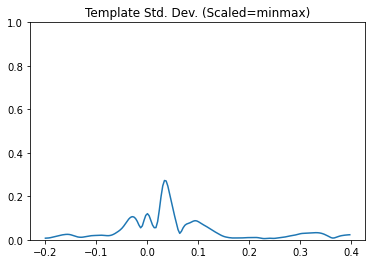

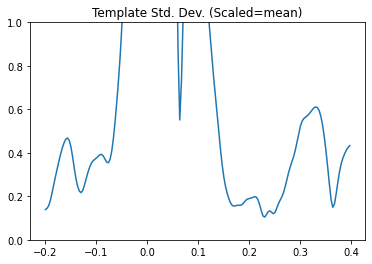

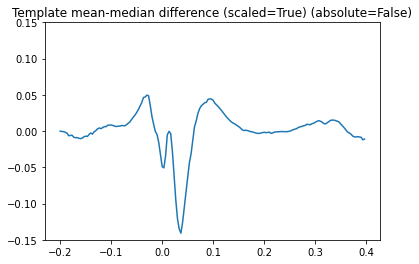

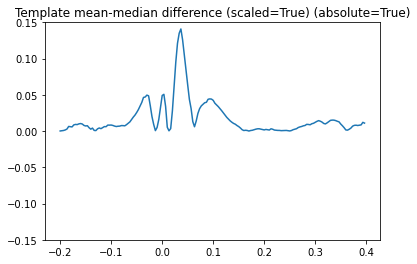

In [201]:
signal = X_train_class2.iloc[0, :]

ecg_out = process_ecg(signal)

#template_std = extract_template_std(ecg_out.templates)
#template_mean_median_diff = extract_template_mean_median_diff(ecg_out.templates)
#template_mean_median_diff_abs = extract_template_mean_median_diff(ecg_out.templates, absolute=True)

template_std_scaled = extract_template_std(ecg_out.templates, scale="minmax")
template_std_scaled = extract_template_std(ecg_out.templates, scale="mean")
template_mean_median_diff_scaled = extract_template_mean_median_diff(ecg_out.templates, scale=True)
template_mean_median_diff_abs_scaled = extract_template_mean_median_diff(ecg_out.templates, absolute=True, scale=True)

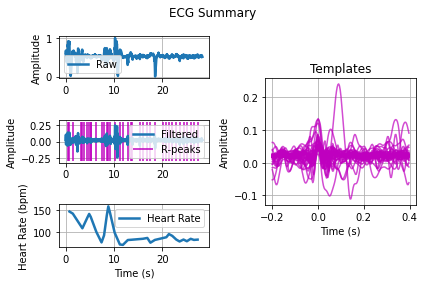

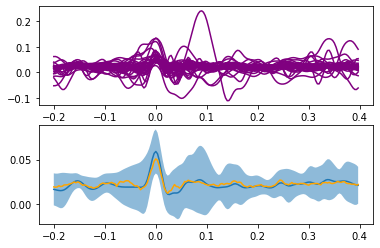

Average standard deviation: 0.01926143041029394 (0.0070722555555332925)


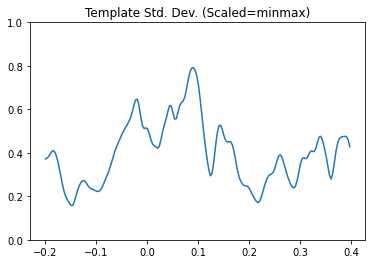

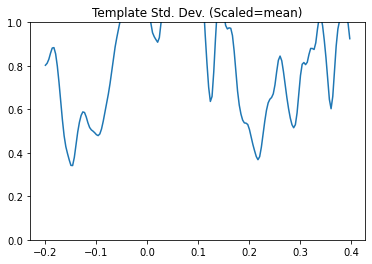

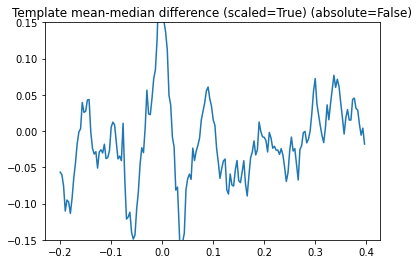

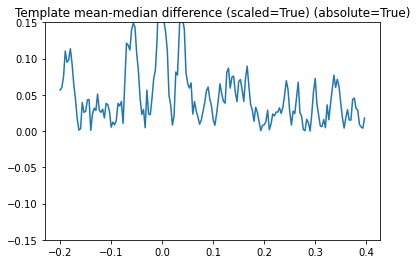

In [202]:
signal = X_train_class3.iloc[0, :]

ecg_out = process_ecg(signal)

#template_std = extract_template_std(ecg_out.templates)
#template_mean_median_diff = extract_template_mean_median_diff(ecg_out.templates)
#template_mean_median_diff_abs = extract_template_mean_median_diff(ecg_out.templates, absolute=True)

template_std_scaled = extract_template_std(ecg_out.templates, scale="minmax")
template_std_scaled = extract_template_std(ecg_out.templates, scale="mean")
template_mean_median_diff_scaled = extract_template_mean_median_diff(ecg_out.templates, scale=True)
template_mean_median_diff_abs_scaled = extract_template_mean_median_diff(ecg_out.templates, absolute=True, scale=True)

# Visualize feature over whole dataframe

In [10]:
def process_df_ecg(df_signal, scaler="minmax"):
    
    df_ecg = []
    for index, row in df_signal.iterrows():
        signal = row[row.notna()]
        if scaler=="minmax":
            signal = (signal - np.min(signal))/(np.max(signal) - np.min(signal))
        
        df_ecg.append(Heartbeat(ecg.ecg(signal, sampling_rate=300., show=False)))
        
    return df_ecg

In [175]:
def get_templates_mean(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        templates_mean = templates.mean(axis=0)

        result = pd.Series(templates_mean)
        results = results.append(result, ignore_index=True)

    return results

def get_templates_median(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        templates_median = np.median(templates,axis=0)

        result = pd.Series(templates_median)
        results = results.append(result, ignore_index=True)

    return results

def get_templates_std(df_ecg, scale=None):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        template_mean = templates.mean(axis=0)
        template_std = templates.std(axis=0)
        
        if scale == "minmax":
            template_std = template_std/(max(template_mean) - min(template_mean))
            #template_std = template_std/(max(template_mean) - min(template_mean))

        result = pd.Series(template_std)
        results = results.append(result, ignore_index=True)

    return results

def get_templates_skew(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        templates_skew = skew(templates,axis=0)

        result = pd.Series(templates_skew)
        results = results.append(result, ignore_index=True)

    return results

def get_templates_skew_abs(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        templates_skew = skew(templates,axis=0)
        templates_skew = np.abs(templates_skew)

        result = pd.Series(templates_skew)
        results = results.append(result, ignore_index=True)

    return results

def get_templates_kurtosis(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        templates_kurtosis = kurtosis(templates,axis=0)

        result = pd.Series(templates_kurtosis)
        results = results.append(result, ignore_index=True)

    return results

def get_templates_mean_median_diff(df_ecg, scale=None):
    
    results = pd.DataFrame()
    results_abs = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        template_mean = templates.mean(axis=0)
        template_median = np.median(templates, axis=0)
        
        template_mean_median_diff = template_mean - template_median
        
        if scale == "minmax":
            template_mean_median_diff = template_mean_median_diff/(max(template_mean) - min(template_mean))
            
        template_mean_median_diff_abs = [abs(val) for val in template_mean_median_diff]

        result = pd.Series(template_mean_median_diff)
        results = results.append(result, ignore_index=True)
        
        result_abs = pd.Series(template_mean_median_diff_abs)
        results_abs = results_abs.append(result_abs, ignore_index=True)
        
    return results, results_abs

def plot_mean(data, axis=0, title=None):
    mean = data.mean(axis=axis)
    std = data.std(axis=axis)
    plt.plot(mean)
    plt.fill_between(range(len(mean)), mean-std, mean+std, alpha=0.5)
    plt.title(title)
    plt.show()

In [177]:
df_ecg = process_df_ecg(X_train)

X_train_class0 = X_train.loc[y_train.values==0, :]
X_train_class1 = X_train.loc[y_train.values==1, :]
X_train_class2 = X_train.loc[y_train.values==2, :]
X_train_class3 = X_train.loc[y_train.values==3, :]

ind_class0 = list(np.where(y_train.values.flatten() == 0)[0])
ind_class1 = list(np.where(y_train.values.flatten() == 1)[0])
ind_class2 = list(np.where(y_train.values.flatten() == 2)[0])
ind_class3 = list(np.where(y_train.values.flatten() == 3)[0])

df_ecg_class0 = [df_ecg[ind] for ind in ind_class0]
df_ecg_class1 = [df_ecg[ind] for ind in ind_class1]
df_ecg_class2 = [df_ecg[ind] for ind in ind_class2]
df_ecg_class3 = [df_ecg[ind] for ind in ind_class3]

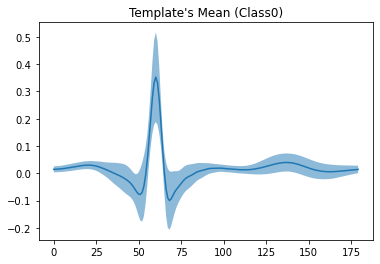

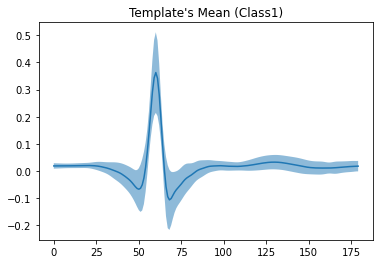

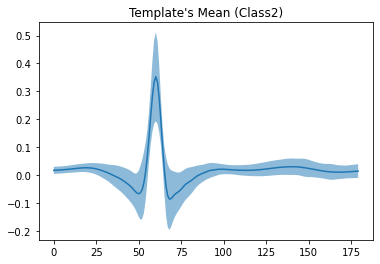

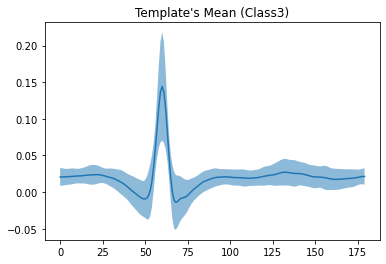

In [13]:
df_templates_mean_class0 = get_templates_mean(df_ecg_class0)
df_templates_mean_class1 = get_templates_mean(df_ecg_class1)
df_templates_mean_class2 = get_templates_mean(df_ecg_class2)
df_templates_mean_class3 = get_templates_mean(df_ecg_class3)
plot_mean(df_templates_mean_class0, title="Template's Mean (Class0)")
plot_mean(df_templates_mean_class1, title="Template's Mean (Class1)")
plot_mean(df_templates_mean_class2, title="Template's Mean (Class2)")
plot_mean(df_templates_mean_class3, title="Template's Mean (Class3)")

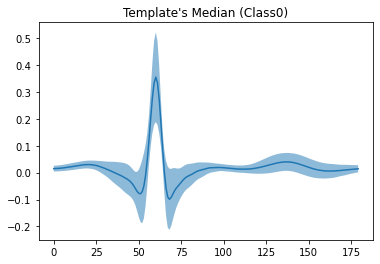

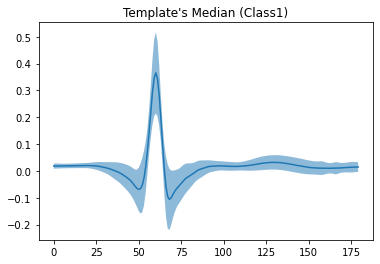

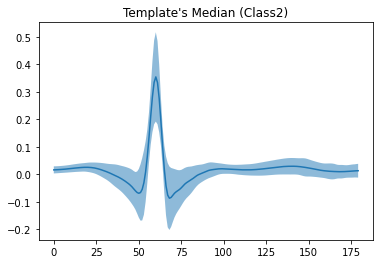

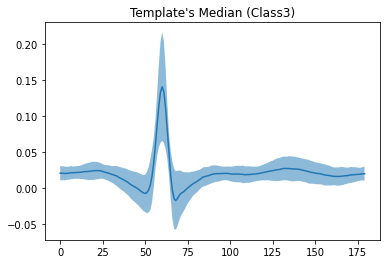

In [14]:
df_templates_median_class0 = get_templates_median(df_ecg_class0)
df_templates_median_class1 = get_templates_median(df_ecg_class1)
df_templates_median_class2 = get_templates_median(df_ecg_class2)
df_templates_median_class3 = get_templates_median(df_ecg_class3)
plot_mean(df_templates_median_class0, title="Template's Median (Class0)")
plot_mean(df_templates_median_class1, title="Template's Median (Class1)")
plot_mean(df_templates_median_class2, title="Template's Median (Class2)")
plot_mean(df_templates_median_class3, title="Template's Median (Class3)")

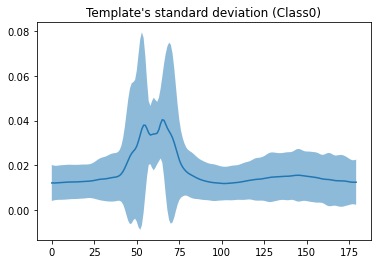

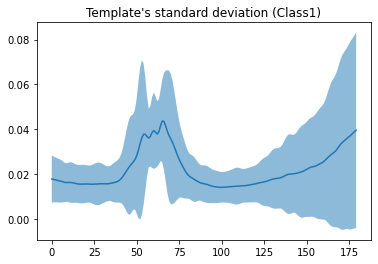

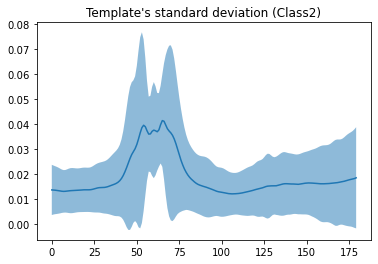

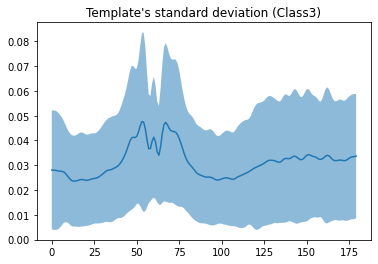

In [18]:
df_templates_std_class0 = get_templates_std(df_ecg_class0, scale=None)
df_templates_std_class1 = get_templates_std(df_ecg_class1, scale=None)
df_templates_std_class2 = get_templates_std(df_ecg_class2, scale=None)
df_templates_std_class3 = get_templates_std(df_ecg_class3, scale=None)
plot_mean(df_templates_std_class0, title="Template's standard deviation (Class0)")
plot_mean(df_templates_std_class1, title="Template's standard deviation (Class1)")
plot_mean(df_templates_std_class2, title="Template's standard deviation (Class2)")
plot_mean(df_templates_std_class3, title="Template's standard deviation (Class3)")

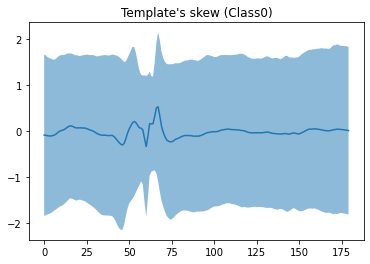

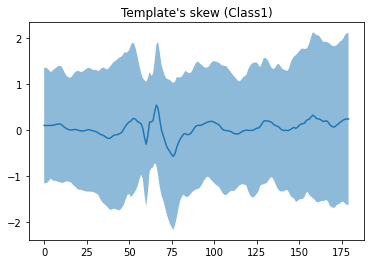

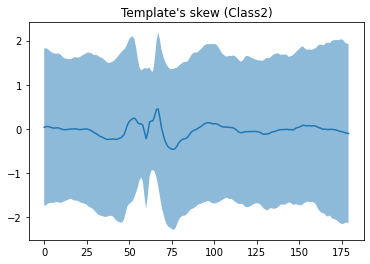

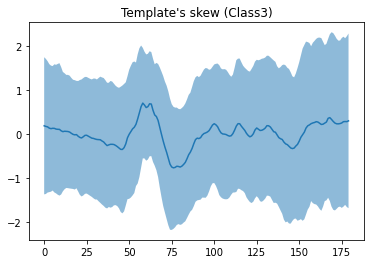

In [179]:
df_templates_skew_class0 = get_templates_skew(df_ecg_class0)
df_templates_skew_class1 = get_templates_skew(df_ecg_class1)
df_templates_skew_class2 = get_templates_skew(df_ecg_class2)
df_templates_skew_class3 = get_templates_skew(df_ecg_class3)
plot_mean(df_templates_skew_class0, title="Template's skew (Class0)")
plot_mean(df_templates_skew_class1, title="Template's skew (Class1)")
plot_mean(df_templates_skew_class2, title="Template's skew (Class2)")
plot_mean(df_templates_skew_class3, title="Template's skew (Class3)")

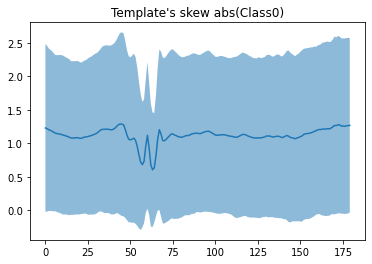

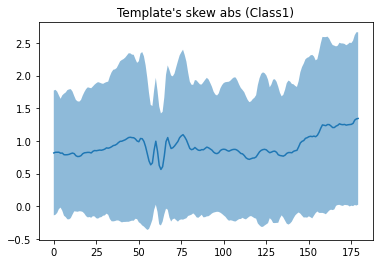

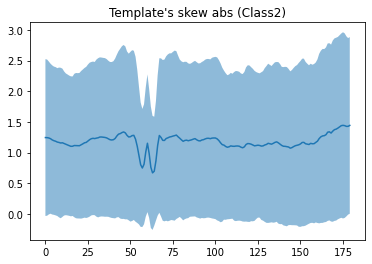

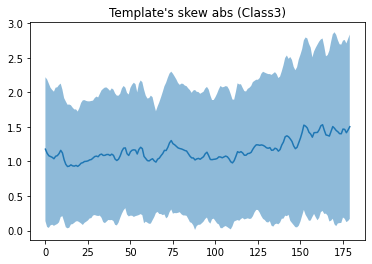

In [178]:
df_templates_skew_abs_class0 = get_templates_skew_abs(df_ecg_class0)
df_templates_skew_abs_class1 = get_templates_skew_abs(df_ecg_class1)
df_templates_skew_abs_class2 = get_templates_skew_abs(df_ecg_class2)
df_templates_skew_abs_class3 = get_templates_skew_abs(df_ecg_class3)
plot_mean(df_templates_skew_abs_class0, title="Template's skew abs(Class0)")
plot_mean(df_templates_skew_abs_class1, title="Template's skew abs (Class1)")
plot_mean(df_templates_skew_abs_class2, title="Template's skew abs (Class2)")
plot_mean(df_templates_skew_abs_class3, title="Template's skew abs (Class3)")

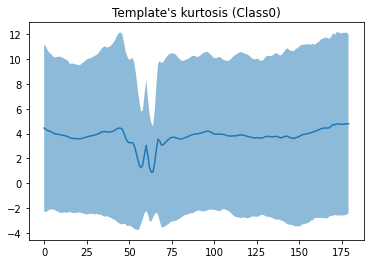

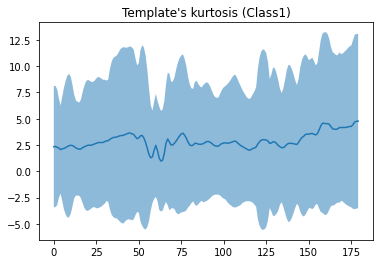

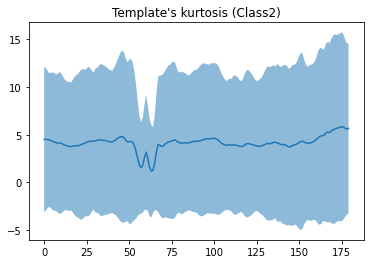

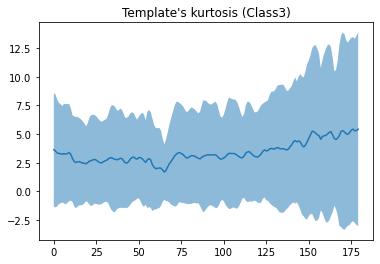

In [174]:
df_templates_kurtosis_class0 = get_templates_kurtosis(df_ecg_class0)
df_templates_kurtosis_class1 = get_templates_kurtosis(df_ecg_class1)
df_templates_kurtosis_class2 = get_templates_kurtosis(df_ecg_class2)
df_templates_kurtosis_class3 = get_templates_kurtosis(df_ecg_class3)
plot_mean(df_templates_kurtosis_class0, title="Template's kurtosis (Class0)")
plot_mean(df_templates_kurtosis_class1, title="Template's kurtosis (Class1)")
plot_mean(df_templates_kurtosis_class2, title="Template's kurtosis (Class2)")
plot_mean(df_templates_kurtosis_class3, title="Template's kurtosis (Class3)")

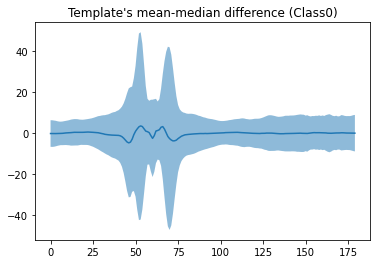

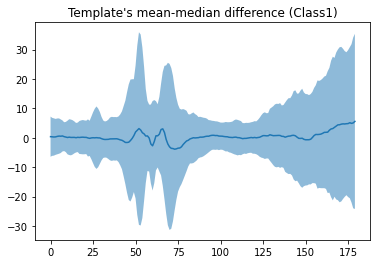

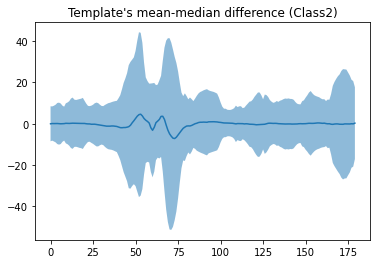

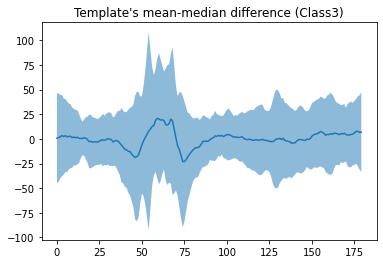

In [96]:
df_templates_mean_median_diff_class0, df_templates_mean_median_diff_abs_class0 = get_templates_mean_median_diff(df_ecg_class0, scale=None)
df_templates_mean_median_diff_class1, df_templates_mean_median_diff_abs_class1 = get_templates_mean_median_diff(df_ecg_class1, scale=None)
df_templates_mean_median_diff_class2, df_templates_mean_median_diff_abs_class2 = get_templates_mean_median_diff(df_ecg_class2, scale=None)
df_templates_mean_median_diff_class3, df_templates_mean_median_diff_abs_class3 = get_templates_mean_median_diff(df_ecg_class3, scale=None)
plot_mean(df_templates_mean_median_diff_class0, title="Template's mean-median difference (Class0)")
plot_mean(df_templates_mean_median_diff_class1, title="Template's mean-median difference (Class1)")
plot_mean(df_templates_mean_median_diff_class2, title="Template's mean-median difference (Class2)")
plot_mean(df_templates_mean_median_diff_class3, title="Template's mean-median difference (Class3)")

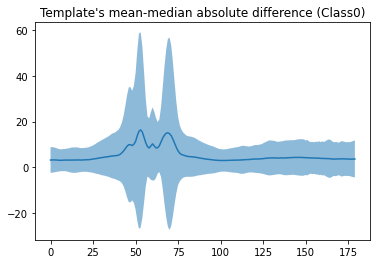

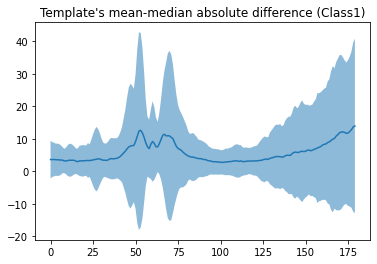

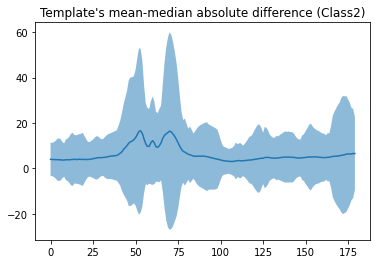

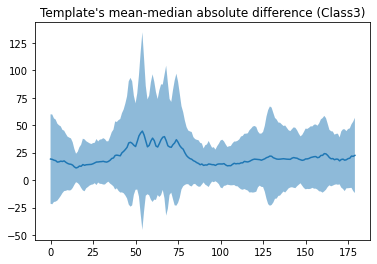

In [97]:
plot_mean(df_templates_mean_median_diff_abs_class0, title="Template's mean-median absolute difference (Class0)")
plot_mean(df_templates_mean_median_diff_abs_class1, title="Template's mean-median absolute difference (Class1)")
plot_mean(df_templates_mean_median_diff_abs_class2, title="Template's mean-median absolute difference (Class2)")
plot_mean(df_templates_mean_median_diff_abs_class3, title="Template's mean-median absolute difference (Class3)")

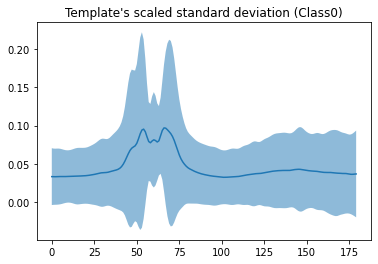

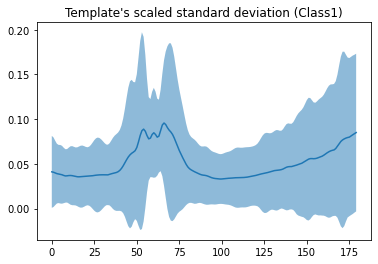

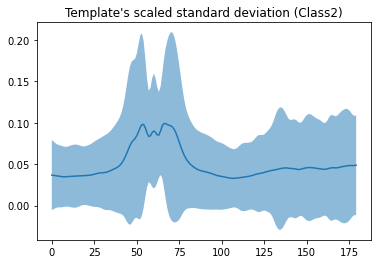

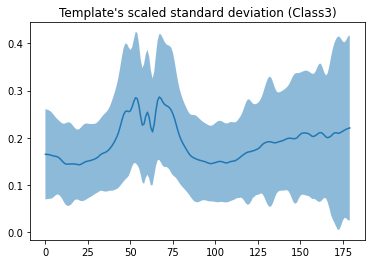

In [95]:
df_templates_std_scaled_class0 = get_templates_std(df_ecg_class0, scale="minmax")
df_templates_std_scaled_class1 = get_templates_std(df_ecg_class1, scale="minmax")
df_templates_std_scaled_class2 = get_templates_std(df_ecg_class2, scale="minmax")
df_templates_std_scaled_class3 = get_templates_std(df_ecg_class3, scale="minmax")
plot_mean(df_templates_std_scaled_class0, title="Template's scaled standard deviation (Class0)")
plot_mean(df_templates_std_scaled_class1, title="Template's scaled standard deviation (Class1)")
plot_mean(df_templates_std_scaled_class2, title="Template's scaled standard deviation (Class2)")
plot_mean(df_templates_std_scaled_class3, title="Template's scaled standard deviation (Class3)")

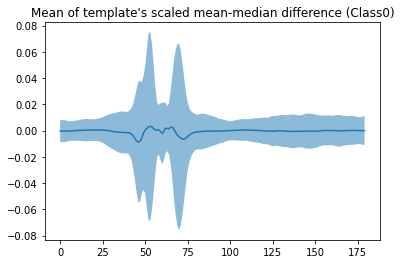

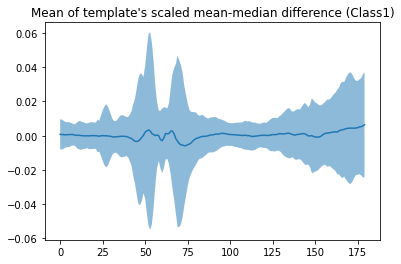

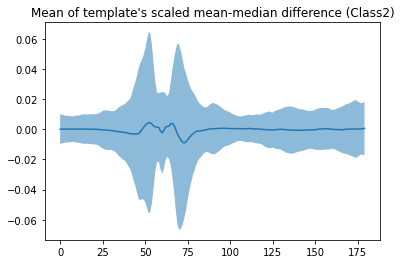

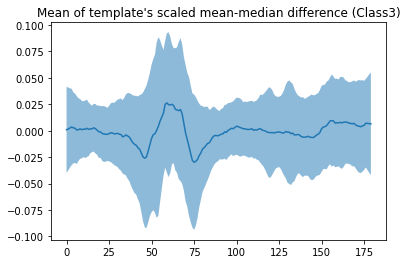

In [224]:
# Doesn't make sense to scale minmax here because all already have same scale due to minmax scaling of signals
df_templates_mean_median_diff_scaled_class0, df_templates_mean_median_diff_scaled_abs_class0 = get_templates_mean_median_diff(df_ecg_class0, scale="minmax")
df_templates_mean_median_diff_scaled_class1, df_templates_mean_median_diff_scaled_abs_class1 = get_templates_mean_median_diff(df_ecg_class1, scale="minmax")
df_templates_mean_median_diff_scaled_class2, df_templates_mean_median_diff_scaled_abs_class2 = get_templates_mean_median_diff(df_ecg_class2, scale="minmax")
df_templates_mean_median_diff_scaled_class3, df_templates_mean_median_diff_scaled_abs_class3 = get_templates_mean_median_diff(df_ecg_class3, scale="minmax")
plot_mean(df_templates_mean_median_diff_scaled_class0, title="Template's scaled mean-median difference (Class0)")
plot_mean(df_templates_mean_median_diff_scaled_class1, title="Template's scaled mean-median difference (Class1)")
plot_mean(df_templates_mean_median_diff_scaled_class2, title="Template's scaled mean-median difference (Class2)")
plot_mean(df_templates_mean_median_diff_scaled_class3, title="Template's scaled mean-median difference (Class3)")

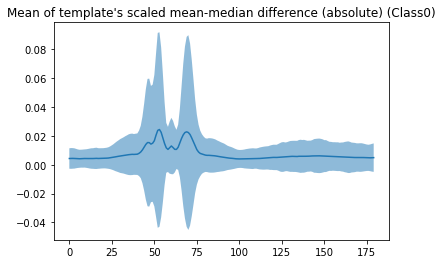

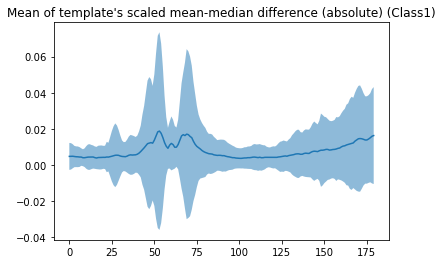

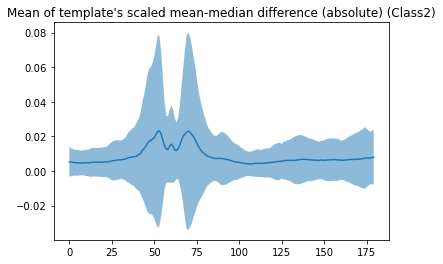

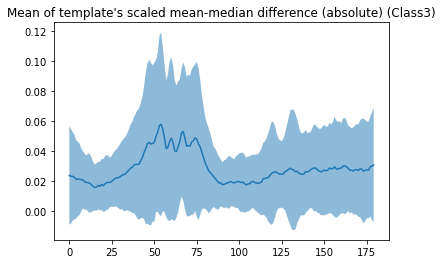

In [227]:
# Doesn't make sense to scale minmax here because all already have same scale due to minmax scaling of signals
plot_mean(df_templates_mean_median_diff_scaled_abs_class0, title="Mean of template's scaled mean-median difference (absolute) (Class0)")
plot_mean(df_templates_mean_median_diff_scaled_abs_class1, title="Mean of template's scaled mean-median difference (absolute) (Class1)")
plot_mean(df_templates_mean_median_diff_scaled_abs_class2, title="Mean of template's scaled mean-median difference (absolute) (Class2)")
plot_mean(df_templates_mean_median_diff_scaled_abs_class3, title="Mean of template's scaled mean-median difference (absolute) (Class3)")

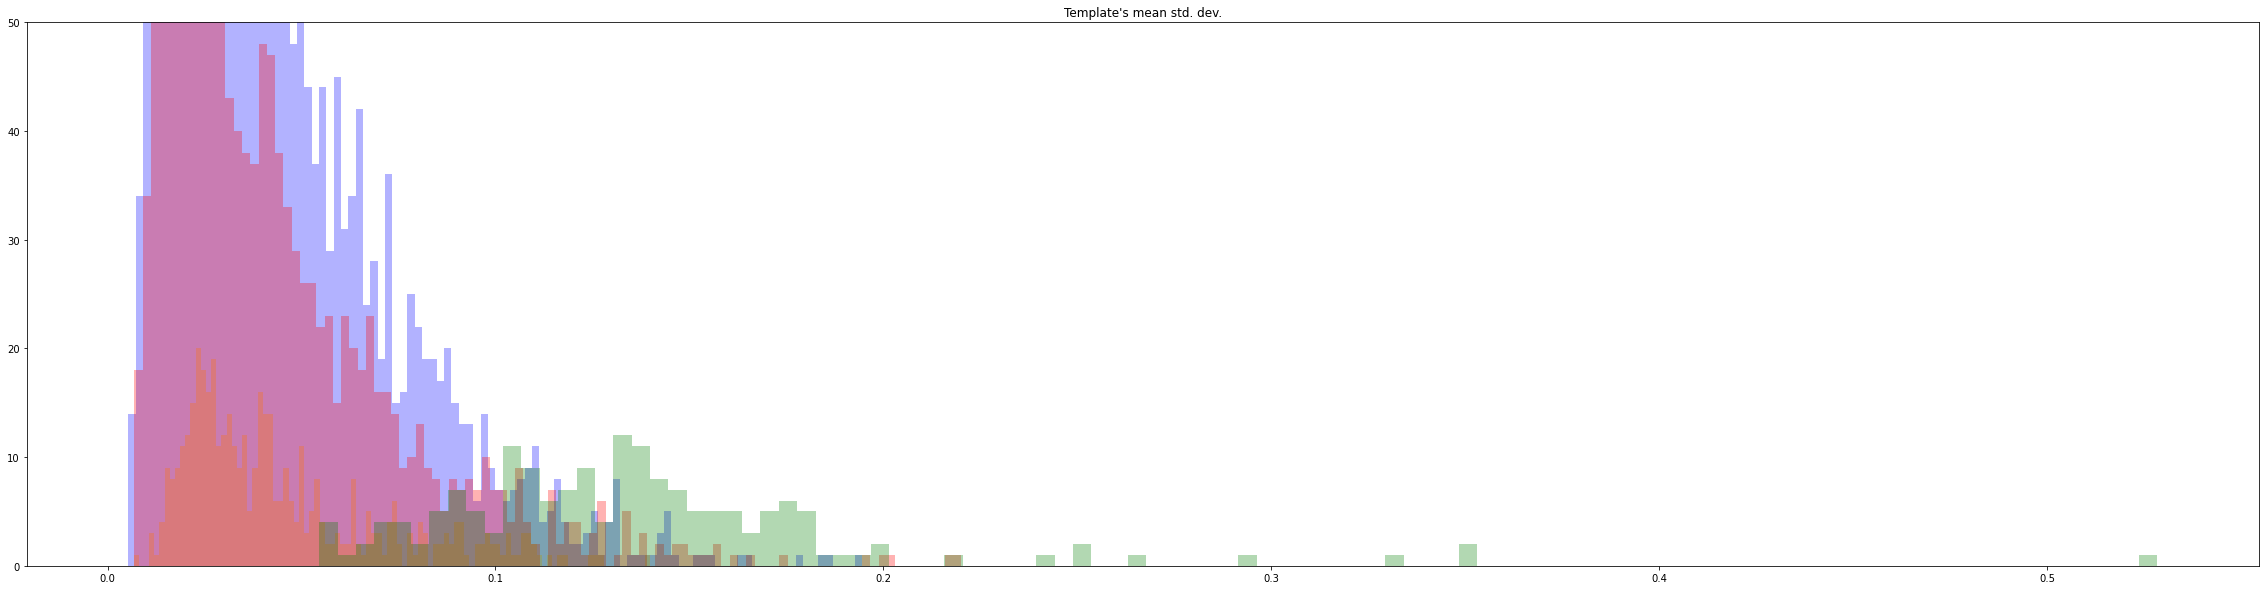

In [47]:
#df_templates_std_class0 = get_templates_std(df_ecg_class0, scale=None)
#df_templates_std_class1 = get_templates_std(df_ecg_class1, scale=None)
#df_templates_std_class2 = get_templates_std(df_ecg_class2, scale=None)
#df_templates_std_class3 = get_templates_std(df_ecg_class3, scale=None)

df_templates_std_mean_class0 = df_templates_std_class0.mean(axis=1)
df_templates_std_mean_class1 = df_templates_std_class1.mean(axis=1)
df_templates_std_mean_class2 = df_templates_std_class2.mean(axis=1)
df_templates_std_mean_class3 = df_templates_std_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_std_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_std_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_std_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_std_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's mean std. dev.")
plt.show()

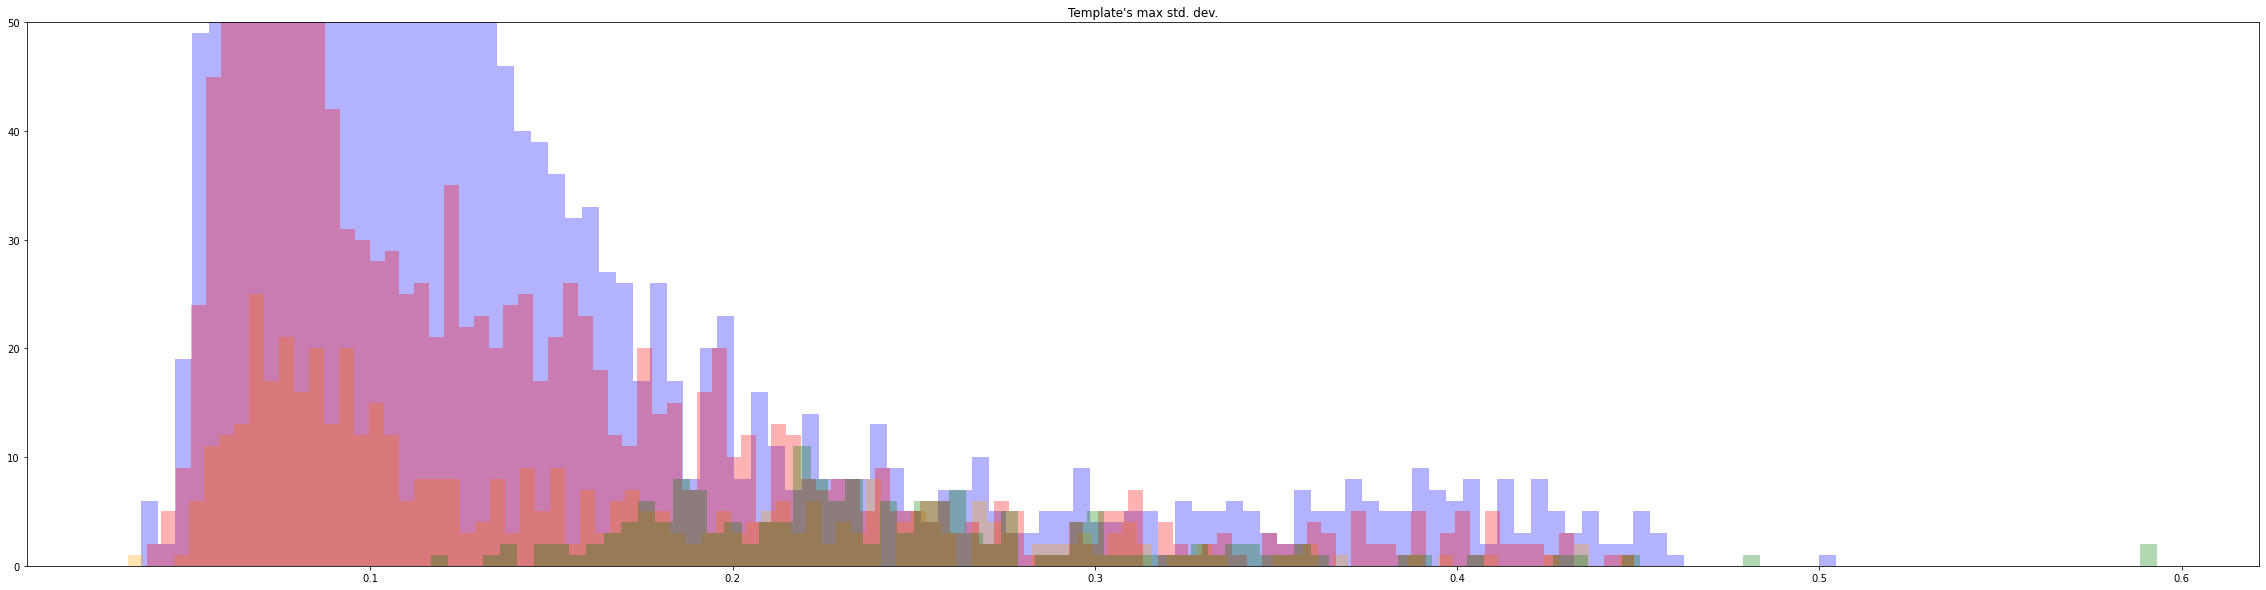

In [51]:
df_templates_std_max_class0 = df_templates_std_class0.max(axis=1)
df_templates_std_max_class1 = df_templates_std_class1.max(axis=1)
df_templates_std_max_class2 = df_templates_std_class2.max(axis=1)
df_templates_std_max_class3 = df_templates_std_class3.max(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_std_max_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_std_max_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_std_max_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_std_max_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's max std. dev.")
plt.show()

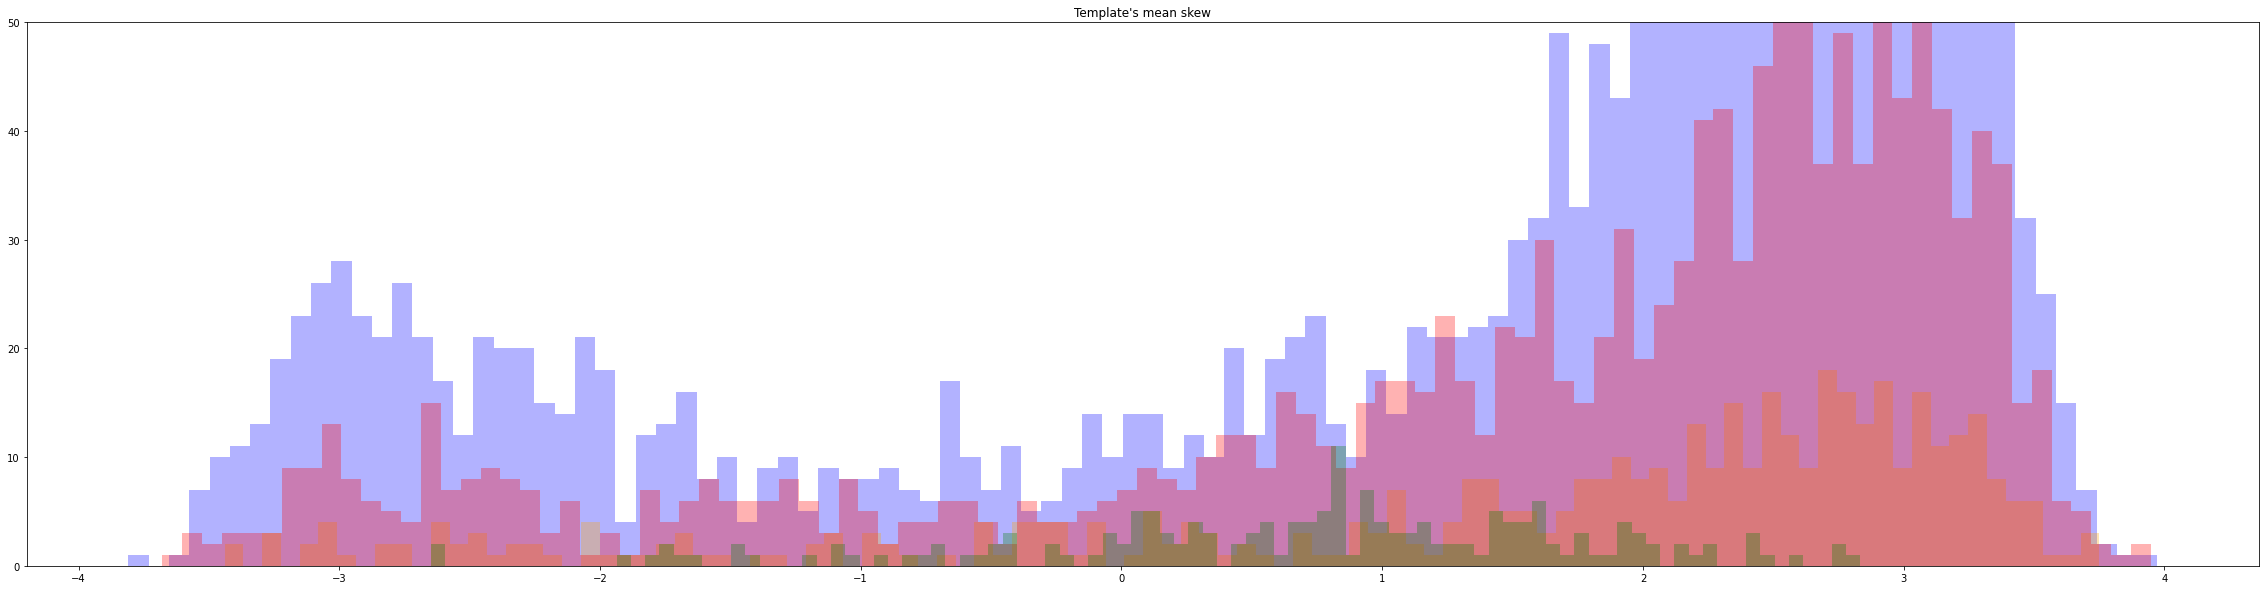

In [49]:
df_templates_skew_mean_class0 = df_templates_skew_class0.mean(axis=1)
df_templates_skew_mean_class1 = df_templates_skew_class1.mean(axis=1)
df_templates_skew_mean_class2 = df_templates_skew_class2.mean(axis=1)
df_templates_skew_mean_class3 = df_templates_skew_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_skew_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_skew_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_skew_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_skew_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's mean skew")
plt.show()

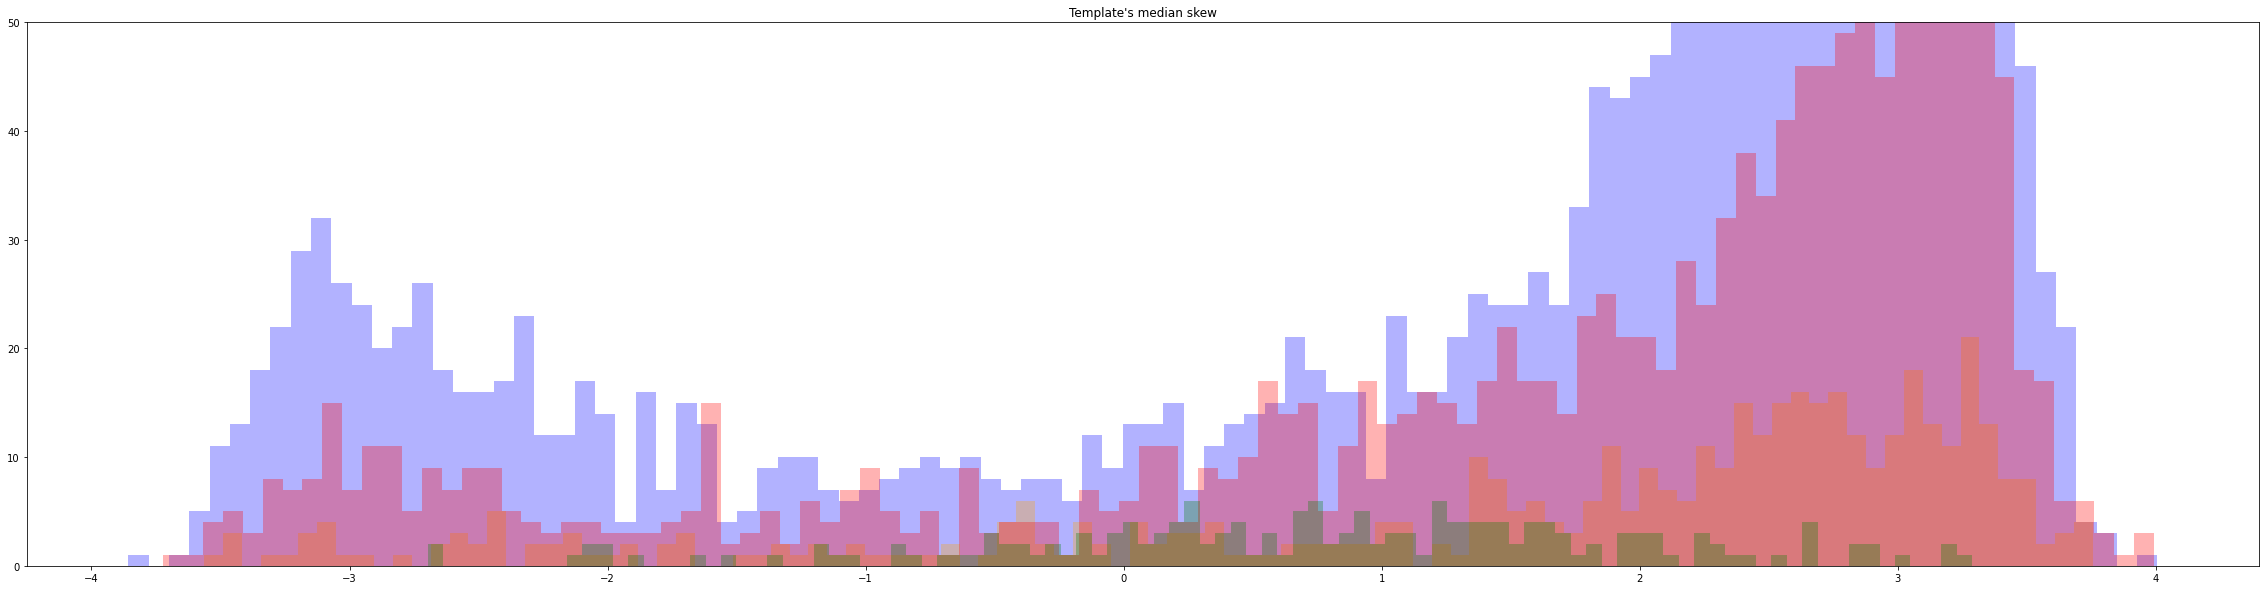

In [108]:
df_templates_skew_median_class0 = df_templates_skew_class0.median(axis=1)
df_templates_skew_median_class1 = df_templates_skew_class1.median(axis=1)
df_templates_skew_median_class2 = df_templates_skew_class2.median(axis=1)
df_templates_skew_median_class3 = df_templates_skew_class3.median(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_skew_median_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_skew_median_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_skew_median_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_skew_median_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's median skew")
plt.show()

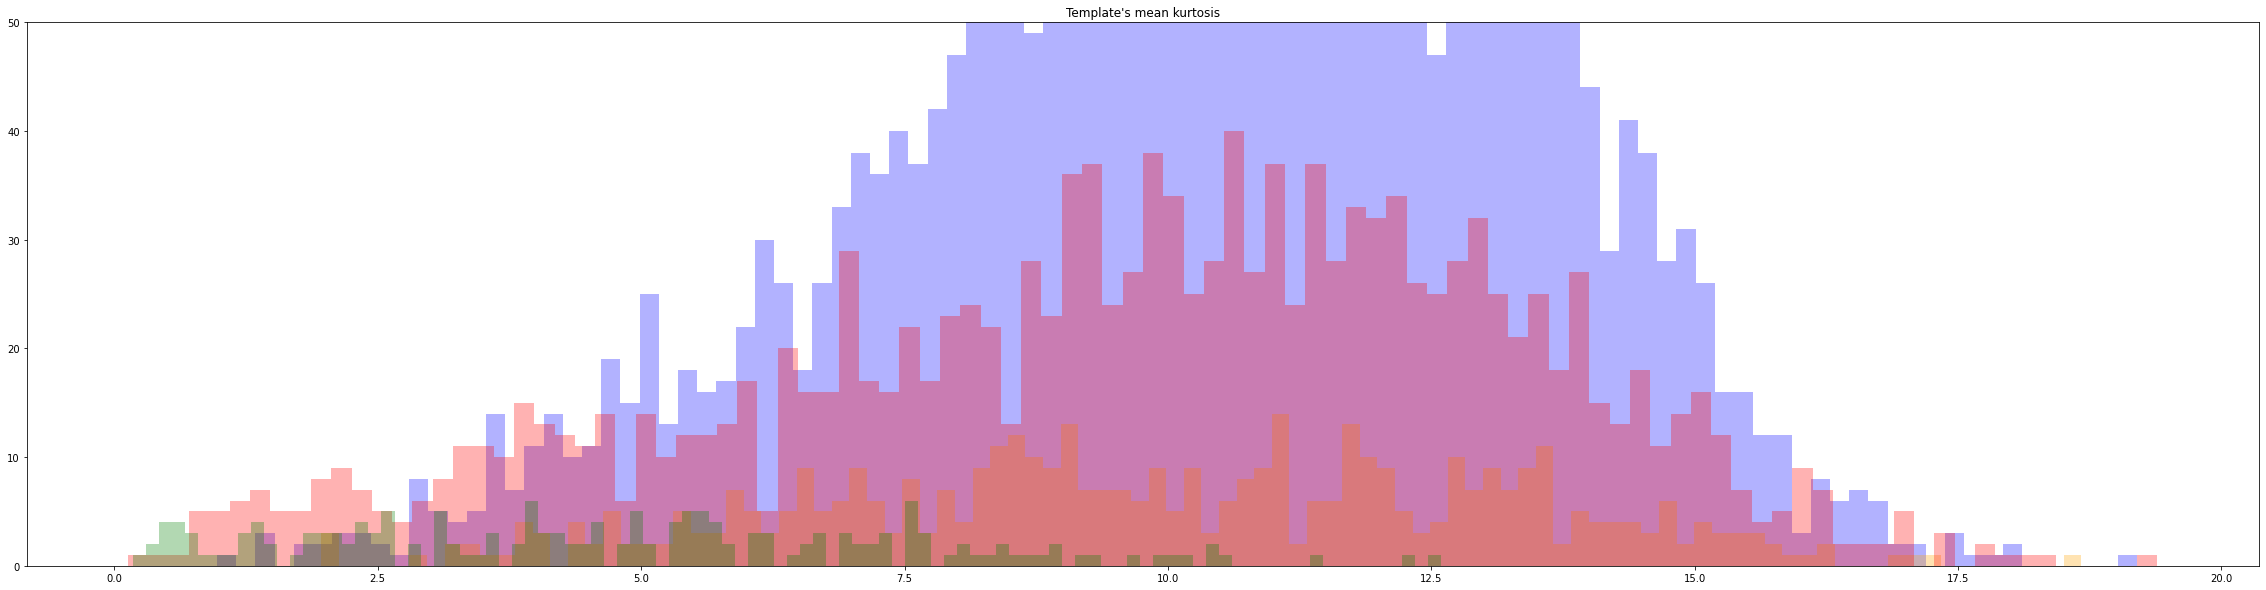

In [47]:
df_templates_kurtosis_mean_class0 = df_templates_kurtosis_class0.mean(axis=1)
df_templates_kurtosis_mean_class1 = df_templates_kurtosis_class1.mean(axis=1)
df_templates_kurtosis_mean_class2 = df_templates_kurtosis_class2.mean(axis=1)
df_templates_kurtosis_mean_class3 = df_templates_kurtosis_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_kurtosis_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_kurtosis_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_kurtosis_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_kurtosis_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's mean kurtosis")
plt.show()

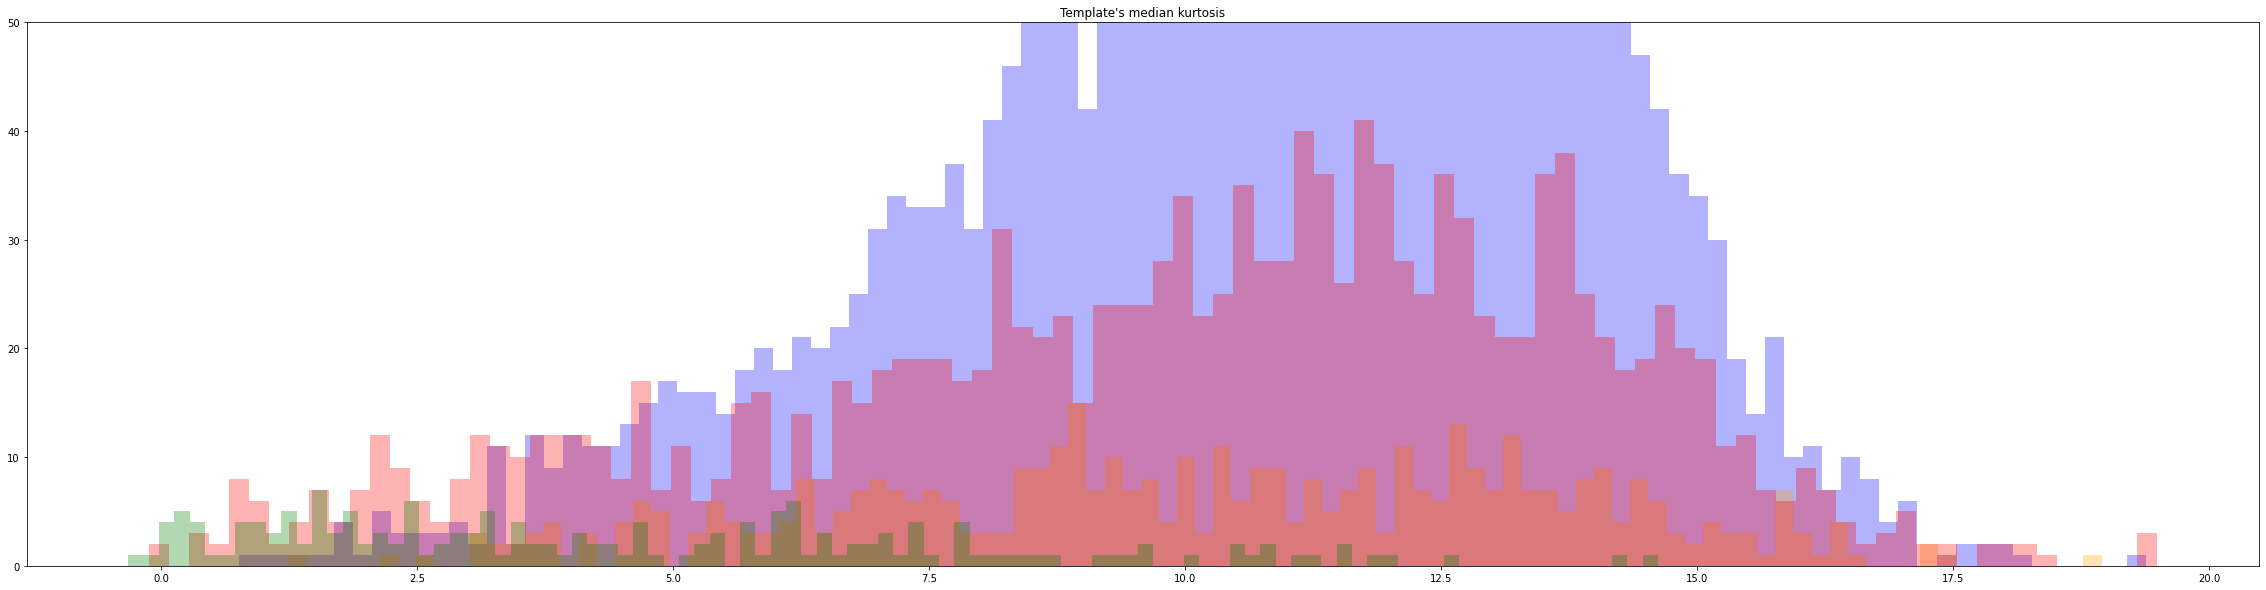

In [107]:
df_templates_kurtosis_median_class0 = df_templates_kurtosis_class0.median(axis=1)
df_templates_kurtosis_median_class1 = df_templates_kurtosis_class1.median(axis=1)
df_templates_kurtosis_median_class2 = df_templates_kurtosis_class2.median(axis=1)
df_templates_kurtosis_median_class3 = df_templates_kurtosis_class3.median(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_kurtosis_median_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_kurtosis_median_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_kurtosis_median_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_kurtosis_median_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's median kurtosis")
plt.show()

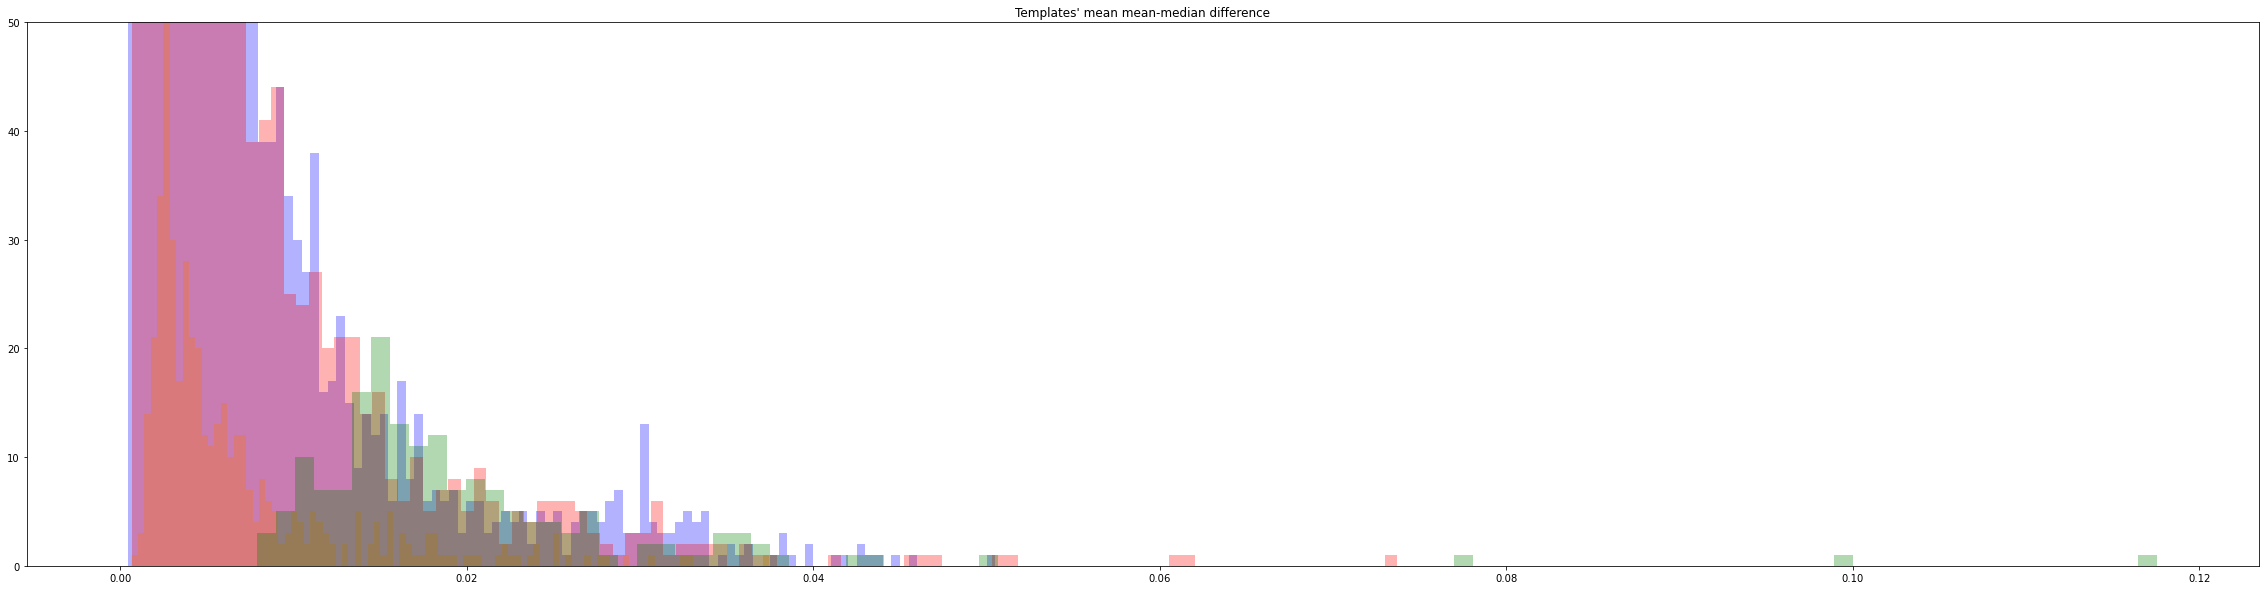

In [49]:
df_templates_mean_median_diff_class0, df_templates_mean_median_diff_abs_class0 = get_templates_mean_median_diff(df_ecg_class0, scale=None)
df_templates_mean_median_diff_class1, df_templates_mean_median_diff_abs_class1 = get_templates_mean_median_diff(df_ecg_class1, scale=None)
df_templates_mean_median_diff_class2, df_templates_mean_median_diff_abs_class2 = get_templates_mean_median_diff(df_ecg_class2, scale=None)
df_templates_mean_median_diff_class3, df_templates_mean_median_diff_abs_class3 = get_templates_mean_median_diff(df_ecg_class3, scale=None)

df_templates_mean_median_diff_abs_mean_class0 = df_templates_mean_median_diff_abs_class0.mean(axis=1)
df_templates_mean_median_diff_abs_mean_class1 = df_templates_mean_median_diff_abs_class1.mean(axis=1)
df_templates_mean_median_diff_abs_mean_class2 = df_templates_mean_median_diff_abs_class2.mean(axis=1)
df_templates_mean_median_diff_abs_mean_class3 = df_templates_mean_median_diff_abs_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_mean_median_diff_abs_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_mean_median_diff_abs_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_mean_median_diff_abs_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_mean_median_diff_abs_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Templates' mean mean-median absolute difference")
plt.show()

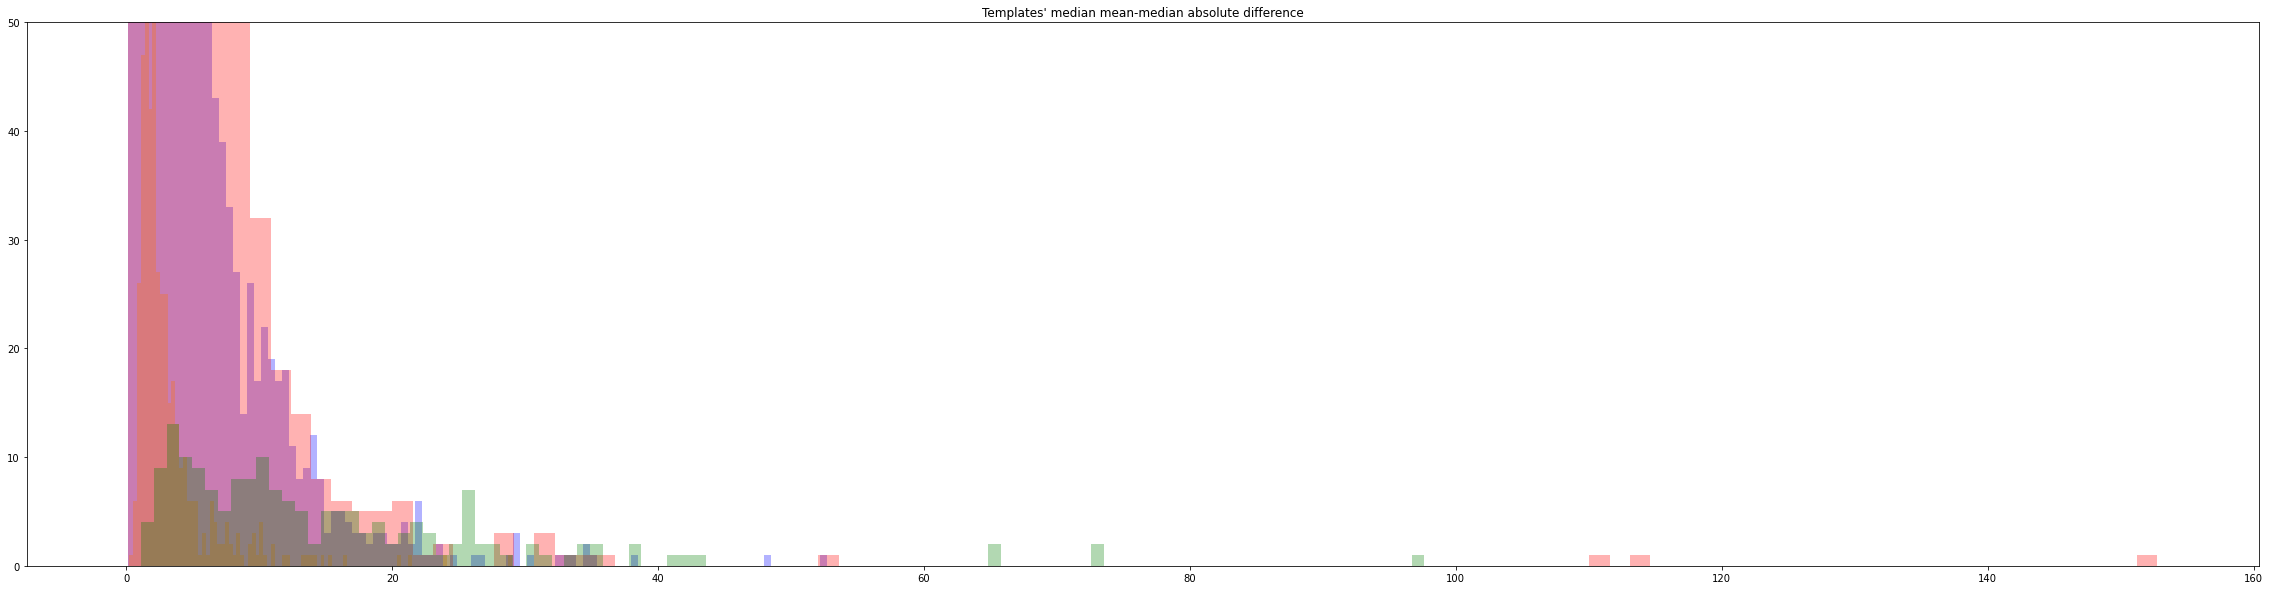

In [109]:
df_templates_mean_median_diff_abs_median_class0 = np.median(df_templates_mean_median_diff_abs_class0, axis=1)
df_templates_mean_median_diff_abs_median_class1 = np.median(df_templates_mean_median_diff_abs_class1, axis=1)
df_templates_mean_median_diff_abs_median_class2 = np.median(df_templates_mean_median_diff_abs_class2, axis=1)
df_templates_mean_median_diff_abs_median_class3 = np.median(df_templates_mean_median_diff_abs_class3, axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_mean_median_diff_abs_median_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_mean_median_diff_abs_median_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_mean_median_diff_abs_median_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_mean_median_diff_abs_median_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Templates' median mean-median absolute difference")
plt.show()

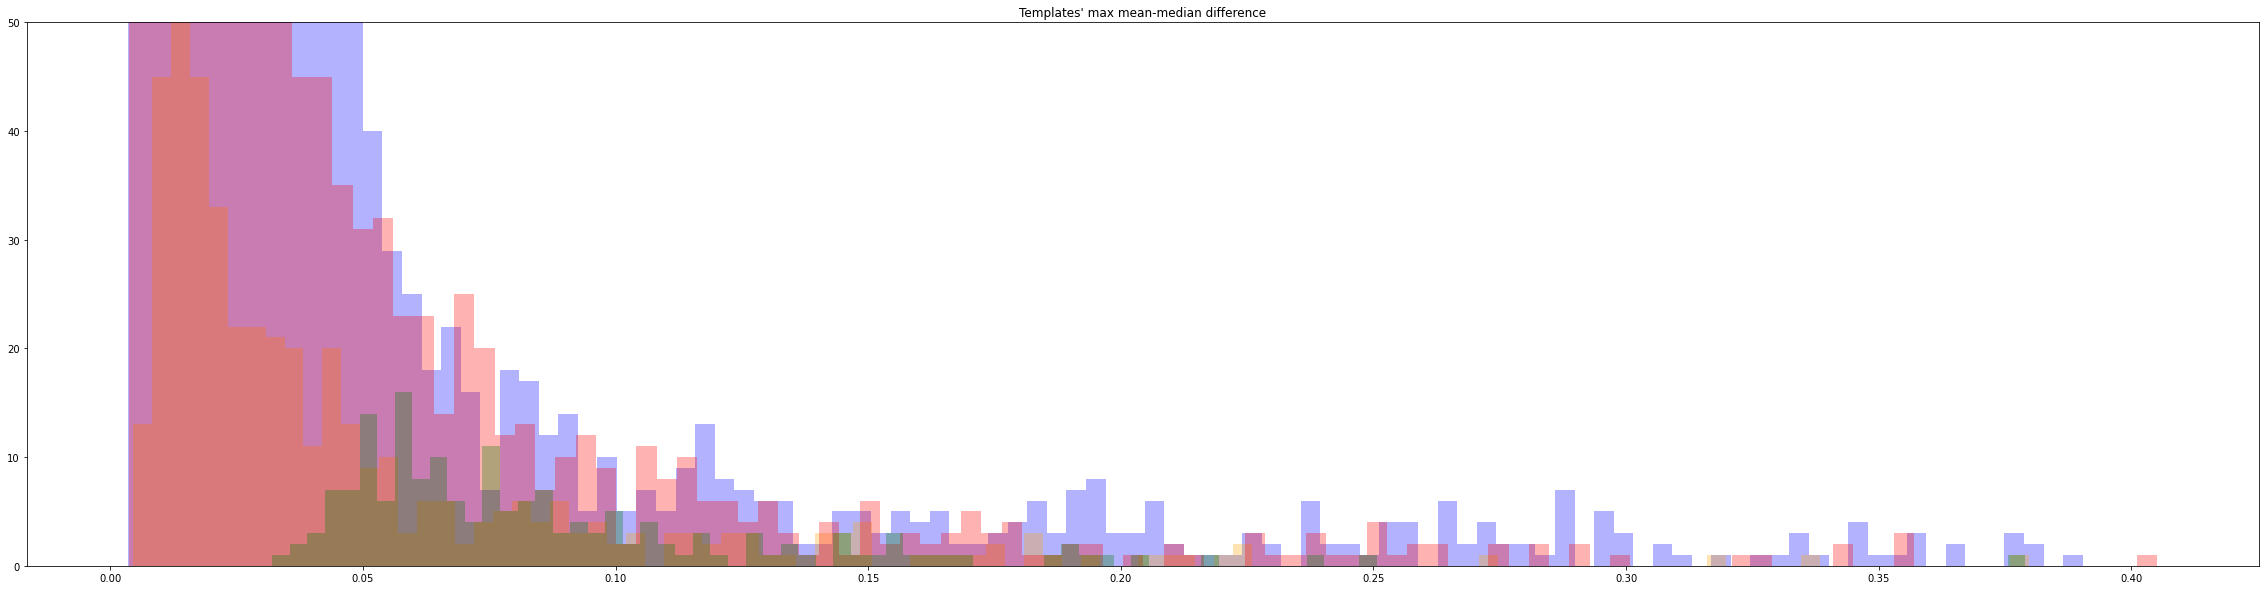

In [50]:
df_templates_mean_median_diff_abs_max_class0 = df_templates_mean_median_diff_abs_class0.max(axis=1)
df_templates_mean_median_diff_abs_max_class1 = df_templates_mean_median_diff_abs_class1.max(axis=1)
df_templates_mean_median_diff_abs_max_class2 = df_templates_mean_median_diff_abs_class2.max(axis=1)
df_templates_mean_median_diff_abs_max_class3 = df_templates_mean_median_diff_abs_class3.max(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_mean_median_diff_abs_max_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_mean_median_diff_abs_max_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_mean_median_diff_abs_max_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_mean_median_diff_abs_max_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Templates' max mean-median difference")
plt.show()

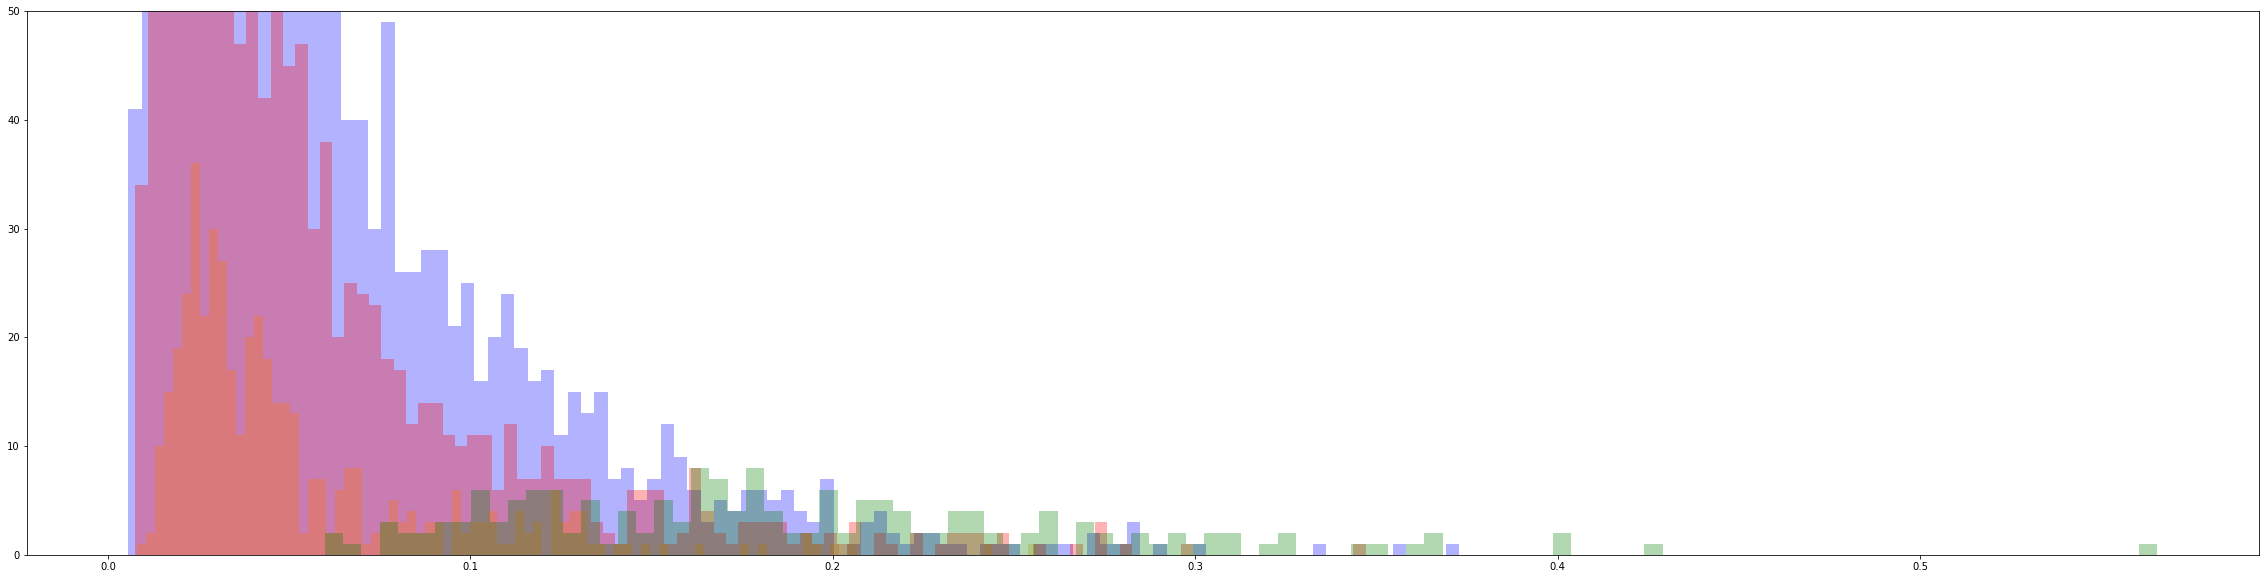

In [23]:
df_templates_std_scaled_class0 = get_templates_std(df_ecg_class0, scale="minmax")
df_templates_std_scaled_class1 = get_templates_std(df_ecg_class1, scale="minmax")
df_templates_std_scaled_class2 = get_templates_std(df_ecg_class2, scale="minmax")
df_templates_std_scaled_class3 = get_templates_std(df_ecg_class3, scale="minmax")

df_templates_std_scaled_mean_class0 = df_templates_std_scaled_class0.mean(axis=1)
df_templates_std_scaled_mean_class1 = df_templates_std_scaled_class1.mean(axis=1)
df_templates_std_scaled_mean_class2 = df_templates_std_scaled_class2.mean(axis=1)
df_templates_std_scaled_mean_class3 = df_templates_std_scaled_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_std_scaled_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_std_scaled_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_std_scaled_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_std_scaled_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

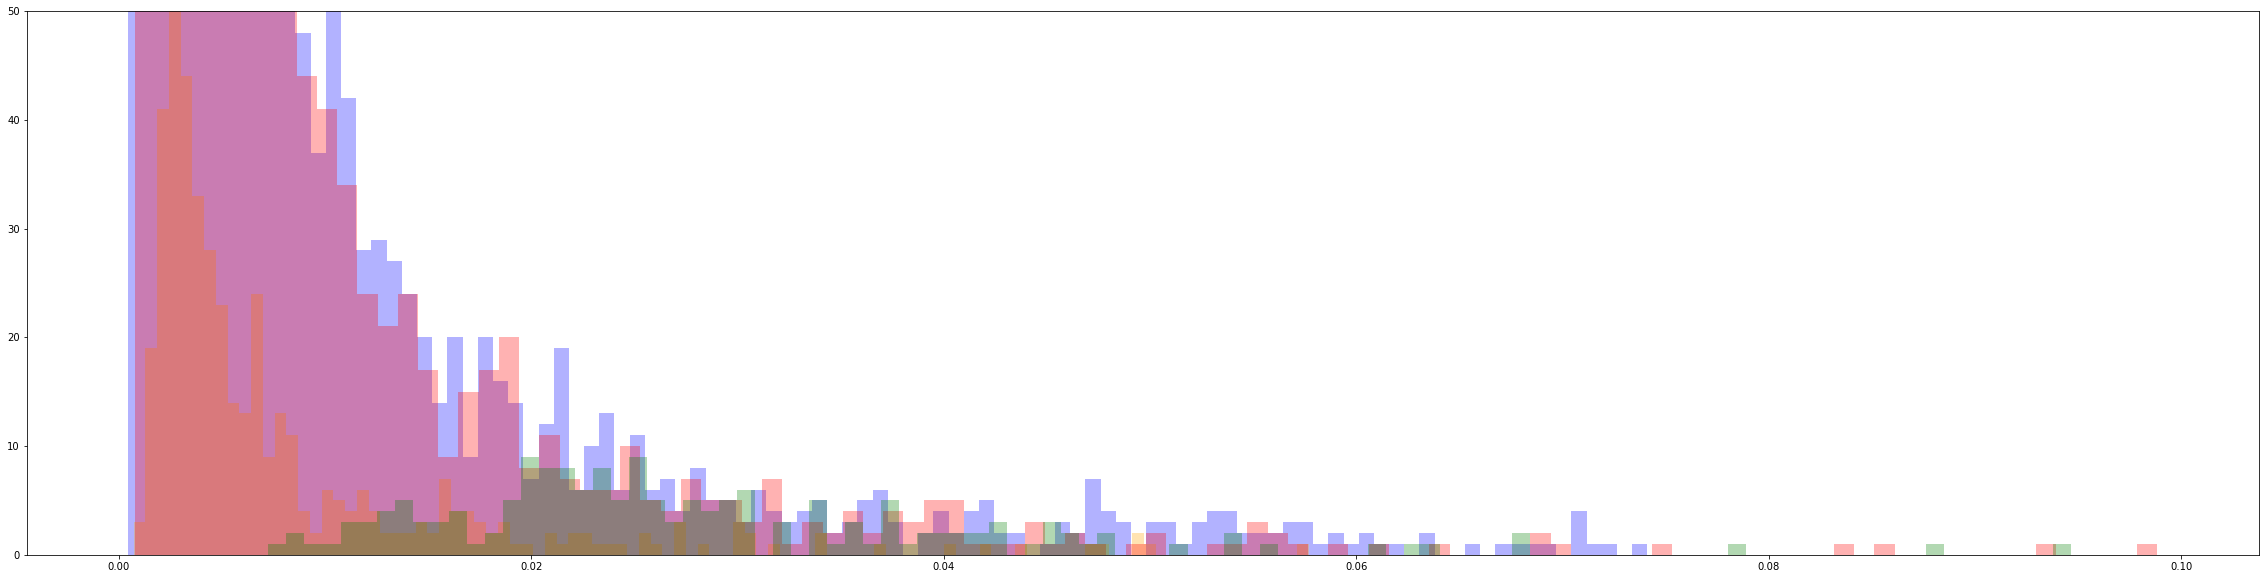

In [29]:
df_templates_mean_median_diff_scaled_class0, df_templates_mean_median_diff_scaled_abs_class0 = get_templates_mean_median_diff(df_ecg_class0, scale="minmax")
df_templates_mean_median_diff_scaled_class1, df_templates_mean_median_diff_scaled_abs_class1 = get_templates_mean_median_diff(df_ecg_class1, scale="minmax")
df_templates_mean_median_diff_scaled_class2, df_templates_mean_median_diff_scaled_abs_class2 = get_templates_mean_median_diff(df_ecg_class2, scale="minmax")
df_templates_mean_median_diff_scaled_class3, df_templates_mean_median_diff_scaled_abs_class3 = get_templates_mean_median_diff(df_ecg_class3, scale="minmax")

df_templates_mean_median_diff_scaled_abs_mean_class0 = df_templates_mean_median_diff_scaled_abs_class0.mean(axis=1)
df_templates_mean_median_diff_scaled_abs_mean_class1 = df_templates_mean_median_diff_scaled_abs_class1.mean(axis=1)
df_templates_mean_median_diff_scaled_abs_mean_class2 = df_templates_mean_median_diff_scaled_abs_class2.mean(axis=1)
df_templates_mean_median_diff_scaled_abs_mean_class3 = df_templates_mean_median_diff_scaled_abs_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_mean_median_diff_scaled_abs_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_mean_median_diff_scaled_abs_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_mean_median_diff_scaled_abs_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_mean_median_diff_scaled_abs_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

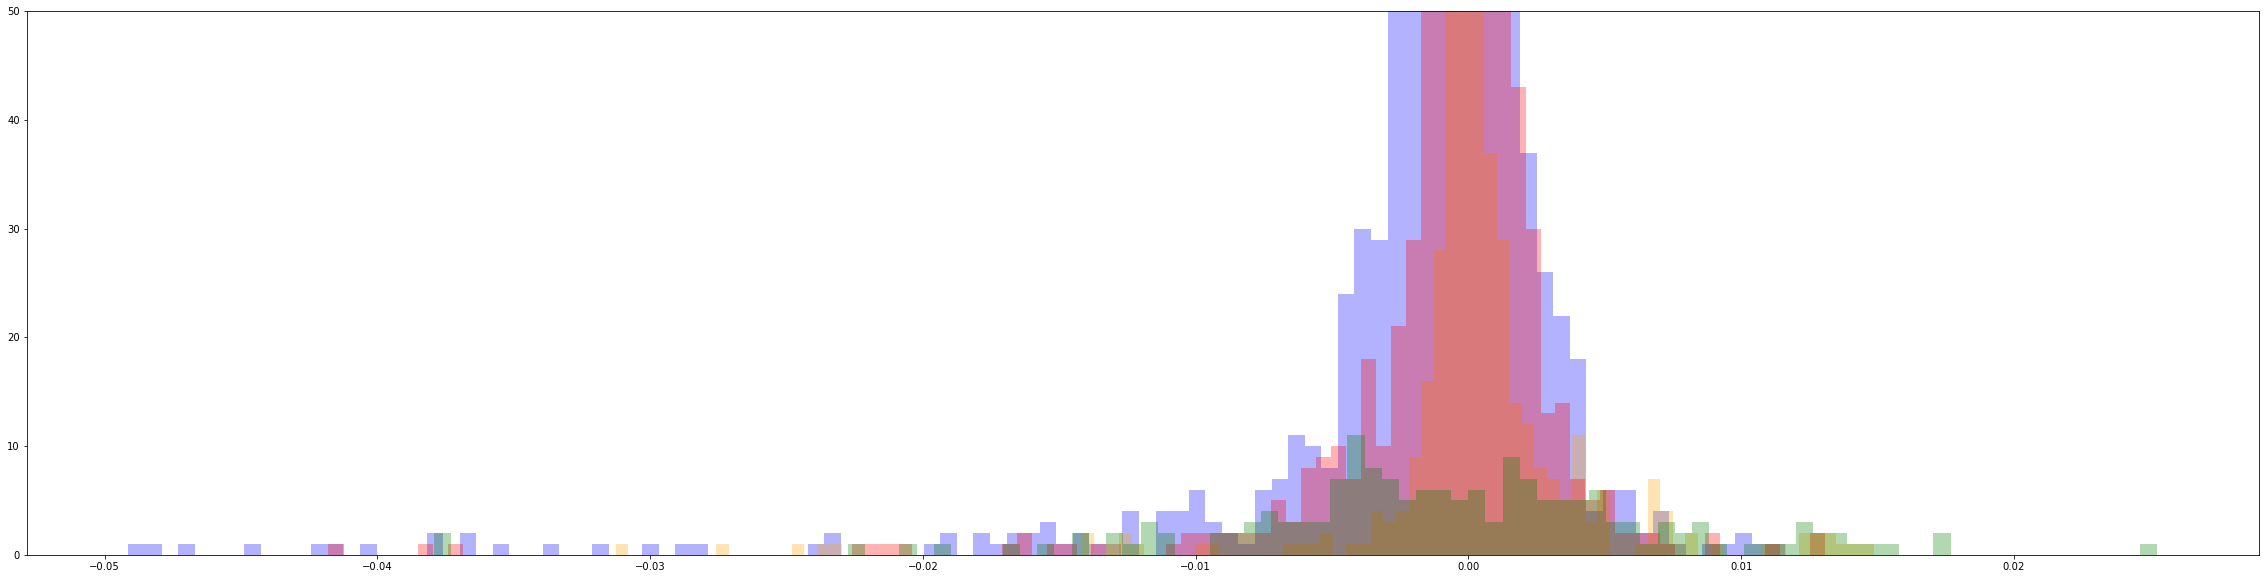

In [30]:
df_templates_mean_median_diff_scaled_mean_class0 = df_templates_mean_median_diff_scaled_class0.mean(axis=1)
df_templates_mean_median_diff_scaled_mean_class1 = df_templates_mean_median_diff_scaled_class1.mean(axis=1)
df_templates_mean_median_diff_scaled_mean_class2 = df_templates_mean_median_diff_scaled_class2.mean(axis=1)
df_templates_mean_median_diff_scaled_mean_class3 = df_templates_mean_median_diff_scaled_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_mean_median_diff_scaled_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_mean_median_diff_scaled_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_mean_median_diff_scaled_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_mean_median_diff_scaled_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

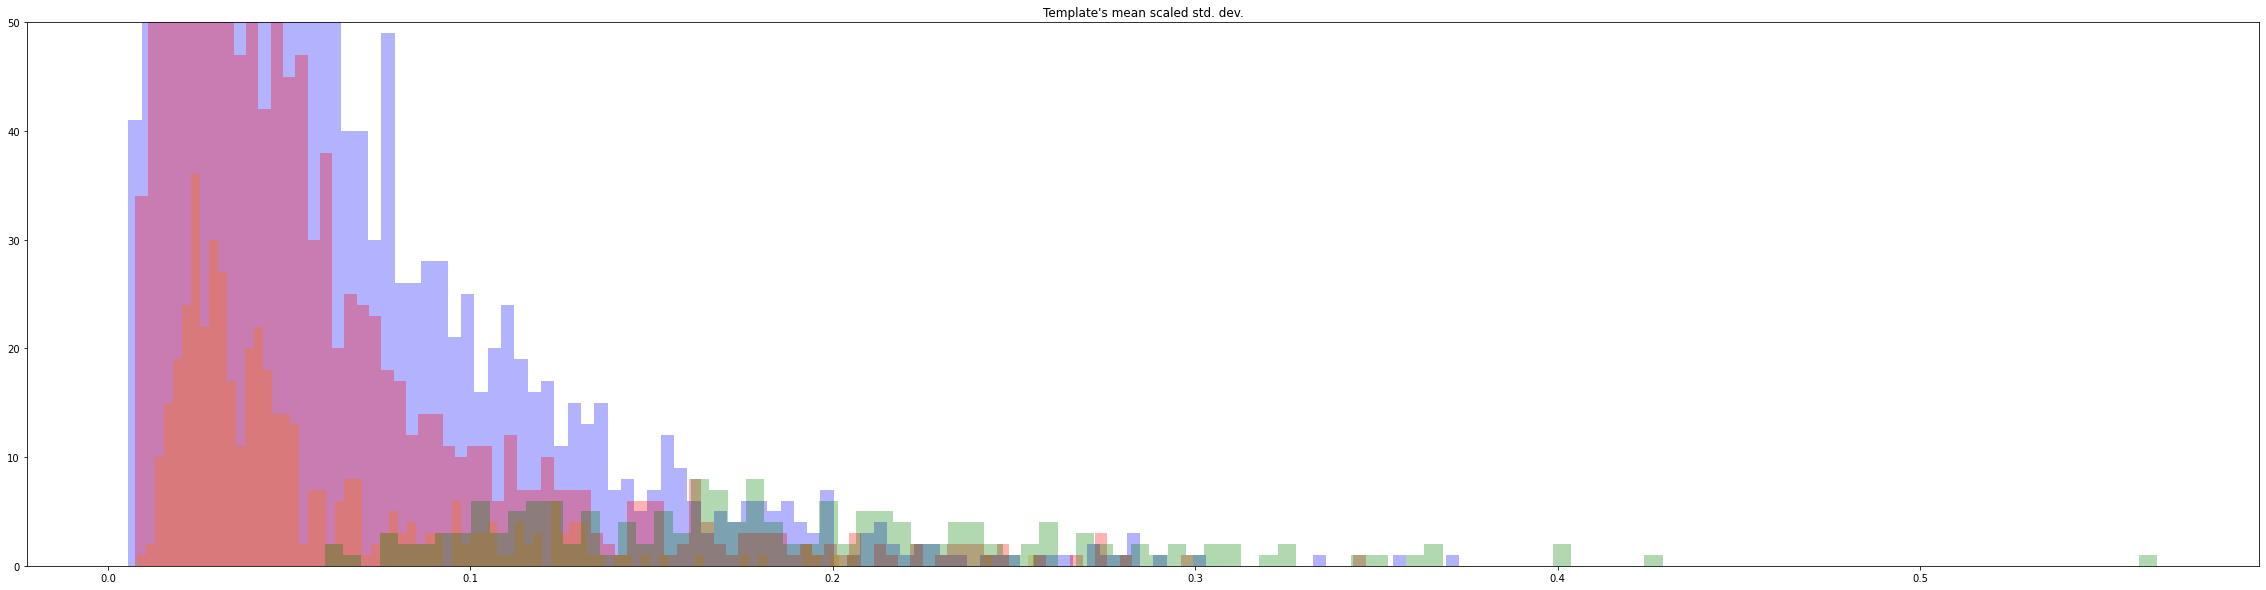

In [98]:
#df_templates_std_class0 = get_templates_std(df_ecg_class0, scale=None)
#df_templates_std_class1 = get_templates_std(df_ecg_class1, scale=None)
#df_templates_std_class2 = get_templates_std(df_ecg_class2, scale=None)
#df_templates_std_class3 = get_templates_std(df_ecg_class3, scale=None)

df_templates_std_scaled_mean_class0 = df_templates_std_scaled_class0.mean(axis=1)
df_templates_std_scaled_mean_class1 = df_templates_std_scaled_class1.mean(axis=1)
df_templates_std_scaled_mean_class2 = df_templates_std_scaled_class2.mean(axis=1)
df_templates_std_scaled_mean_class3 = df_templates_std_scaled_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_std_scaled_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_std_scaled_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_std_scaled_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_std_scaled_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's mean scaled std. dev.")
plt.show()

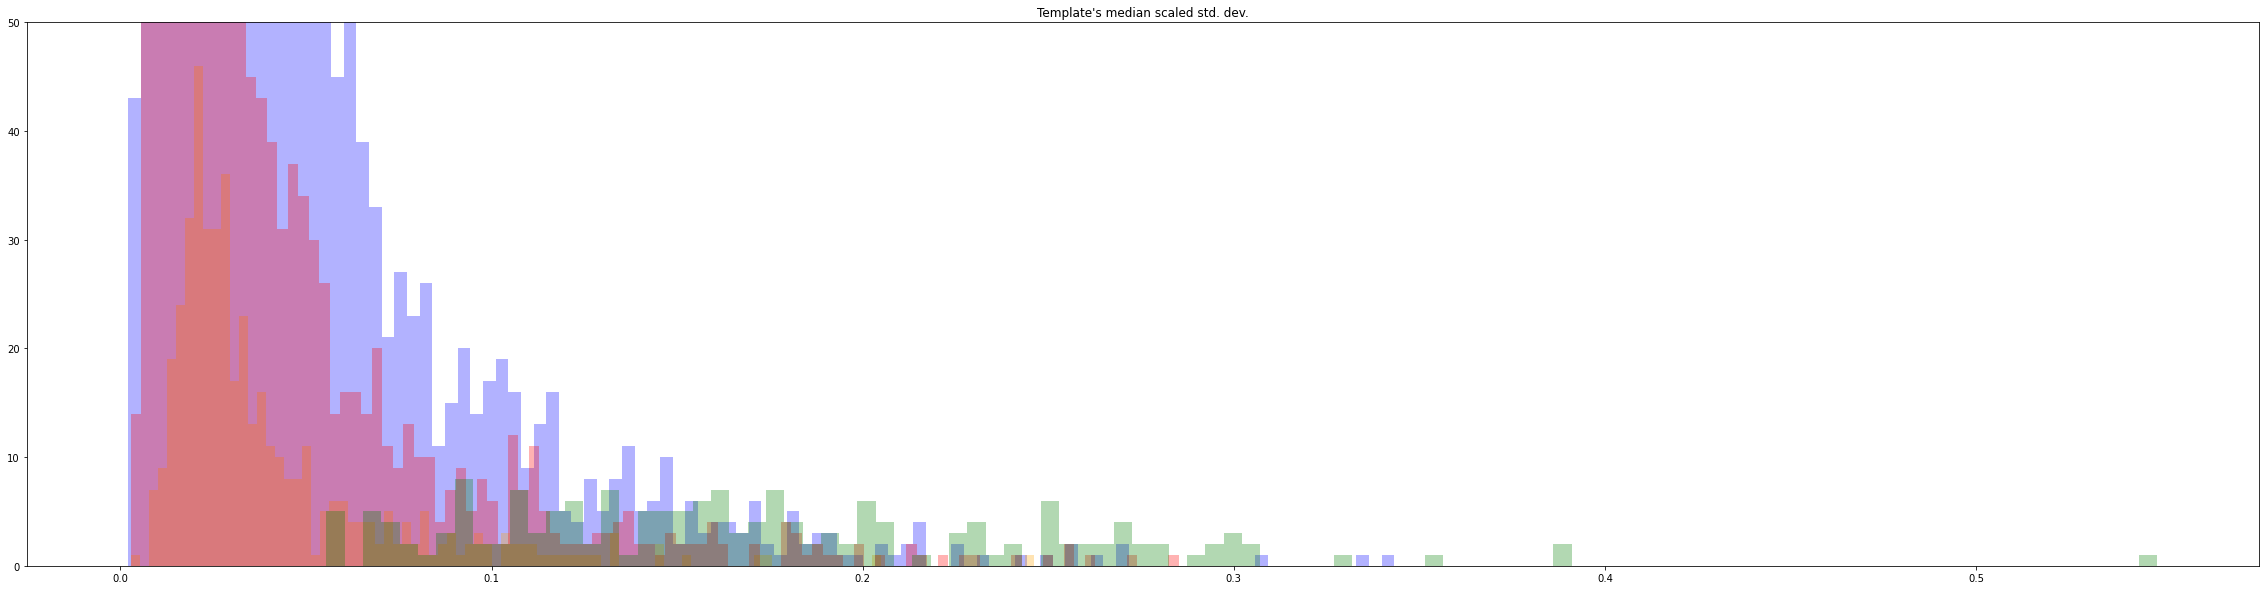

In [99]:
#df_templates_std_class0 = get_templates_std(df_ecg_class0, scale=None)
#df_templates_std_class1 = get_templates_std(df_ecg_class1, scale=None)
#df_templates_std_class2 = get_templates_std(df_ecg_class2, scale=None)
#df_templates_std_class3 = get_templates_std(df_ecg_class3, scale=None)

df_templates_std_scaled_median_class0 = np.median(df_templates_std_scaled_class0, axis=1)
df_templates_std_scaled_median_class1 = np.median(df_templates_std_scaled_class1, axis=1)
df_templates_std_scaled_median_class2 = np.median(df_templates_std_scaled_class2, axis=1)
df_templates_std_scaled_median_class3 = np.median(df_templates_std_scaled_class3, axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_std_scaled_median_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_std_scaled_median_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_std_scaled_median_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_std_scaled_median_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's median scaled std. dev.")
plt.show()

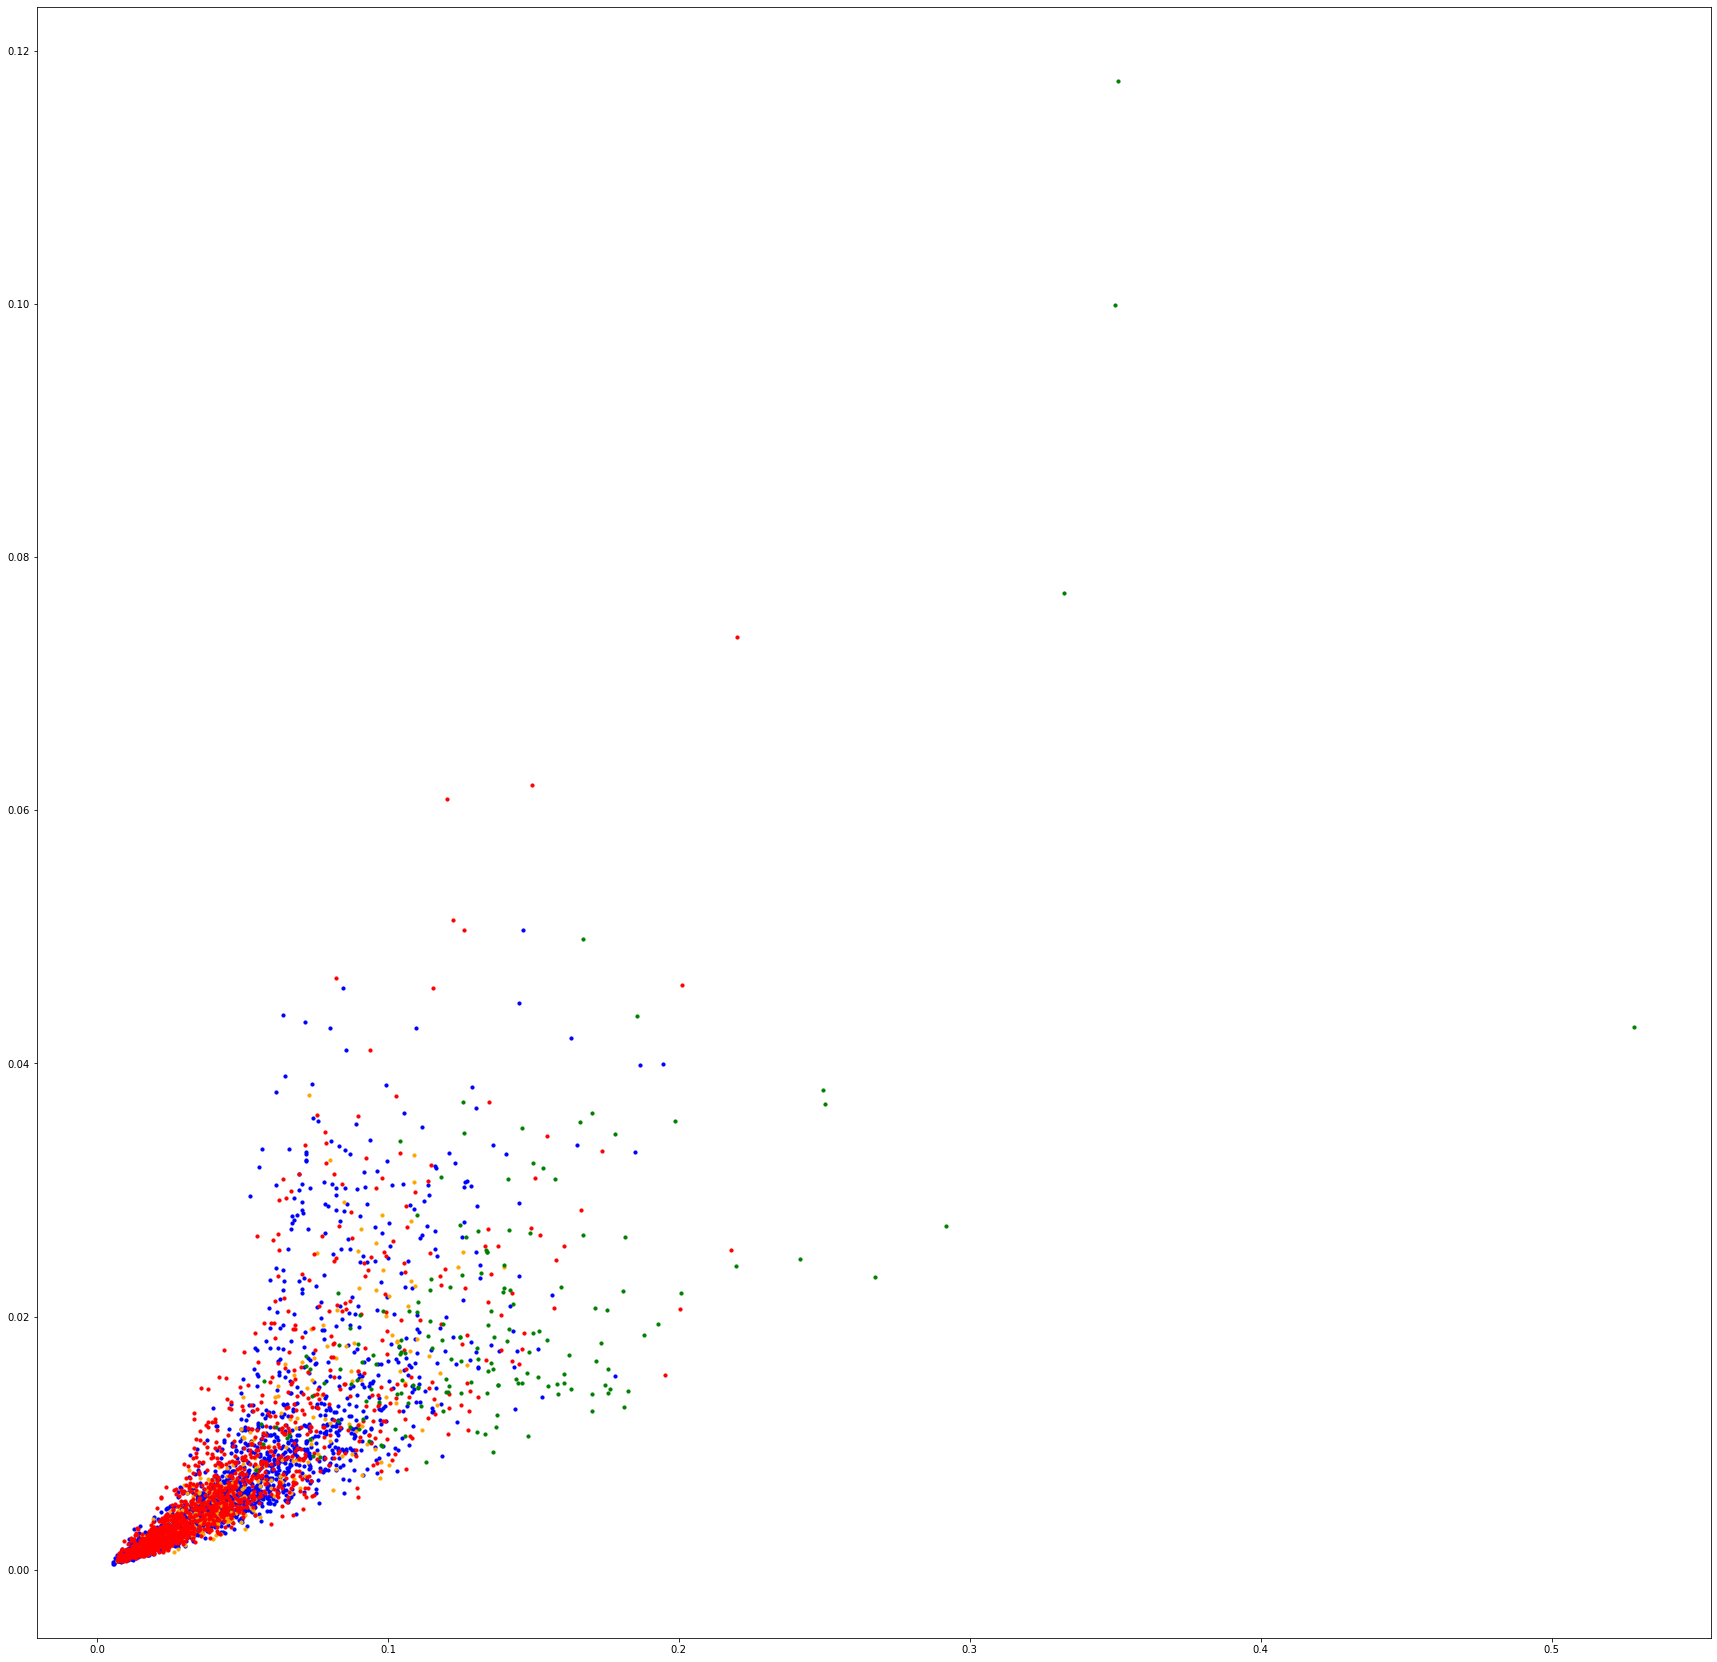

In [55]:
plt.figure(figsize=(30,30))
plt.scatter(df_templates_std_mean_class0, df_templates_mean_median_diff_abs_mean_class0, s=10, color="b")
plt.scatter(df_templates_std_mean_class1, df_templates_mean_median_diff_abs_mean_class1, s=10, color="orange")
plt.scatter(df_templates_std_mean_class2, df_templates_mean_median_diff_abs_mean_class2, s=10, color="r")
plt.scatter(df_templates_std_mean_class3, df_templates_mean_median_diff_abs_mean_class3, s=10, color="g")
plt.show()

# If we dont scale raw signals

In [ ]:
df_ecg_unscaled = process_df_ecg(X_train, scaler=None)

X_train_class0 = X_train.loc[y_train.values==0, :]
X_train_class1 = X_train.loc[y_train.values==1, :]
X_train_class2 = X_train.loc[y_train.values==2, :]
X_train_class3 = X_train.loc[y_train.values==3, :]

ind_class0 = list(np.where(y_train.values.flatten() == 0)[0])
ind_class1 = list(np.where(y_train.values.flatten() == 1)[0])
ind_class2 = list(np.where(y_train.values.flatten() == 2)[0])
ind_class3 = list(np.where(y_train.values.flatten() == 3)[0])

df_ecg_class0_unscaled = [df_ecg[ind] for ind in ind_class0]
df_ecg_class1_unscaled = [df_ecg[ind] for ind in ind_class1]
df_ecg_class2_unscaled = [df_ecg[ind] for ind in ind_class2]
df_ecg_class3_unscaled = [df_ecg[ind] for ind in ind_class3]

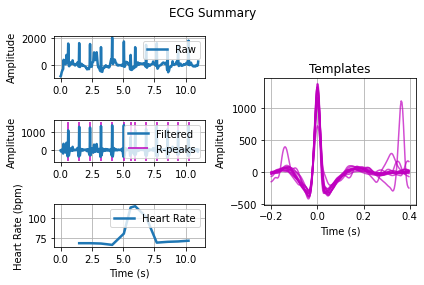

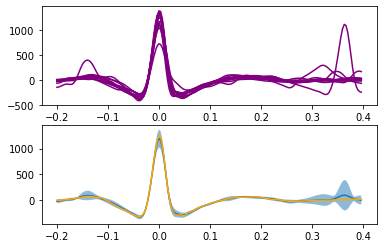

Average standard deviation: 58.787681503535474 (50.230616884978204)


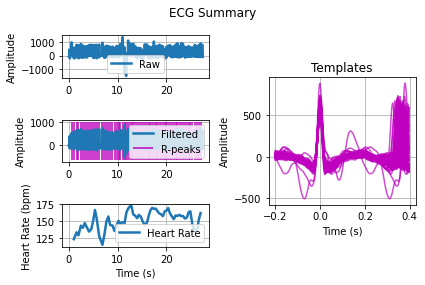

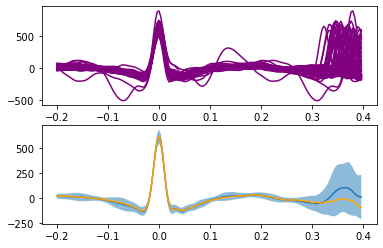

Average standard deviation: 63.27225229601538 (63.69361540964103)


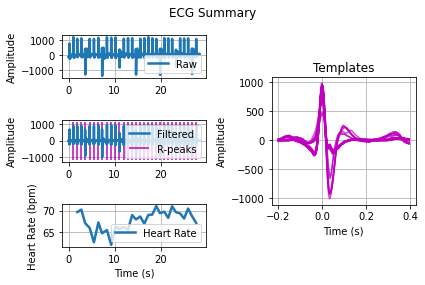

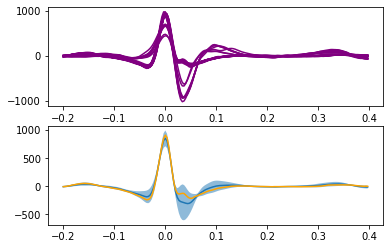

Average standard deviation: 48.68262054535786 (56.84790935375612)


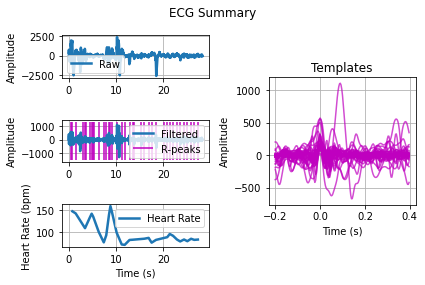

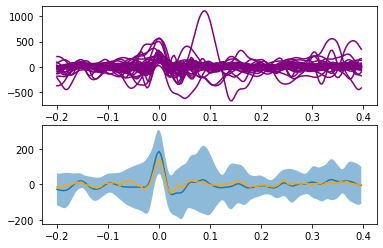

Average standard deviation: 97.21243928075351 (35.69367378877652)


In [38]:
ecg_out_class0 = process_ecg(X_train_class0.iloc[0, :], scaler=None)
ecg_out_class1 = process_ecg(X_train_class1.iloc[0, :], scaler=None)
ecg_out_class2 = process_ecg(X_train_class2.iloc[0, :], scaler=None)
ecg_out_class3 = process_ecg(X_train_class3.iloc[0, :], scaler=None)

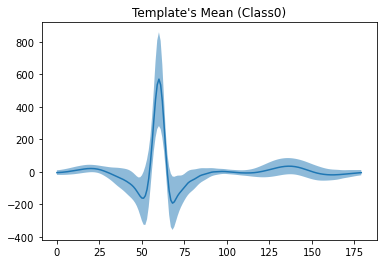

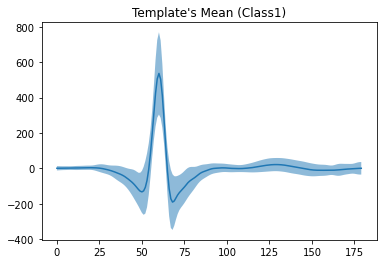

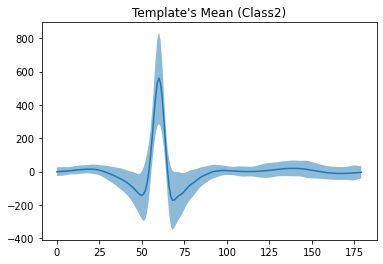

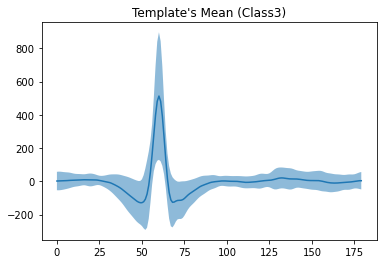

In [80]:
df_templates_mean_class0 = get_templates_mean(df_ecg_class0)
df_templates_mean_class1 = get_templates_mean(df_ecg_class1)
df_templates_mean_class2 = get_templates_mean(df_ecg_class2)
df_templates_mean_class3 = get_templates_mean(df_ecg_class3)
plot_mean(df_templates_mean_class0, title="Template's Mean (Class0)")
plot_mean(df_templates_mean_class1, title="Template's Mean (Class1)")
plot_mean(df_templates_mean_class2, title="Template's Mean (Class2)")
plot_mean(df_templates_mean_class3, title="Template's Mean (Class3)")

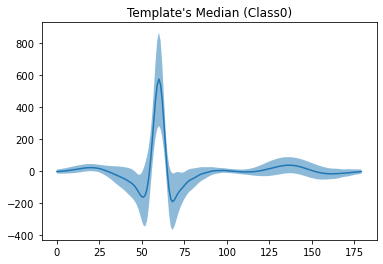

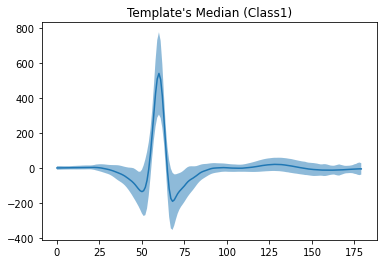

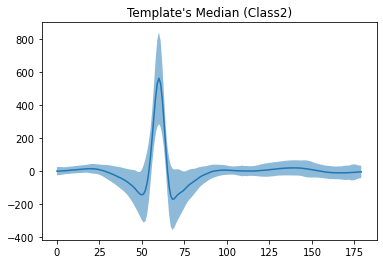

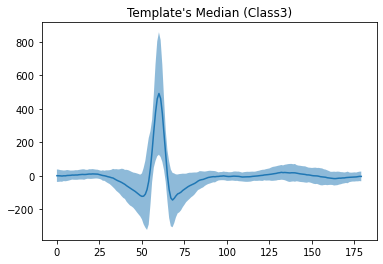

In [81]:
df_templates_median_class0 = get_templates_median(df_ecg_class0)
df_templates_median_class1 = get_templates_median(df_ecg_class1)
df_templates_median_class2 = get_templates_median(df_ecg_class2)
df_templates_median_class3 = get_templates_median(df_ecg_class3)
plot_mean(df_templates_median_class0, title="Template's Median (Class0)")
plot_mean(df_templates_median_class1, title="Template's Median (Class1)")
plot_mean(df_templates_median_class2, title="Template's Median (Class2)")
plot_mean(df_templates_median_class3, title="Template's Median (Class3)")

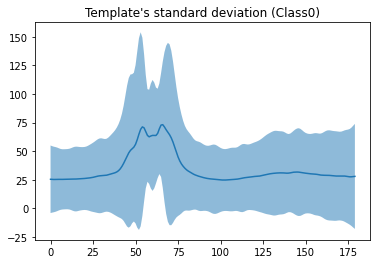

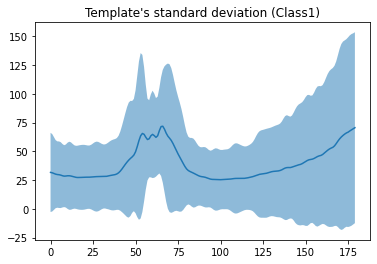

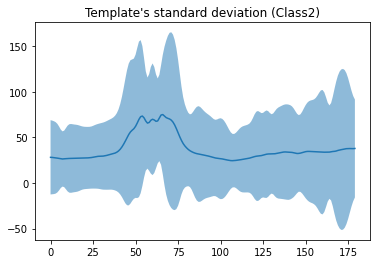

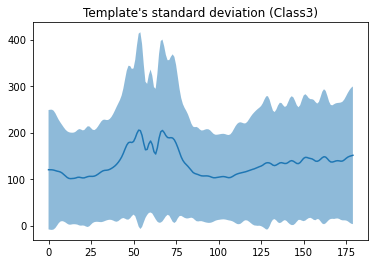

In [82]:
df_templates_std_class0 = get_templates_std(df_ecg_class0, scale=None)
df_templates_std_class1 = get_templates_std(df_ecg_class1, scale=None)
df_templates_std_class2 = get_templates_std(df_ecg_class2, scale=None)
df_templates_std_class3 = get_templates_std(df_ecg_class3, scale=None)
plot_mean(df_templates_std_class0, title="Template's standard deviation (Class0)")
plot_mean(df_templates_std_class1, title="Template's standard deviation (Class1)")
plot_mean(df_templates_std_class2, title="Template's standard deviation (Class2)")
plot_mean(df_templates_std_class3, title="Template's standard deviation (Class3)")

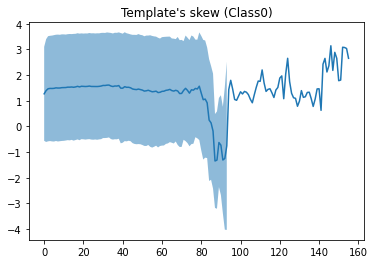

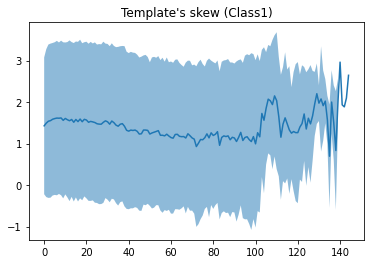

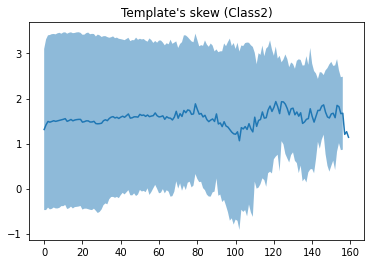

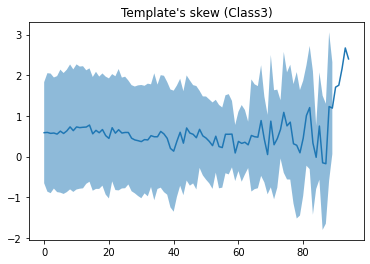

In [83]:
df_templates_skew_class0 = get_templates_skew(df_ecg_class0)
df_templates_skew_class1 = get_templates_skew(df_ecg_class1)
df_templates_skew_class2 = get_templates_skew(df_ecg_class2)
df_templates_skew_class3 = get_templates_skew(df_ecg_class3)
plot_mean(df_templates_skew_class0, title="Template's skew (Class0)")
plot_mean(df_templates_skew_class1, title="Template's skew (Class1)")
plot_mean(df_templates_skew_class2, title="Template's skew (Class2)")
plot_mean(df_templates_skew_class3, title="Template's skew (Class3)")

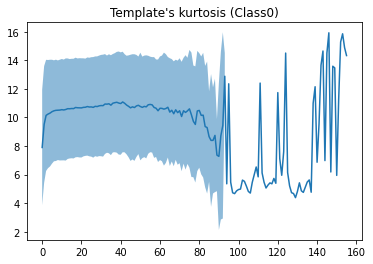

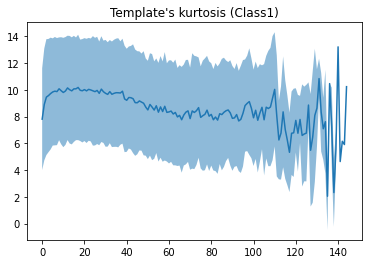

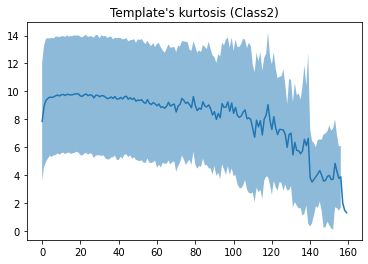

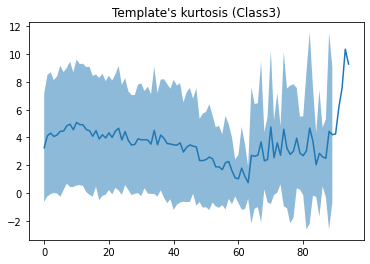

In [84]:
df_templates_kurtosis_class0 = get_templates_kurtosis(df_ecg_class0)
df_templates_kurtosis_class1 = get_templates_kurtosis(df_ecg_class1)
df_templates_kurtosis_class2 = get_templates_kurtosis(df_ecg_class2)
df_templates_kurtosis_class3 = get_templates_kurtosis(df_ecg_class3)
plot_mean(df_templates_kurtosis_class0, title="Template's kurtosis (Class0)")
plot_mean(df_templates_kurtosis_class1, title="Template's kurtosis (Class1)")
plot_mean(df_templates_kurtosis_class2, title="Template's kurtosis (Class2)")
plot_mean(df_templates_kurtosis_class3, title="Template's kurtosis (Class3)")

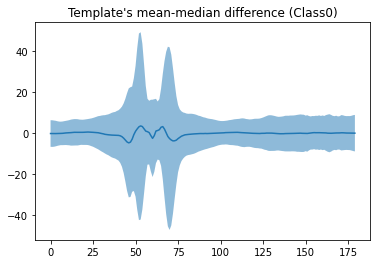

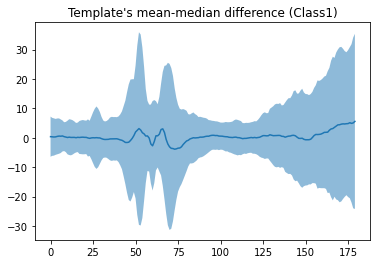

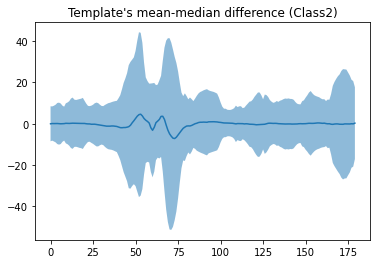

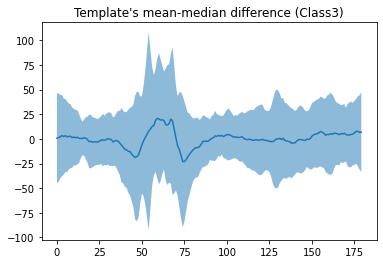

In [85]:
df_templates_mean_median_diff_class0, df_templates_mean_median_diff_abs_class0 = get_templates_mean_median_diff(df_ecg_class0, scale=None)
df_templates_mean_median_diff_class1, df_templates_mean_median_diff_abs_class1 = get_templates_mean_median_diff(df_ecg_class1, scale=None)
df_templates_mean_median_diff_class2, df_templates_mean_median_diff_abs_class2 = get_templates_mean_median_diff(df_ecg_class2, scale=None)
df_templates_mean_median_diff_class3, df_templates_mean_median_diff_abs_class3 = get_templates_mean_median_diff(df_ecg_class3, scale=None)
plot_mean(df_templates_mean_median_diff_class0, title="Template's mean-median difference (Class0)")
plot_mean(df_templates_mean_median_diff_class1, title="Template's mean-median difference (Class1)")
plot_mean(df_templates_mean_median_diff_class2, title="Template's mean-median difference (Class2)")
plot_mean(df_templates_mean_median_diff_class3, title="Template's mean-median difference (Class3)")

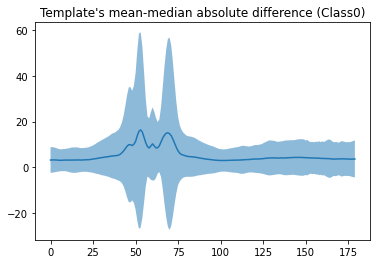

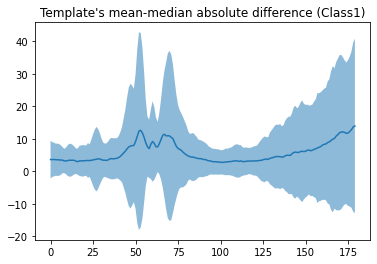

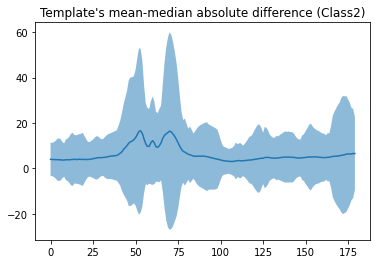

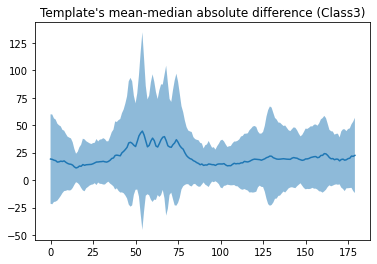

In [86]:
plot_mean(df_templates_mean_median_diff_abs_class0, title="Template's mean-median absolute difference (Class0)")
plot_mean(df_templates_mean_median_diff_abs_class1, title="Template's mean-median absolute difference (Class1)")
plot_mean(df_templates_mean_median_diff_abs_class2, title="Template's mean-median absolute difference (Class2)")
plot_mean(df_templates_mean_median_diff_abs_class3, title="Template's mean-median absolute difference (Class3)")

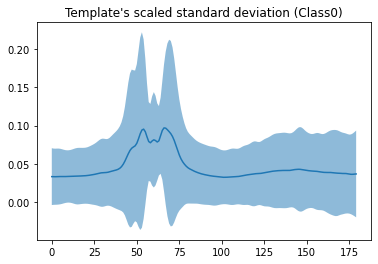

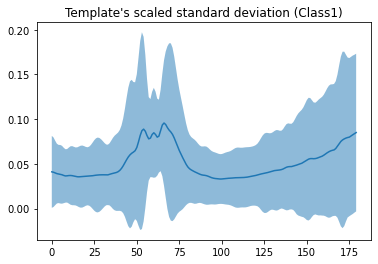

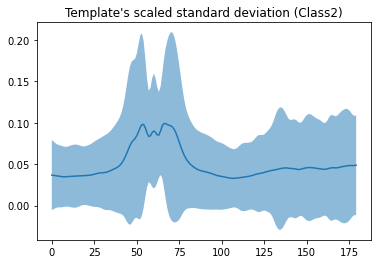

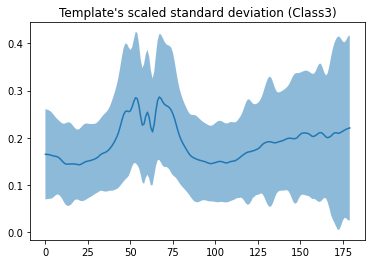

In [87]:
df_templates_std_scaled_class0 = get_templates_std(df_ecg_class0, scale="minmax")
df_templates_std_scaled_class1 = get_templates_std(df_ecg_class1, scale="minmax")
df_templates_std_scaled_class2 = get_templates_std(df_ecg_class2, scale="minmax")
df_templates_std_scaled_class3 = get_templates_std(df_ecg_class3, scale="minmax")
plot_mean(df_templates_std_scaled_class0, title="Template's scaled standard deviation (Class0)")
plot_mean(df_templates_std_scaled_class1, title="Template's scaled standard deviation (Class1)")
plot_mean(df_templates_std_scaled_class2, title="Template's scaled standard deviation (Class2)")
plot_mean(df_templates_std_scaled_class3, title="Template's scaled standard deviation (Class3)")

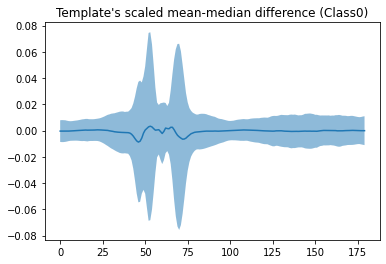

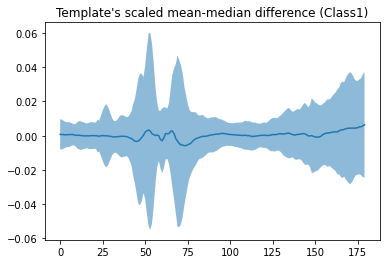

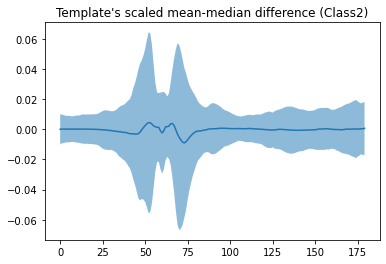

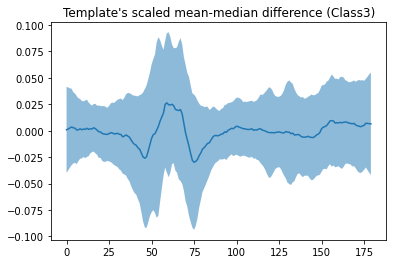

In [88]:
# Doesn't make sense to scale minmax here because all already have same scale due to minmax scaling of signals
df_templates_mean_median_diff_scaled_class0, df_templates_mean_median_diff_scaled_abs_class0 = get_templates_mean_median_diff(df_ecg_class0, scale="minmax")
df_templates_mean_median_diff_scaled_class1, df_templates_mean_median_diff_scaled_abs_class1 = get_templates_mean_median_diff(df_ecg_class1, scale="minmax")
df_templates_mean_median_diff_scaled_class2, df_templates_mean_median_diff_scaled_abs_class2 = get_templates_mean_median_diff(df_ecg_class2, scale="minmax")
df_templates_mean_median_diff_scaled_class3, df_templates_mean_median_diff_scaled_abs_class3 = get_templates_mean_median_diff(df_ecg_class3, scale="minmax")
plot_mean(df_templates_mean_median_diff_scaled_class0, title="Template's scaled mean-median difference (Class0)")
plot_mean(df_templates_mean_median_diff_scaled_class1, title="Template's scaled mean-median difference (Class1)")
plot_mean(df_templates_mean_median_diff_scaled_class2, title="Template's scaled mean-median difference (Class2)")
plot_mean(df_templates_mean_median_diff_scaled_class3, title="Template's scaled mean-median difference (Class3)")

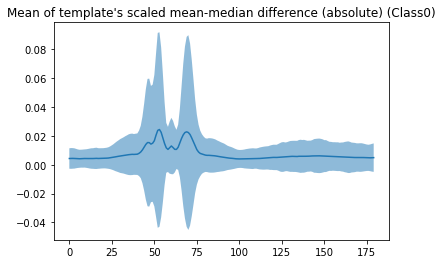

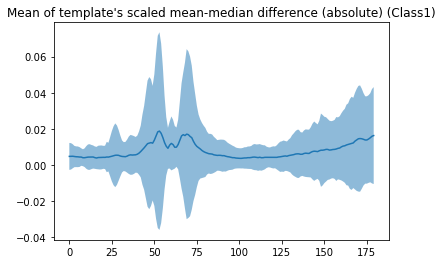

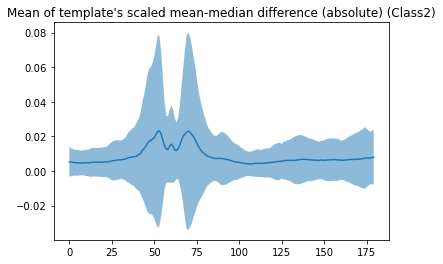

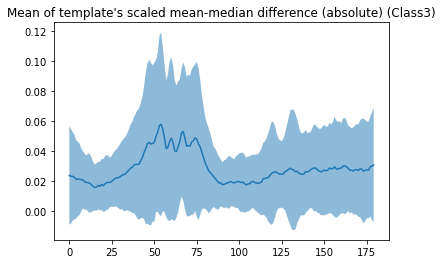

In [89]:
# Doesn't make sense to scale minmax here because all already have same scale due to minmax scaling of signals
plot_mean(df_templates_mean_median_diff_scaled_abs_class0, title="Mean of template's scaled mean-median difference (absolute) (Class0)")
plot_mean(df_templates_mean_median_diff_scaled_abs_class1, title="Mean of template's scaled mean-median difference (absolute) (Class1)")
plot_mean(df_templates_mean_median_diff_scaled_abs_class2, title="Mean of template's scaled mean-median difference (absolute) (Class2)")
plot_mean(df_templates_mean_median_diff_scaled_abs_class3, title="Mean of template's scaled mean-median difference (absolute) (Class3)")

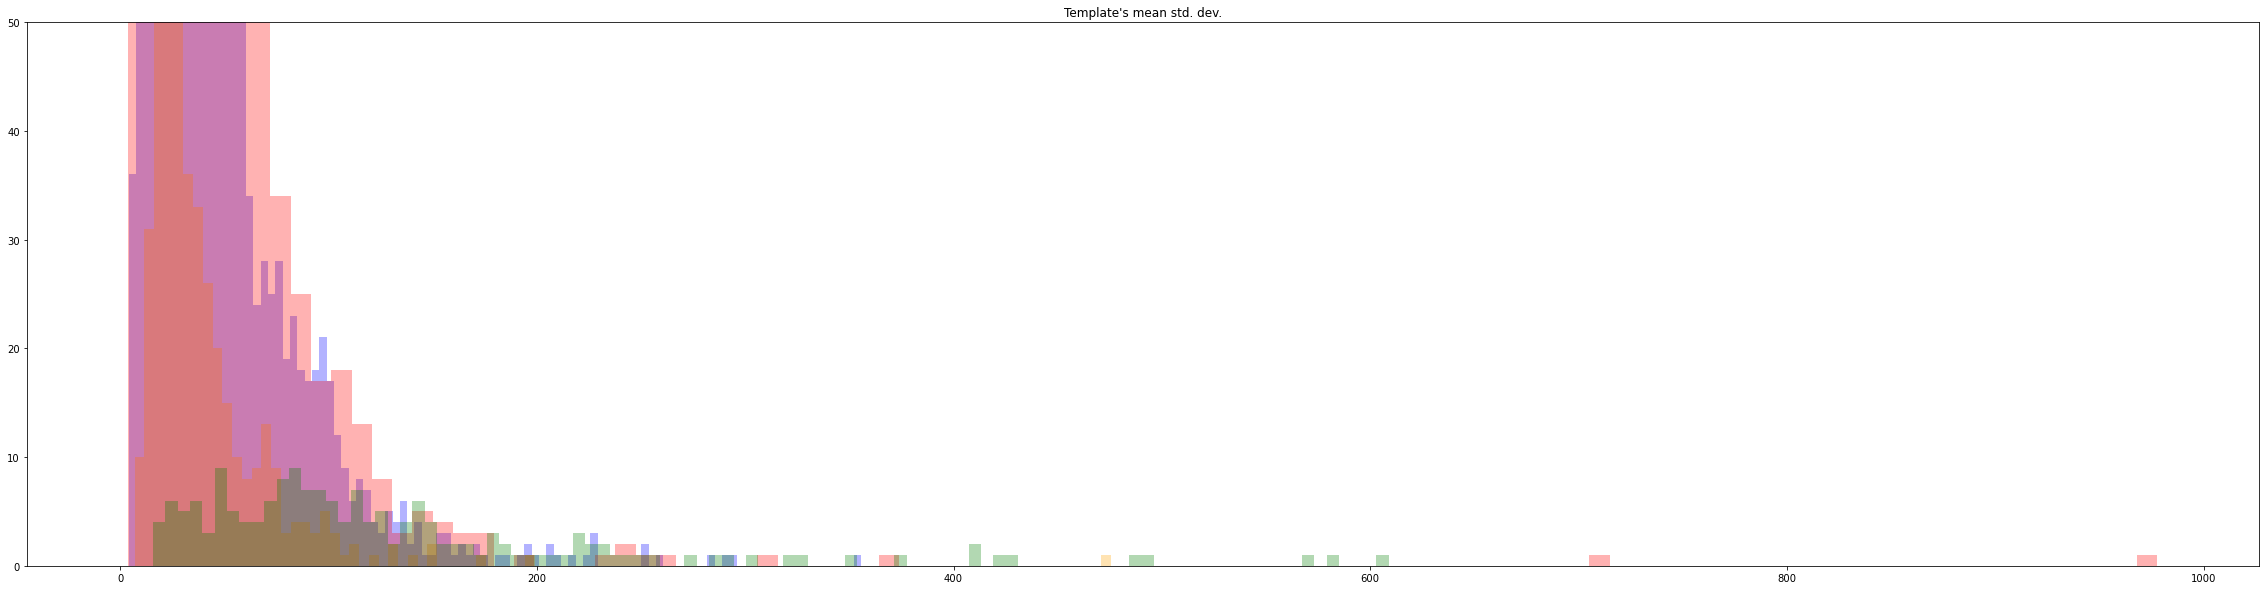

In [111]:
#df_templates_std_class0 = get_templates_std(df_ecg_class0, scale=None)
#df_templates_std_class1 = get_templates_std(df_ecg_class1, scale=None)
#df_templates_std_class2 = get_templates_std(df_ecg_class2, scale=None)
#df_templates_std_class3 = get_templates_std(df_ecg_class3, scale=None)

df_templates_std_mean_class0 = df_templates_std_class0.mean(axis=1)
df_templates_std_mean_class1 = df_templates_std_class1.mean(axis=1)
df_templates_std_mean_class2 = df_templates_std_class2.mean(axis=1)
df_templates_std_mean_class3 = df_templates_std_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_std_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_std_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_std_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_std_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's mean std. dev.")
plt.show()

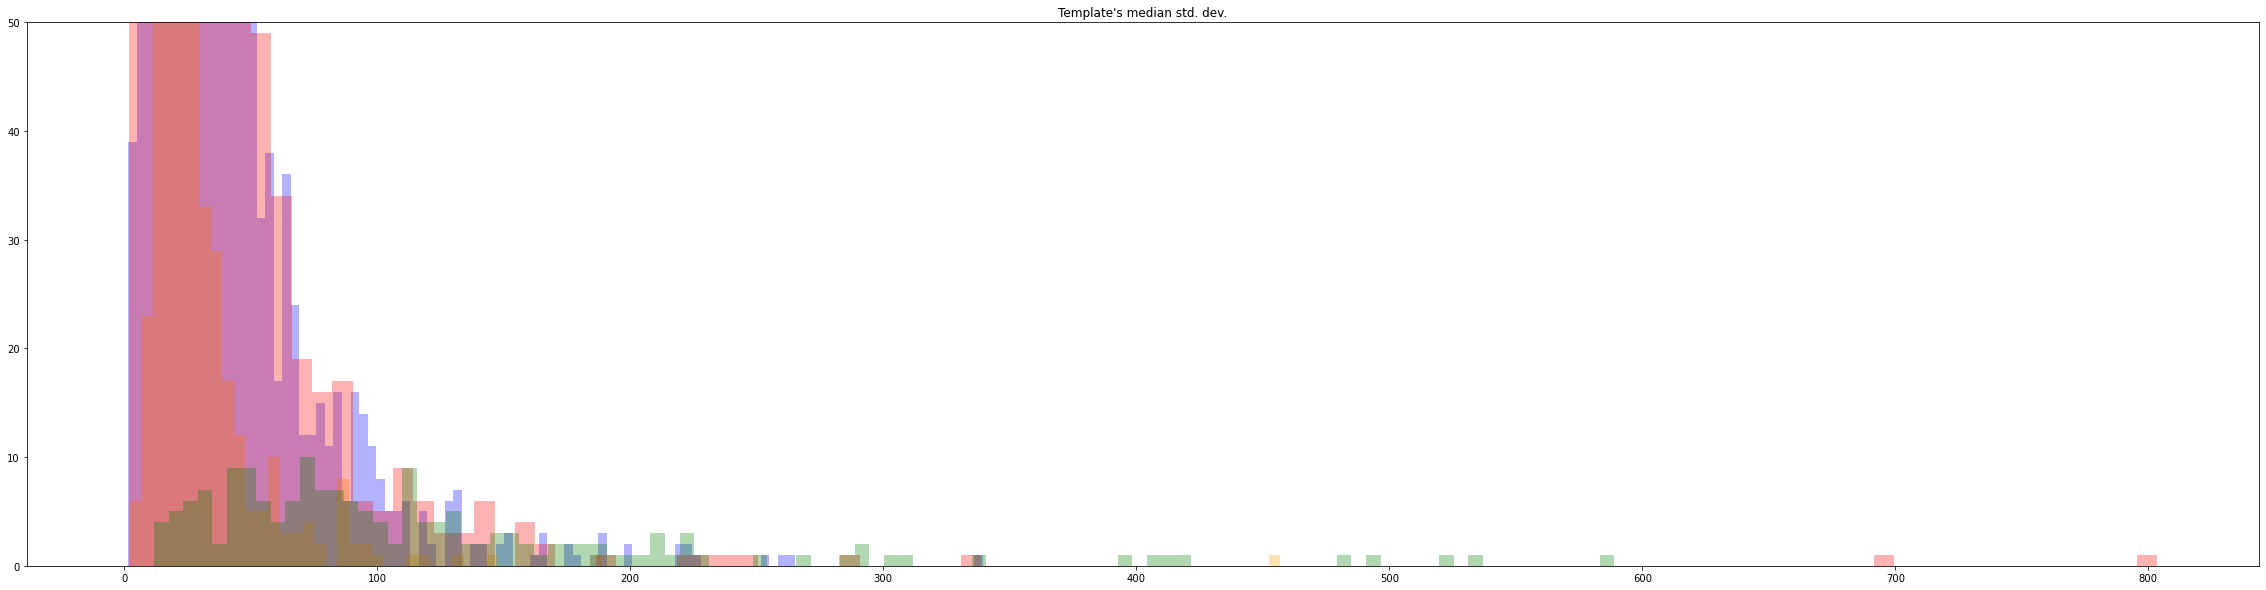

In [126]:
df_templates_std_median_class0 = df_templates_std_class0.median(axis=1)
df_templates_std_median_class1 = df_templates_std_class1.median(axis=1)
df_templates_std_median_class2 = df_templates_std_class2.median(axis=1)
df_templates_std_median_class3 = df_templates_std_class3.median(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_std_median_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_std_median_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_std_median_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_std_median_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's median std. dev.")
plt.show()

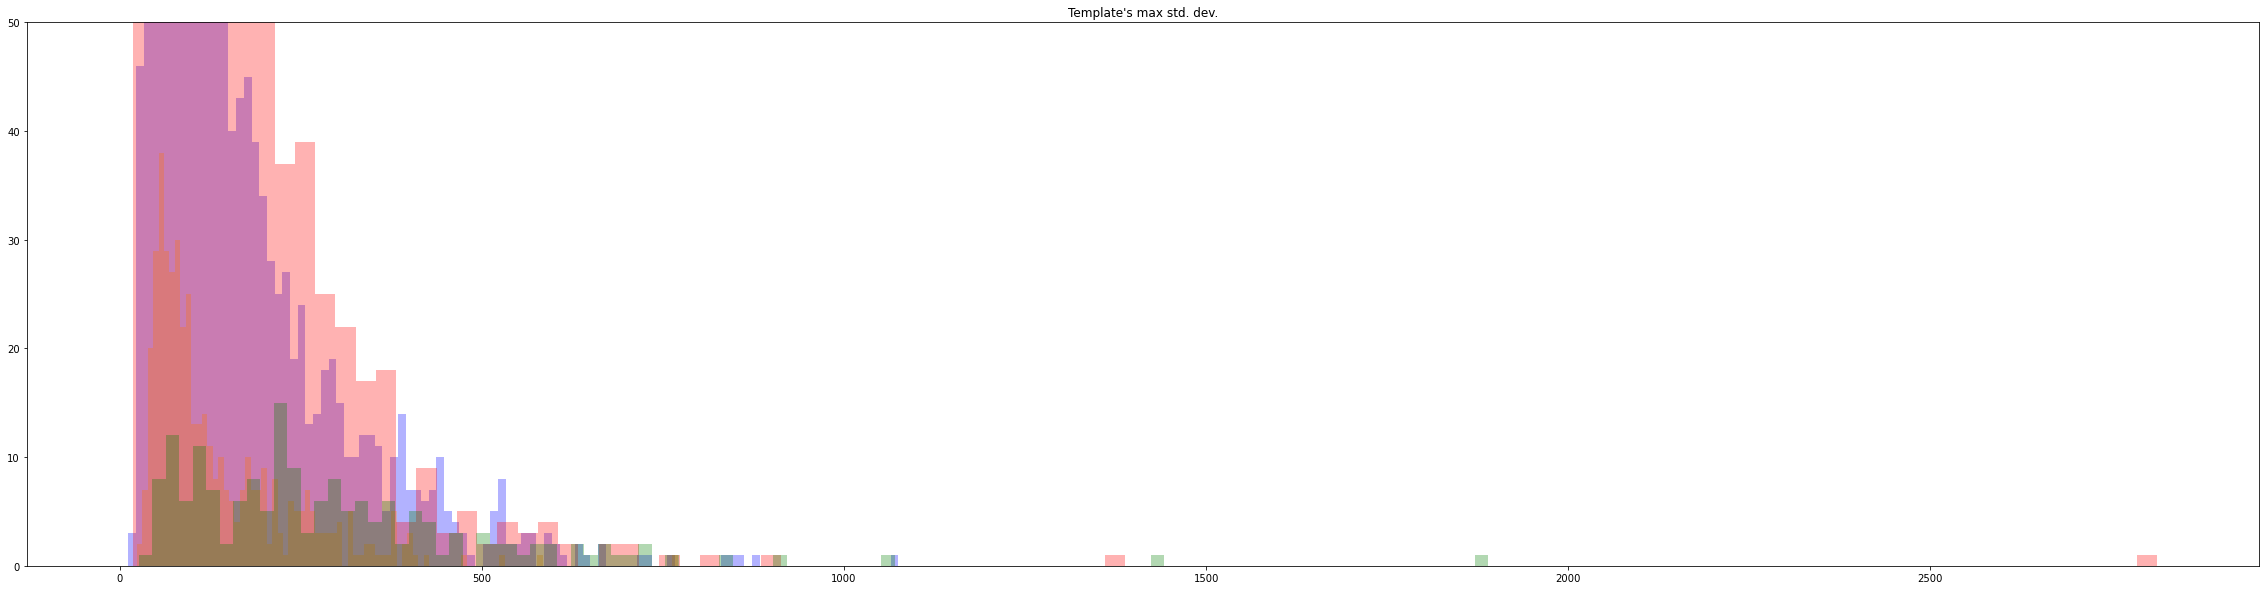

In [112]:
df_templates_std_max_class0 = df_templates_std_class0.max(axis=1)
df_templates_std_max_class1 = df_templates_std_class1.max(axis=1)
df_templates_std_max_class2 = df_templates_std_class2.max(axis=1)
df_templates_std_max_class3 = df_templates_std_class3.max(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_std_max_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_std_max_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_std_max_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_std_max_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's max std. dev.")
plt.show()

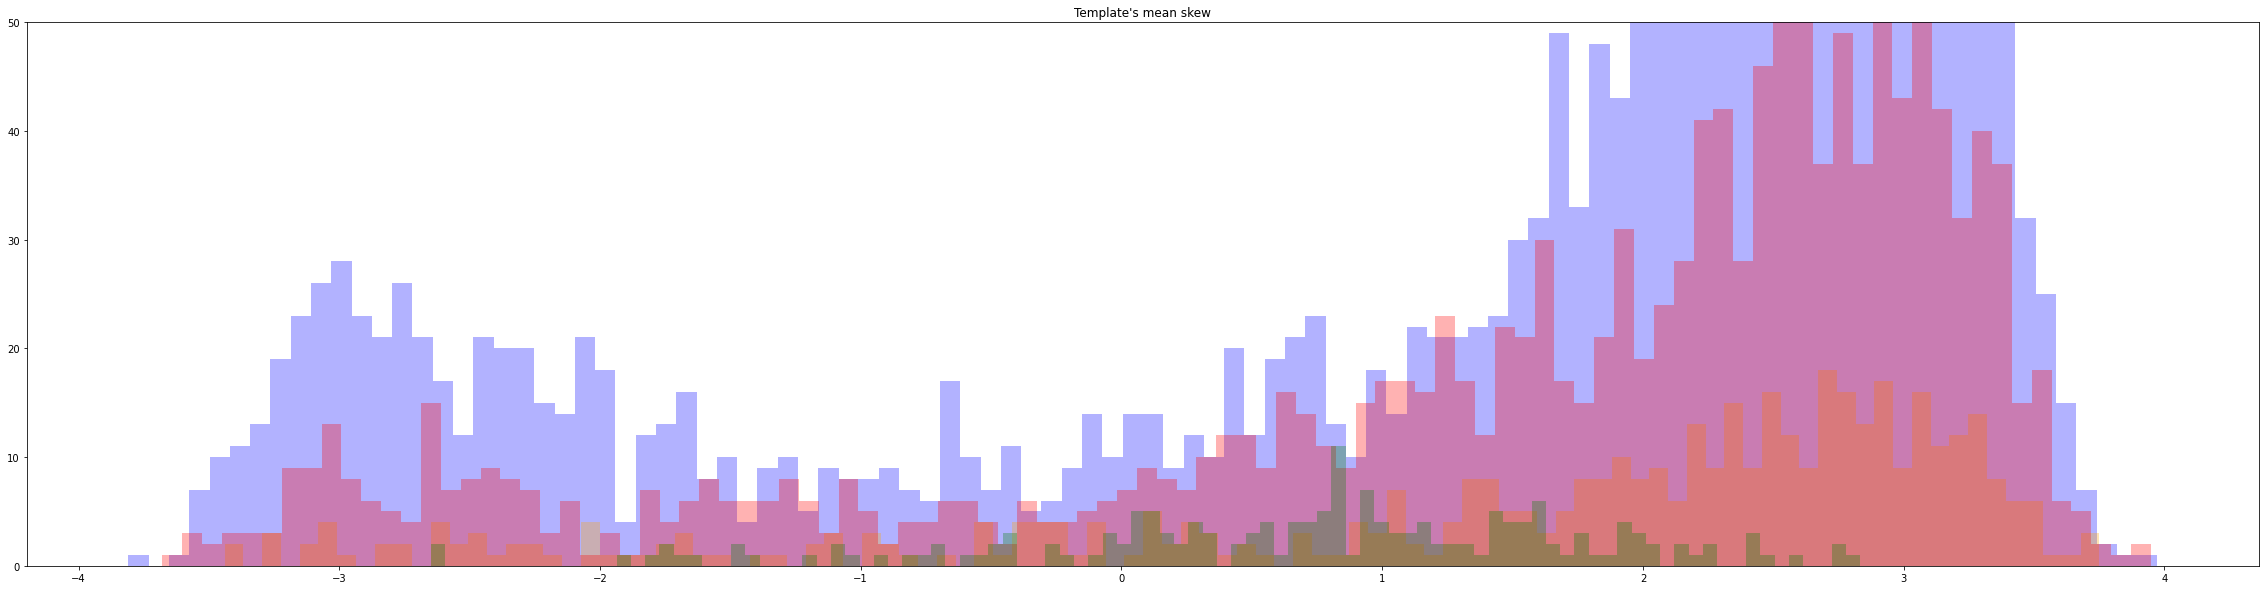

In [113]:
df_templates_skew_mean_class0 = df_templates_skew_class0.mean(axis=1)
df_templates_skew_mean_class1 = df_templates_skew_class1.mean(axis=1)
df_templates_skew_mean_class2 = df_templates_skew_class2.mean(axis=1)
df_templates_skew_mean_class3 = df_templates_skew_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_skew_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_skew_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_skew_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_skew_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's mean skew")
plt.show()

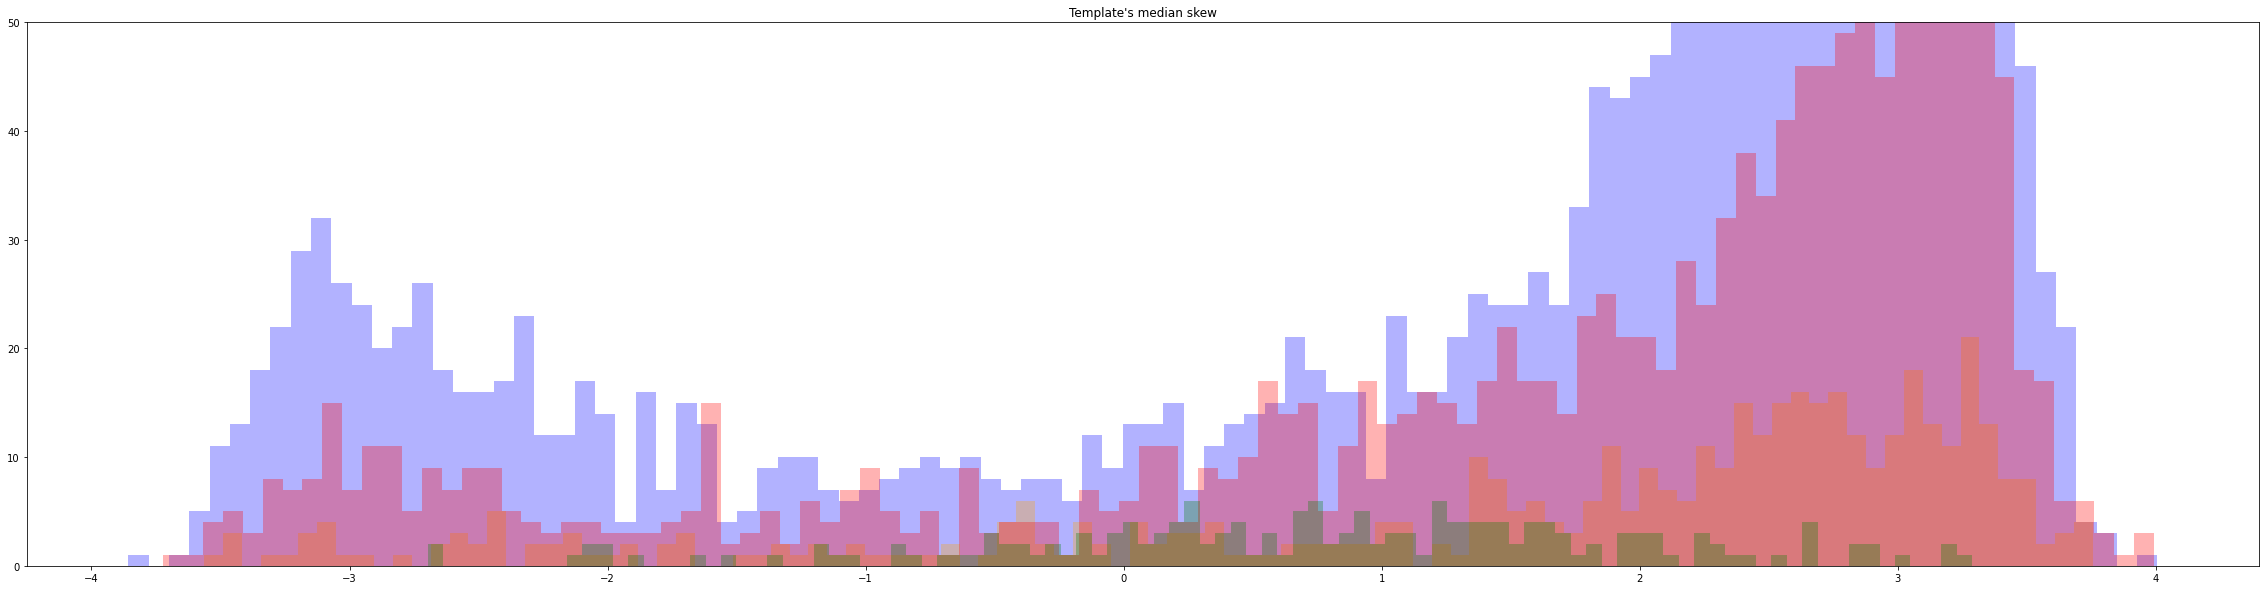

In [114]:
df_templates_skew_median_class0 = df_templates_skew_class0.median(axis=1)
df_templates_skew_median_class1 = df_templates_skew_class1.median(axis=1)
df_templates_skew_median_class2 = df_templates_skew_class2.median(axis=1)
df_templates_skew_median_class3 = df_templates_skew_class3.median(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_skew_median_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_skew_median_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_skew_median_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_skew_median_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's median skew")
plt.show()

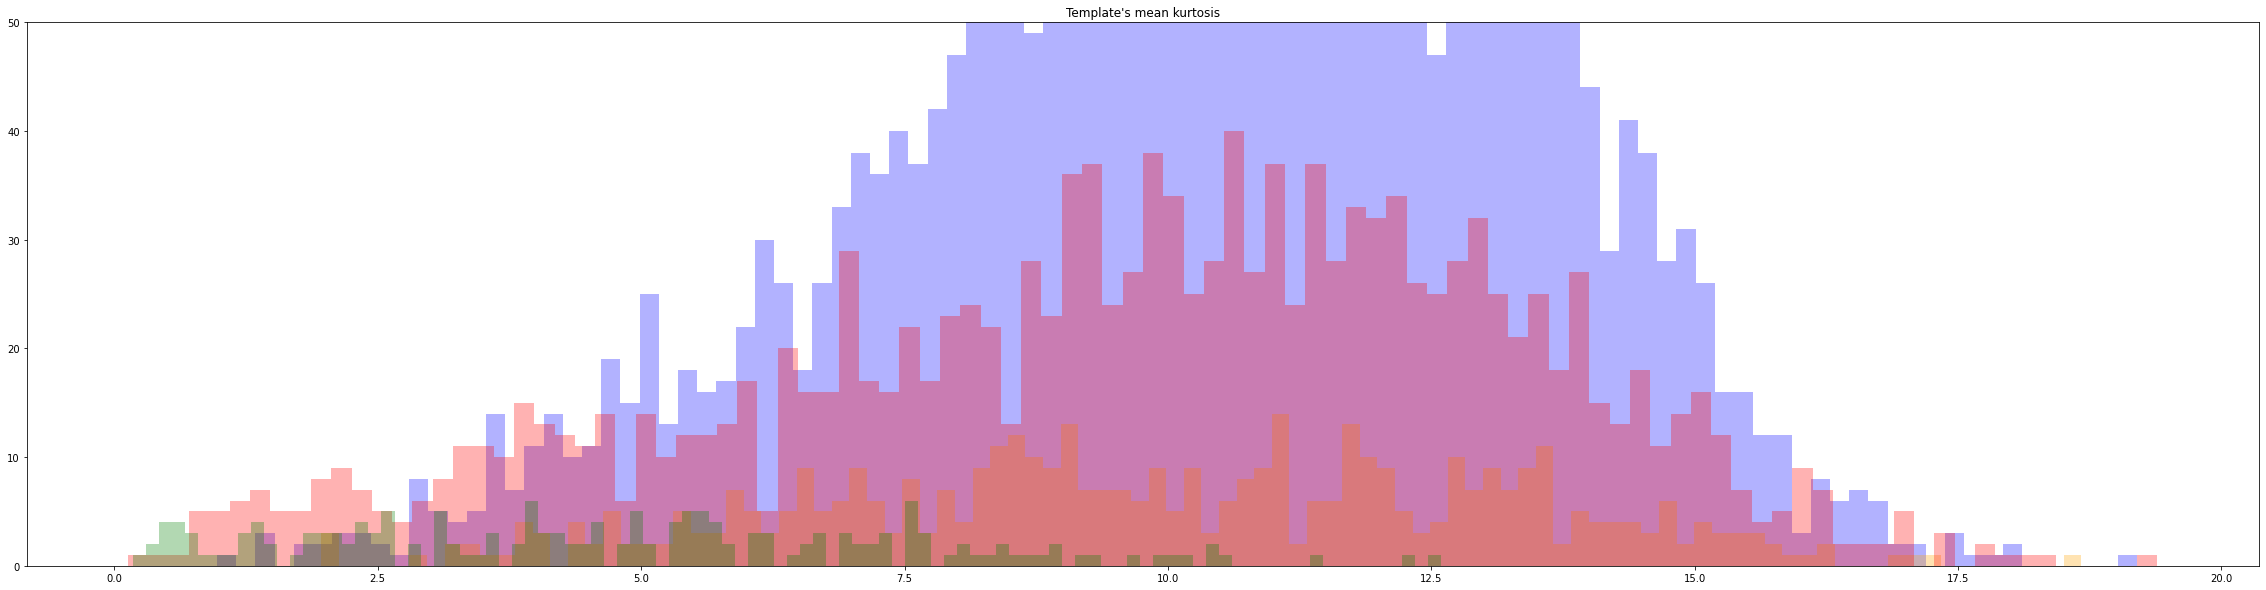

In [115]:
df_templates_kurtosis_mean_class0 = df_templates_kurtosis_class0.mean(axis=1)
df_templates_kurtosis_mean_class1 = df_templates_kurtosis_class1.mean(axis=1)
df_templates_kurtosis_mean_class2 = df_templates_kurtosis_class2.mean(axis=1)
df_templates_kurtosis_mean_class3 = df_templates_kurtosis_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_kurtosis_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_kurtosis_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_kurtosis_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_kurtosis_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's mean kurtosis")
plt.show()

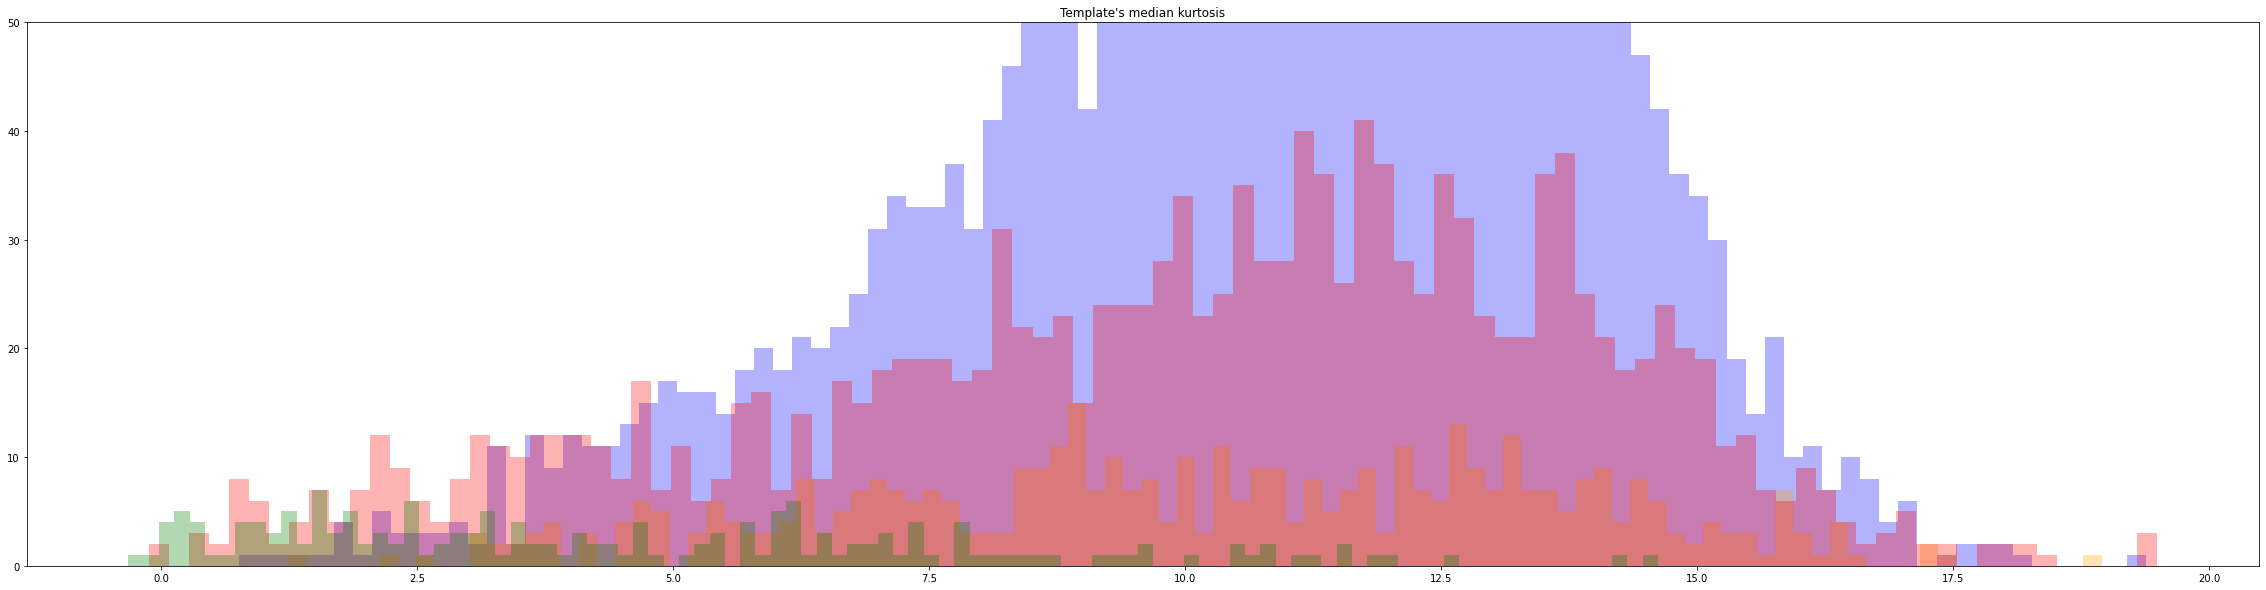

In [116]:
df_templates_kurtosis_median_class0 = df_templates_kurtosis_class0.median(axis=1)
df_templates_kurtosis_median_class1 = df_templates_kurtosis_class1.median(axis=1)
df_templates_kurtosis_median_class2 = df_templates_kurtosis_class2.median(axis=1)
df_templates_kurtosis_median_class3 = df_templates_kurtosis_class3.median(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_kurtosis_median_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_kurtosis_median_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_kurtosis_median_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_kurtosis_median_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's median kurtosis")
plt.show()

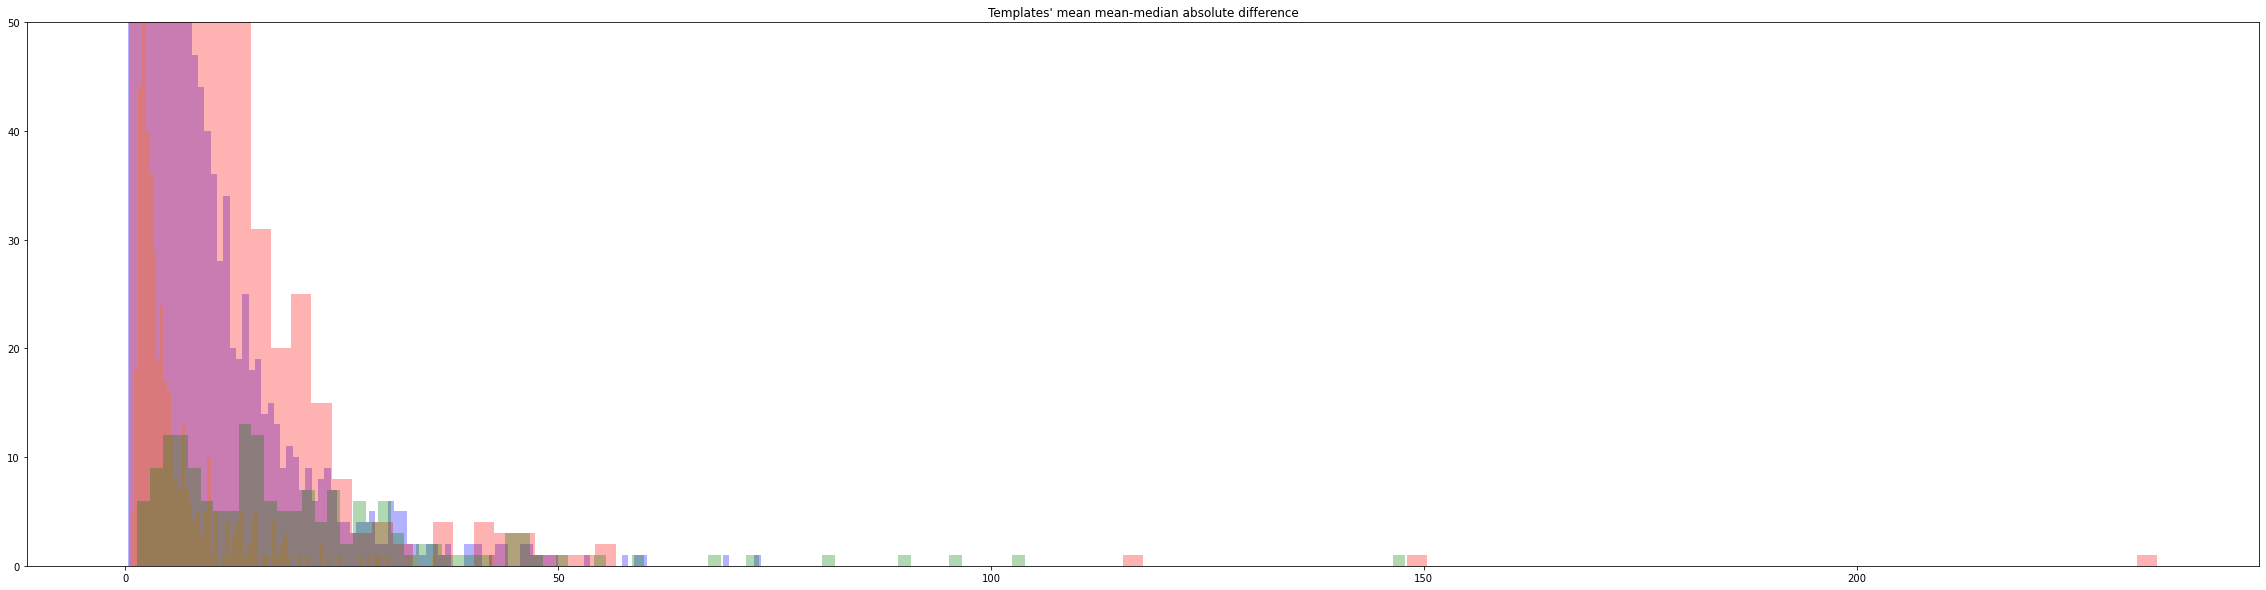

In [117]:
df_templates_mean_median_diff_class0, df_templates_mean_median_diff_abs_class0 = get_templates_mean_median_diff(df_ecg_class0, scale=None)
df_templates_mean_median_diff_class1, df_templates_mean_median_diff_abs_class1 = get_templates_mean_median_diff(df_ecg_class1, scale=None)
df_templates_mean_median_diff_class2, df_templates_mean_median_diff_abs_class2 = get_templates_mean_median_diff(df_ecg_class2, scale=None)
df_templates_mean_median_diff_class3, df_templates_mean_median_diff_abs_class3 = get_templates_mean_median_diff(df_ecg_class3, scale=None)

df_templates_mean_median_diff_abs_mean_class0 = df_templates_mean_median_diff_abs_class0.mean(axis=1)
df_templates_mean_median_diff_abs_mean_class1 = df_templates_mean_median_diff_abs_class1.mean(axis=1)
df_templates_mean_median_diff_abs_mean_class2 = df_templates_mean_median_diff_abs_class2.mean(axis=1)
df_templates_mean_median_diff_abs_mean_class3 = df_templates_mean_median_diff_abs_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_mean_median_diff_abs_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_mean_median_diff_abs_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_mean_median_diff_abs_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_mean_median_diff_abs_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Templates' mean mean-median absolute difference")
plt.show()

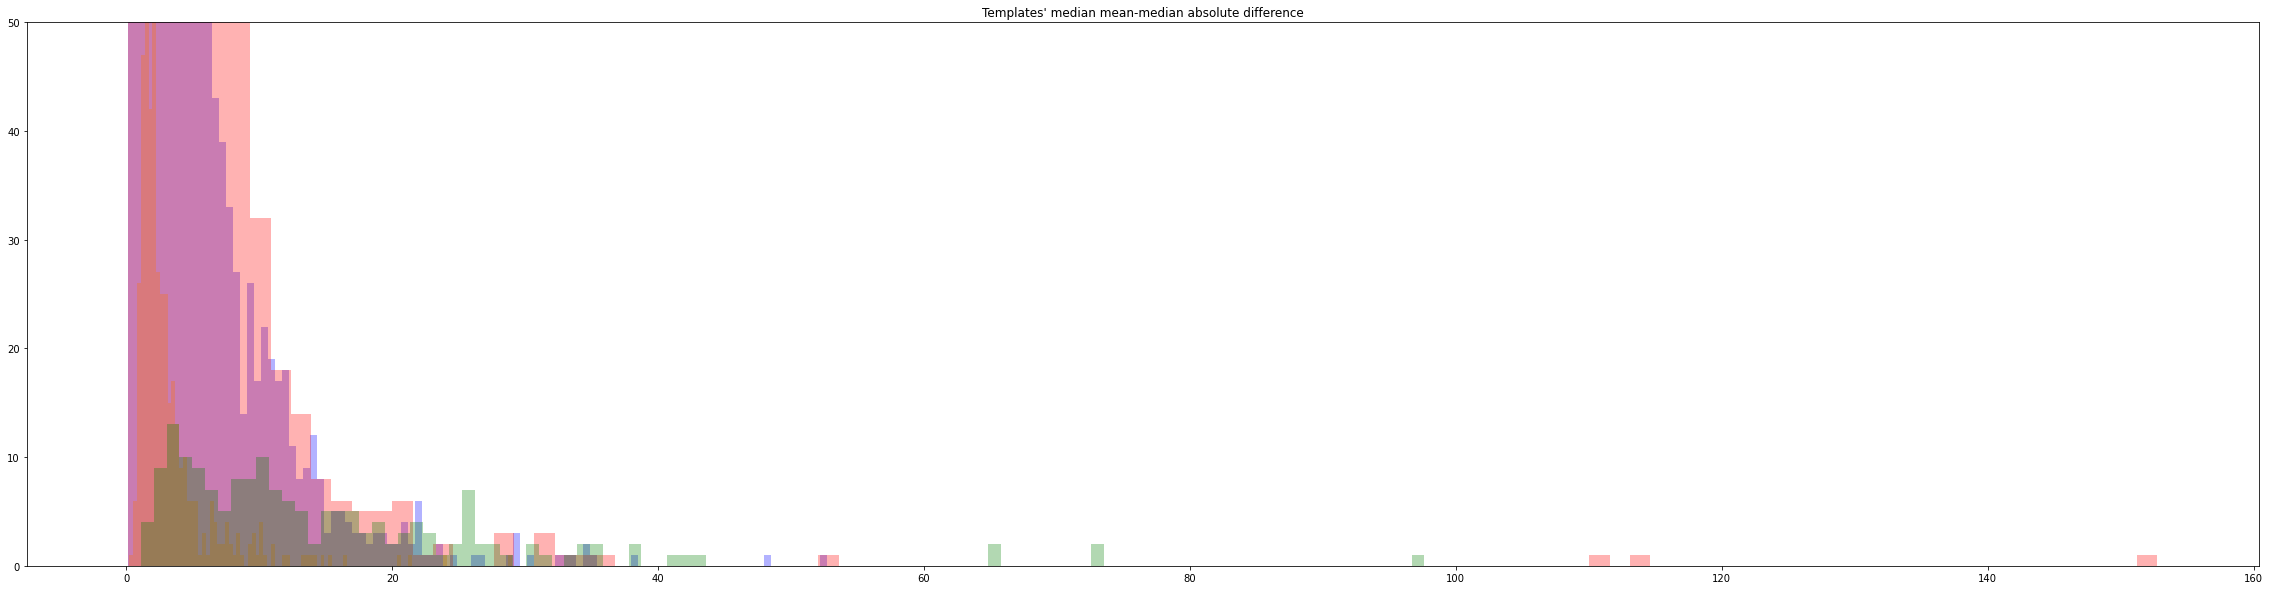

In [118]:
df_templates_mean_median_diff_abs_median_class0 = np.median(df_templates_mean_median_diff_abs_class0, axis=1)
df_templates_mean_median_diff_abs_median_class1 = np.median(df_templates_mean_median_diff_abs_class1, axis=1)
df_templates_mean_median_diff_abs_median_class2 = np.median(df_templates_mean_median_diff_abs_class2, axis=1)
df_templates_mean_median_diff_abs_median_class3 = np.median(df_templates_mean_median_diff_abs_class3, axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_mean_median_diff_abs_median_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_mean_median_diff_abs_median_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_mean_median_diff_abs_median_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_mean_median_diff_abs_median_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Templates' median mean-median absolute difference")
plt.show()

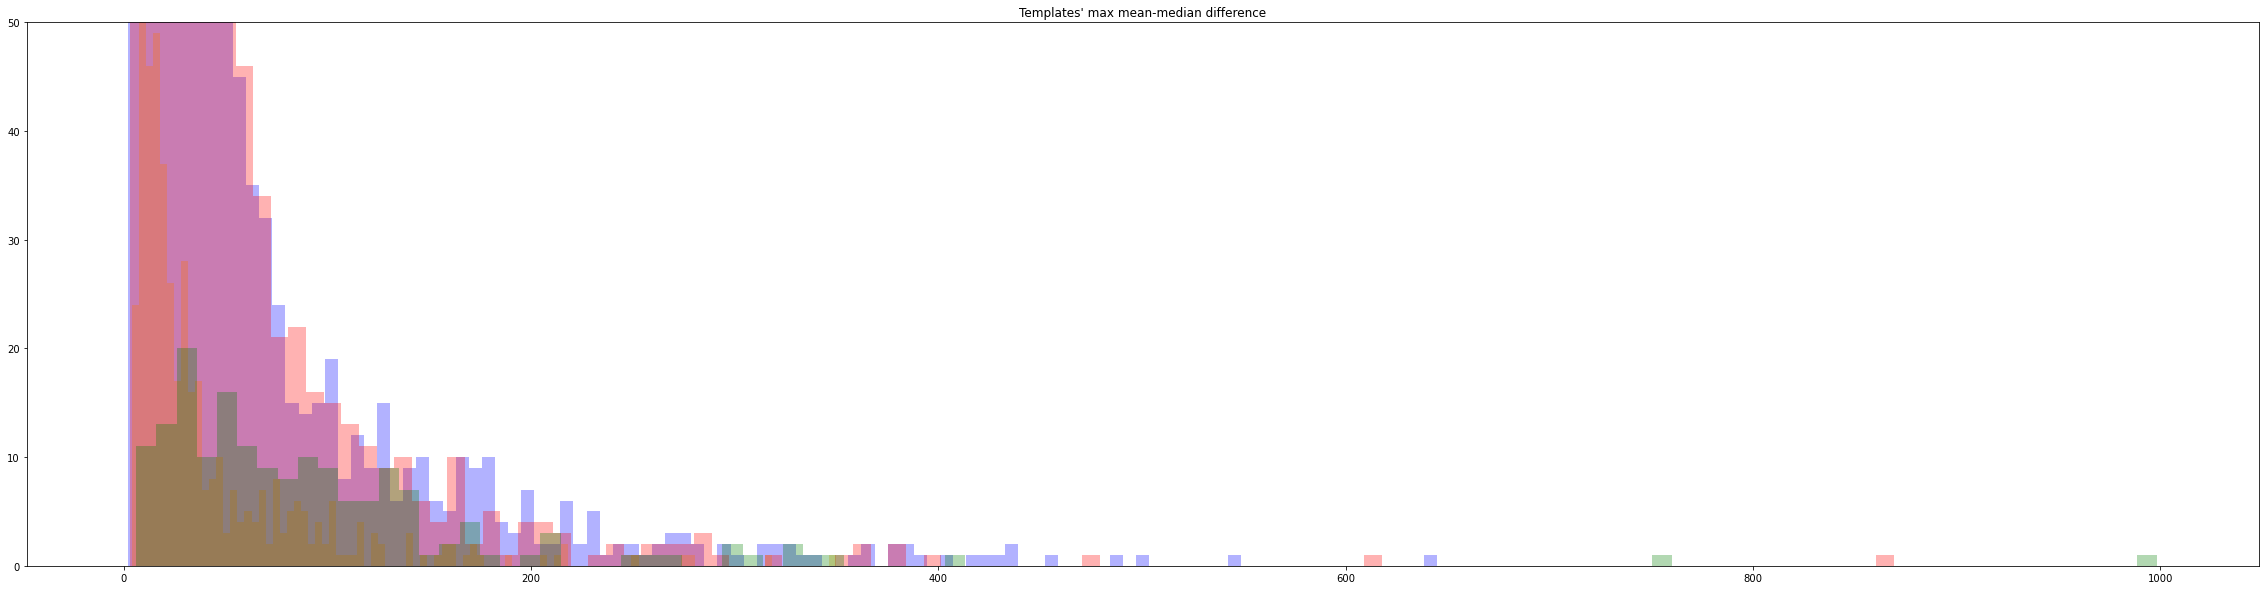

In [119]:
df_templates_mean_median_diff_abs_max_class0 = df_templates_mean_median_diff_abs_class0.max(axis=1)
df_templates_mean_median_diff_abs_max_class1 = df_templates_mean_median_diff_abs_class1.max(axis=1)
df_templates_mean_median_diff_abs_max_class2 = df_templates_mean_median_diff_abs_class2.max(axis=1)
df_templates_mean_median_diff_abs_max_class3 = df_templates_mean_median_diff_abs_class3.max(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_mean_median_diff_abs_max_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_mean_median_diff_abs_max_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_mean_median_diff_abs_max_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_mean_median_diff_abs_max_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Templates' max mean-median difference")
plt.show()

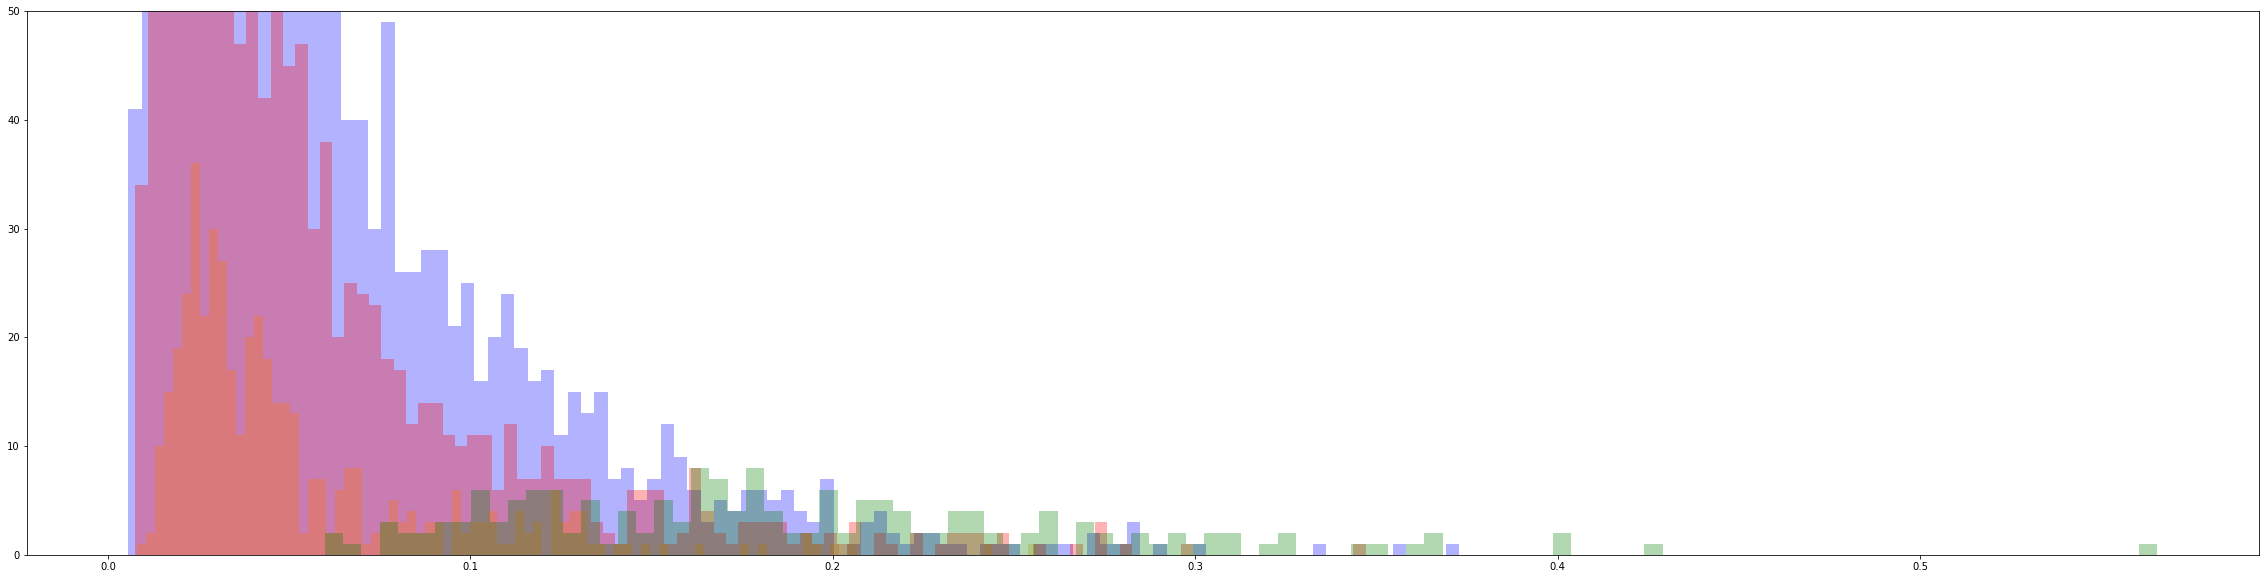

In [120]:
df_templates_std_scaled_class0 = get_templates_std(df_ecg_class0, scale="minmax")
df_templates_std_scaled_class1 = get_templates_std(df_ecg_class1, scale="minmax")
df_templates_std_scaled_class2 = get_templates_std(df_ecg_class2, scale="minmax")
df_templates_std_scaled_class3 = get_templates_std(df_ecg_class3, scale="minmax")

df_templates_std_scaled_mean_class0 = df_templates_std_scaled_class0.mean(axis=1)
df_templates_std_scaled_mean_class1 = df_templates_std_scaled_class1.mean(axis=1)
df_templates_std_scaled_mean_class2 = df_templates_std_scaled_class2.mean(axis=1)
df_templates_std_scaled_mean_class3 = df_templates_std_scaled_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_std_scaled_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_std_scaled_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_std_scaled_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_std_scaled_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's mean scaled std. dev.")
plt.show()

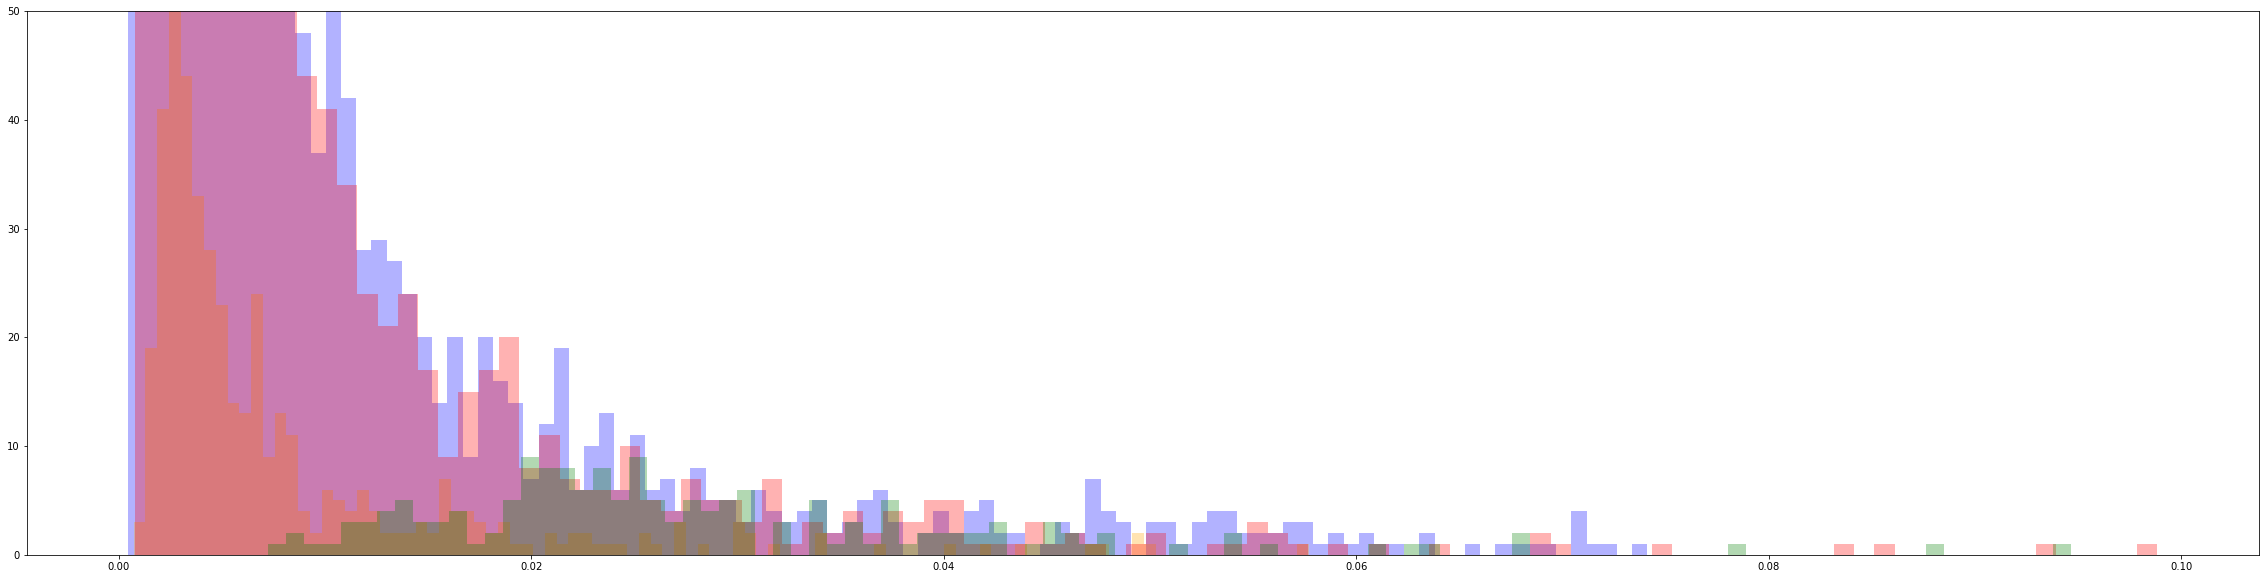

In [121]:
df_templates_mean_median_diff_scaled_class0, df_templates_mean_median_diff_scaled_abs_class0 = get_templates_mean_median_diff(df_ecg_class0, scale="minmax")
df_templates_mean_median_diff_scaled_class1, df_templates_mean_median_diff_scaled_abs_class1 = get_templates_mean_median_diff(df_ecg_class1, scale="minmax")
df_templates_mean_median_diff_scaled_class2, df_templates_mean_median_diff_scaled_abs_class2 = get_templates_mean_median_diff(df_ecg_class2, scale="minmax")
df_templates_mean_median_diff_scaled_class3, df_templates_mean_median_diff_scaled_abs_class3 = get_templates_mean_median_diff(df_ecg_class3, scale="minmax")

df_templates_mean_median_diff_scaled_abs_mean_class0 = df_templates_mean_median_diff_scaled_abs_class0.mean(axis=1)
df_templates_mean_median_diff_scaled_abs_mean_class1 = df_templates_mean_median_diff_scaled_abs_class1.mean(axis=1)
df_templates_mean_median_diff_scaled_abs_mean_class2 = df_templates_mean_median_diff_scaled_abs_class2.mean(axis=1)
df_templates_mean_median_diff_scaled_abs_mean_class3 = df_templates_mean_median_diff_scaled_abs_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_mean_median_diff_scaled_abs_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_mean_median_diff_scaled_abs_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_mean_median_diff_scaled_abs_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_mean_median_diff_scaled_abs_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

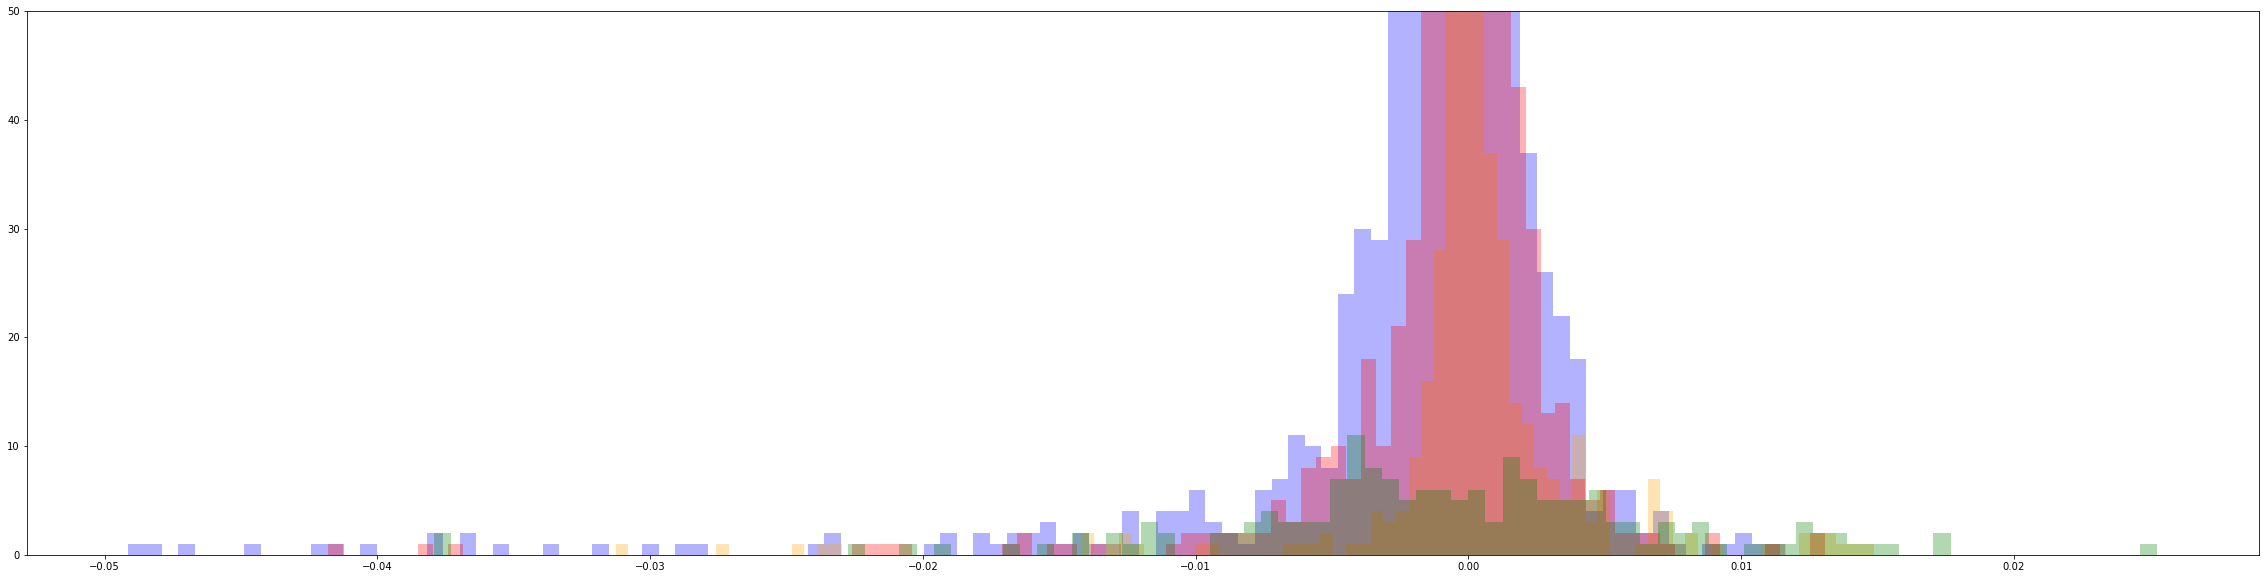

In [122]:
df_templates_mean_median_diff_scaled_mean_class0 = df_templates_mean_median_diff_scaled_class0.mean(axis=1)
df_templates_mean_median_diff_scaled_mean_class1 = df_templates_mean_median_diff_scaled_class1.mean(axis=1)
df_templates_mean_median_diff_scaled_mean_class2 = df_templates_mean_median_diff_scaled_class2.mean(axis=1)
df_templates_mean_median_diff_scaled_mean_class3 = df_templates_mean_median_diff_scaled_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_mean_median_diff_scaled_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_mean_median_diff_scaled_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_mean_median_diff_scaled_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_mean_median_diff_scaled_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

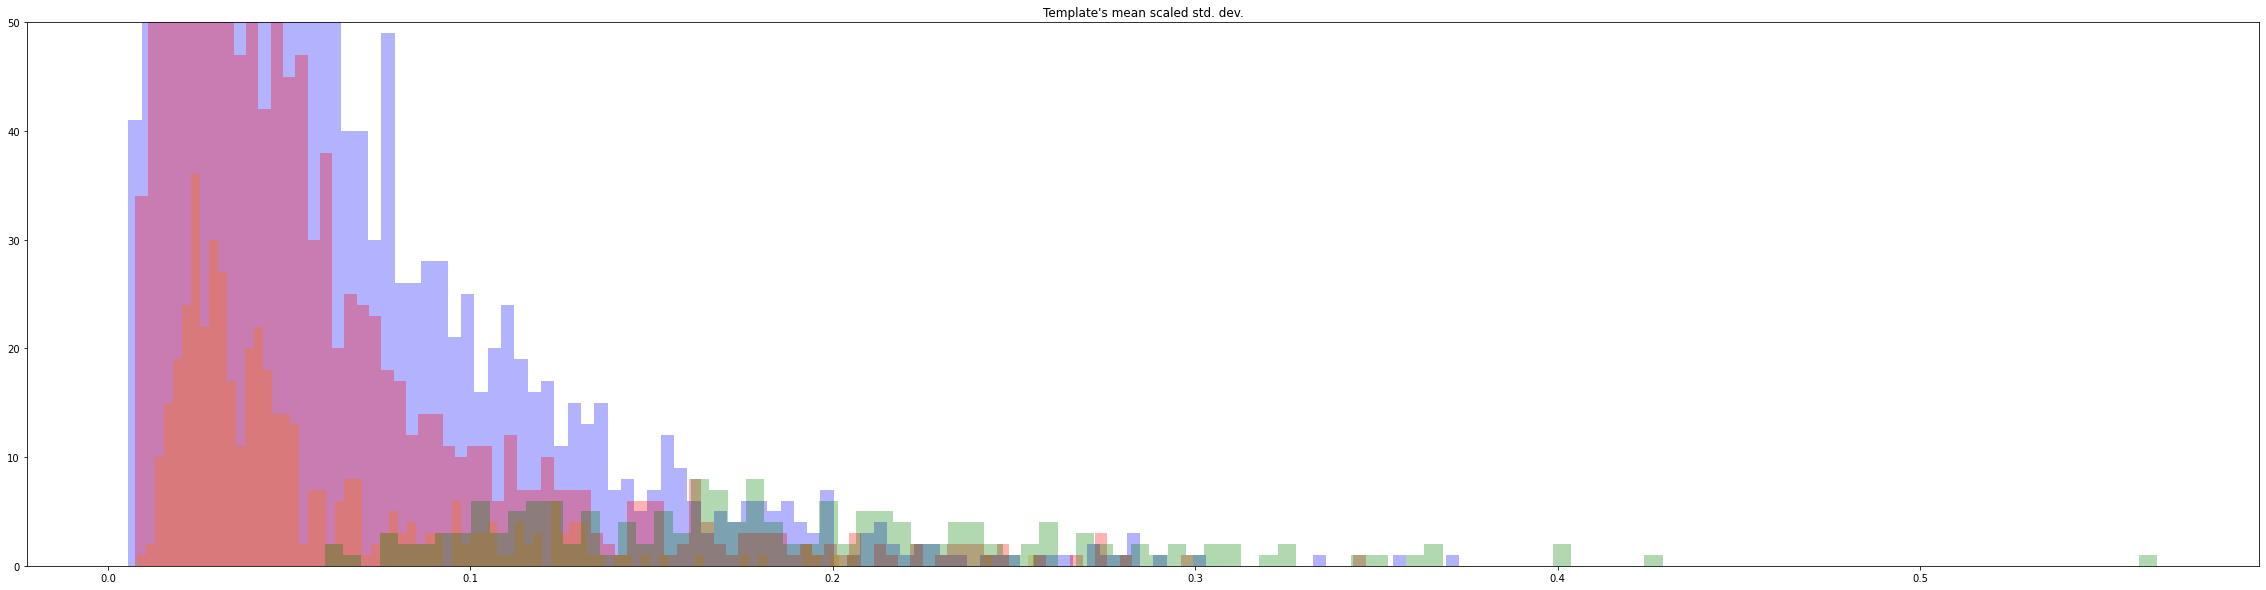

In [123]:
#df_templates_std_class0 = get_templates_std(df_ecg_class0, scale="minmax")
#df_templates_std_class1 = get_templates_std(df_ecg_class1, scale="minmax")
#df_templates_std_class2 = get_templates_std(df_ecg_class2, scale="minmax")
#df_templates_std_class3 = get_templates_std(df_ecg_class3, scale="minmax")

df_templates_std_scaled_mean_class0 = df_templates_std_scaled_class0.mean(axis=1)
df_templates_std_scaled_mean_class1 = df_templates_std_scaled_class1.mean(axis=1)
df_templates_std_scaled_mean_class2 = df_templates_std_scaled_class2.mean(axis=1)
df_templates_std_scaled_mean_class3 = df_templates_std_scaled_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_std_scaled_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_std_scaled_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_std_scaled_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_std_scaled_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's mean scaled std. dev.")
plt.show()

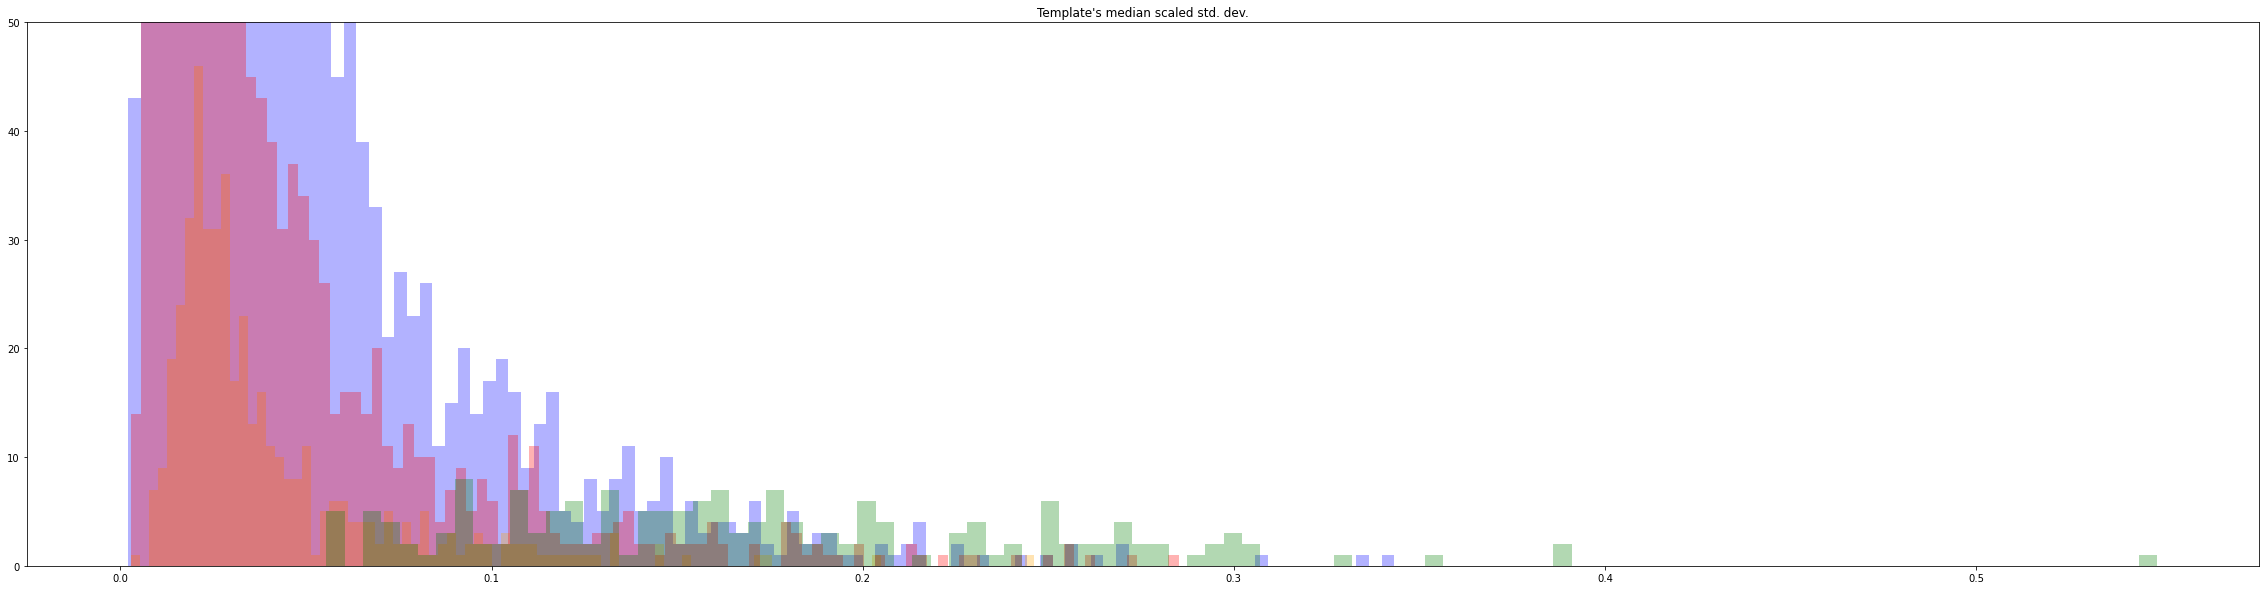

In [140]:
#df_templates_std_class0 = get_templates_std(df_ecg_class0, scale="minmax")
#df_templates_std_class1 = get_templates_std(df_ecg_class1, scale="minmax")
#df_templates_std_class2 = get_templates_std(df_ecg_class2, scale="minmax")
#df_templates_std_class3 = get_templates_std(df_ecg_class3, scale="minmax")

df_templates_std_scaled_median_class0 = df_templates_std_scaled_class0.median(axis=1)
df_templates_std_scaled_median_class1 = df_templates_std_scaled_class1.median(axis=1)
df_templates_std_scaled_median_class2 = df_templates_std_scaled_class2.median(axis=1)
df_templates_std_scaled_median_class3 = df_templates_std_scaled_class3.median(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_templates_std_scaled_median_class0, **kwargs, color="b", label="class0")
plt.hist(df_templates_std_scaled_median_class1, **kwargs, color="orange", label="class1")
plt.hist(df_templates_std_scaled_median_class2, **kwargs, color="r", label="class2")
plt.hist(df_templates_std_scaled_median_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Template's median scaled std. dev.")
plt.show()

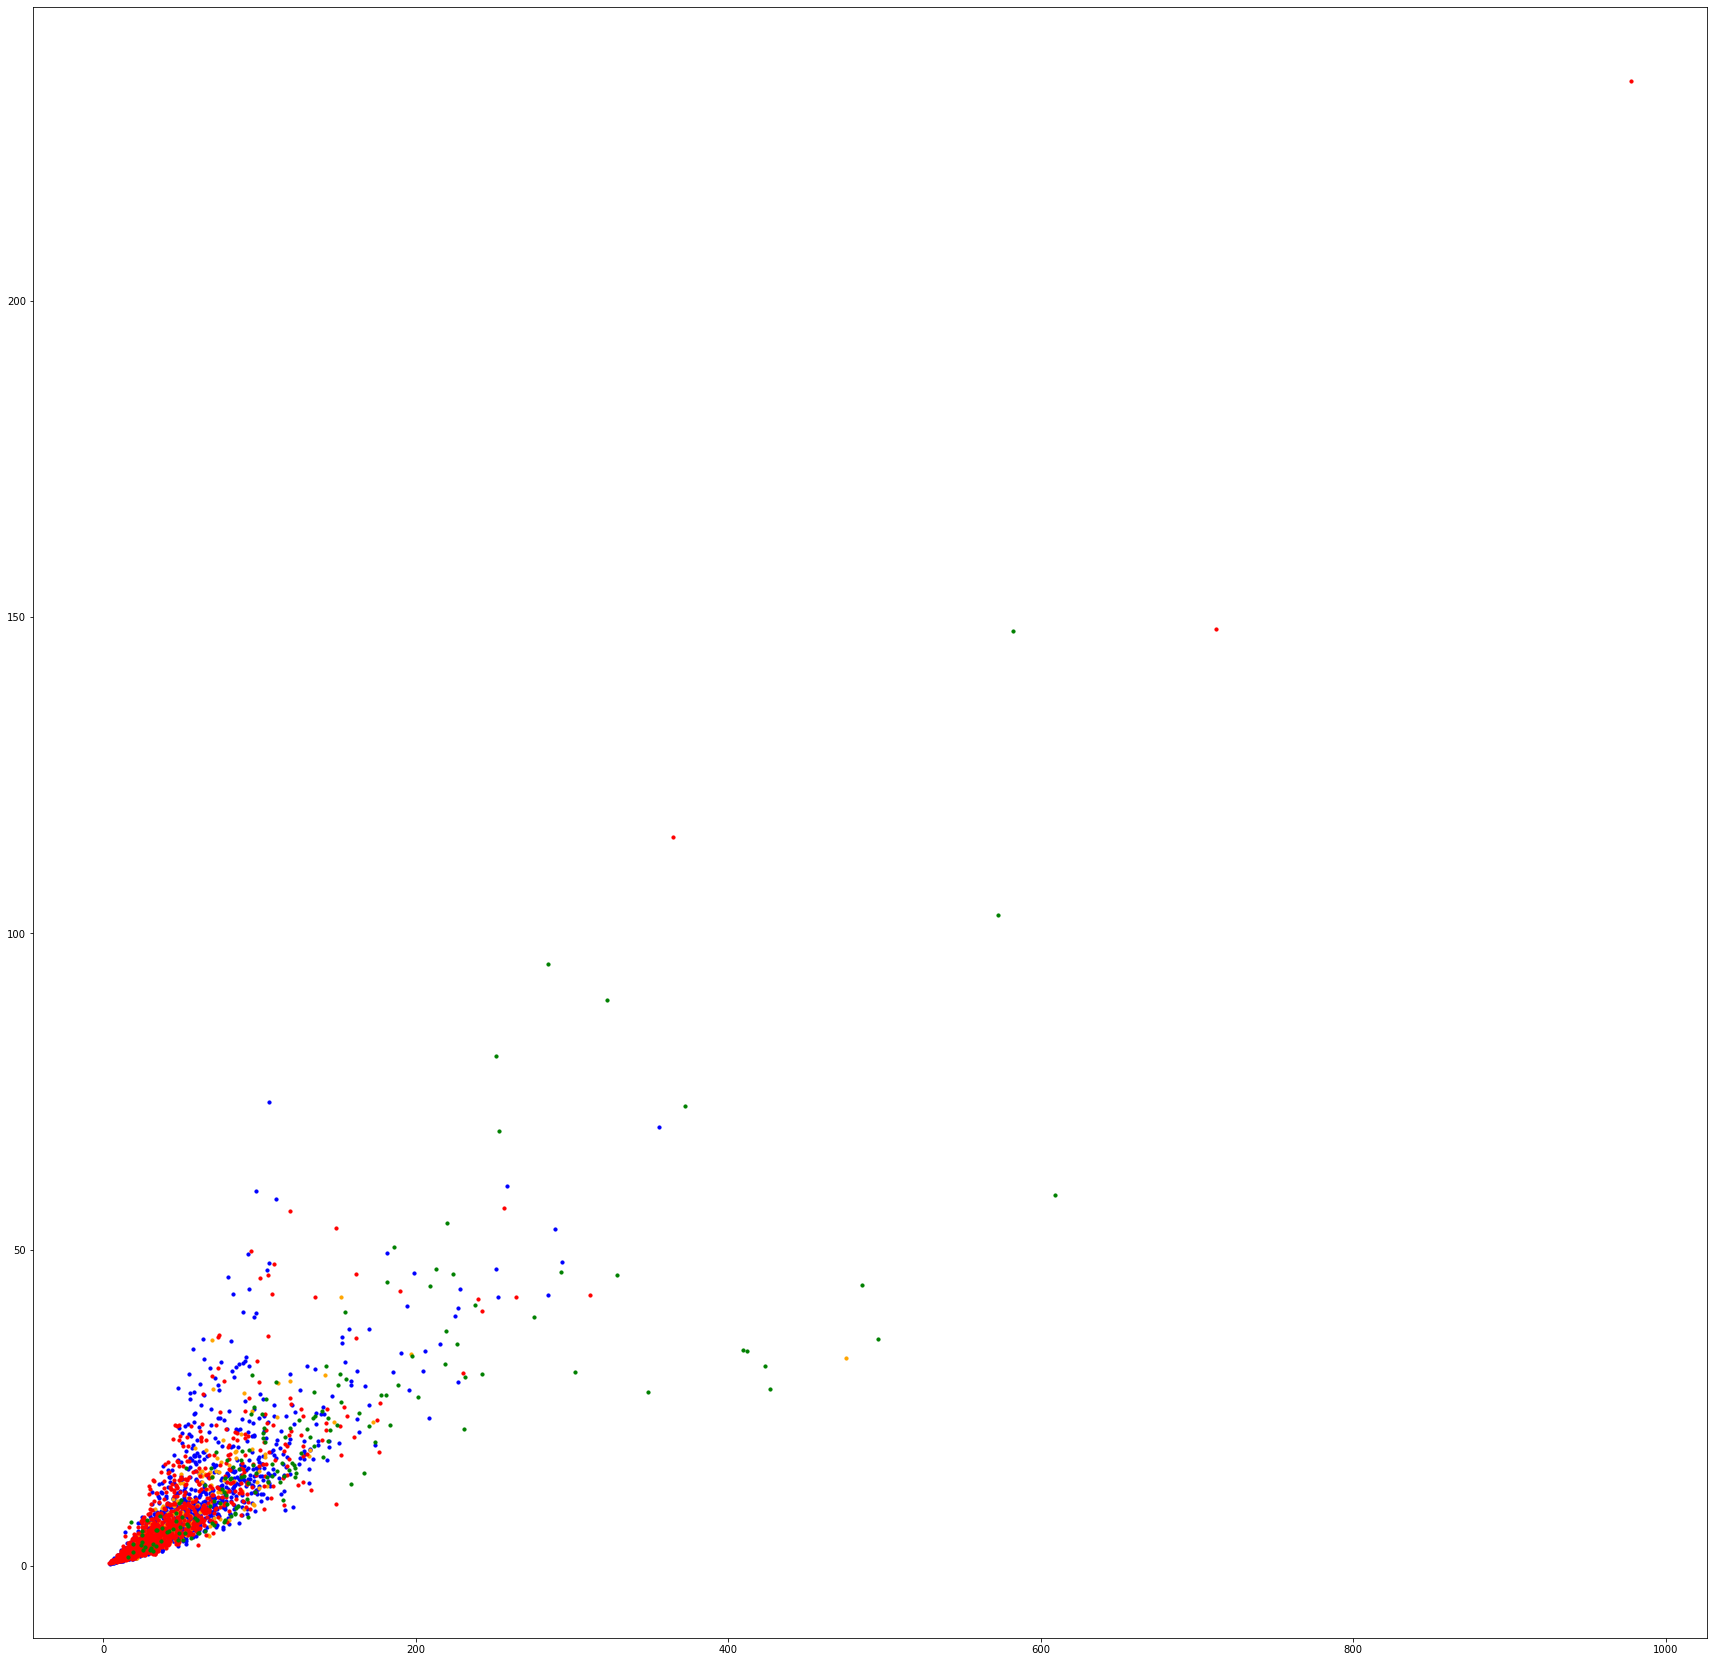

In [125]:
plt.figure(figsize=(30,30))
plt.scatter(df_templates_std_mean_class0, df_templates_mean_median_diff_abs_mean_class0, s=10, color="b")
plt.scatter(df_templates_std_mean_class1, df_templates_mean_median_diff_abs_mean_class1, s=10, color="orange")
plt.scatter(df_templates_std_mean_class2, df_templates_mean_median_diff_abs_mean_class2, s=10, color="r")
plt.scatter(df_templates_std_mean_class3, df_templates_mean_median_diff_abs_mean_class3, s=10, color="g")
plt.show()

# Extract signal amplitude

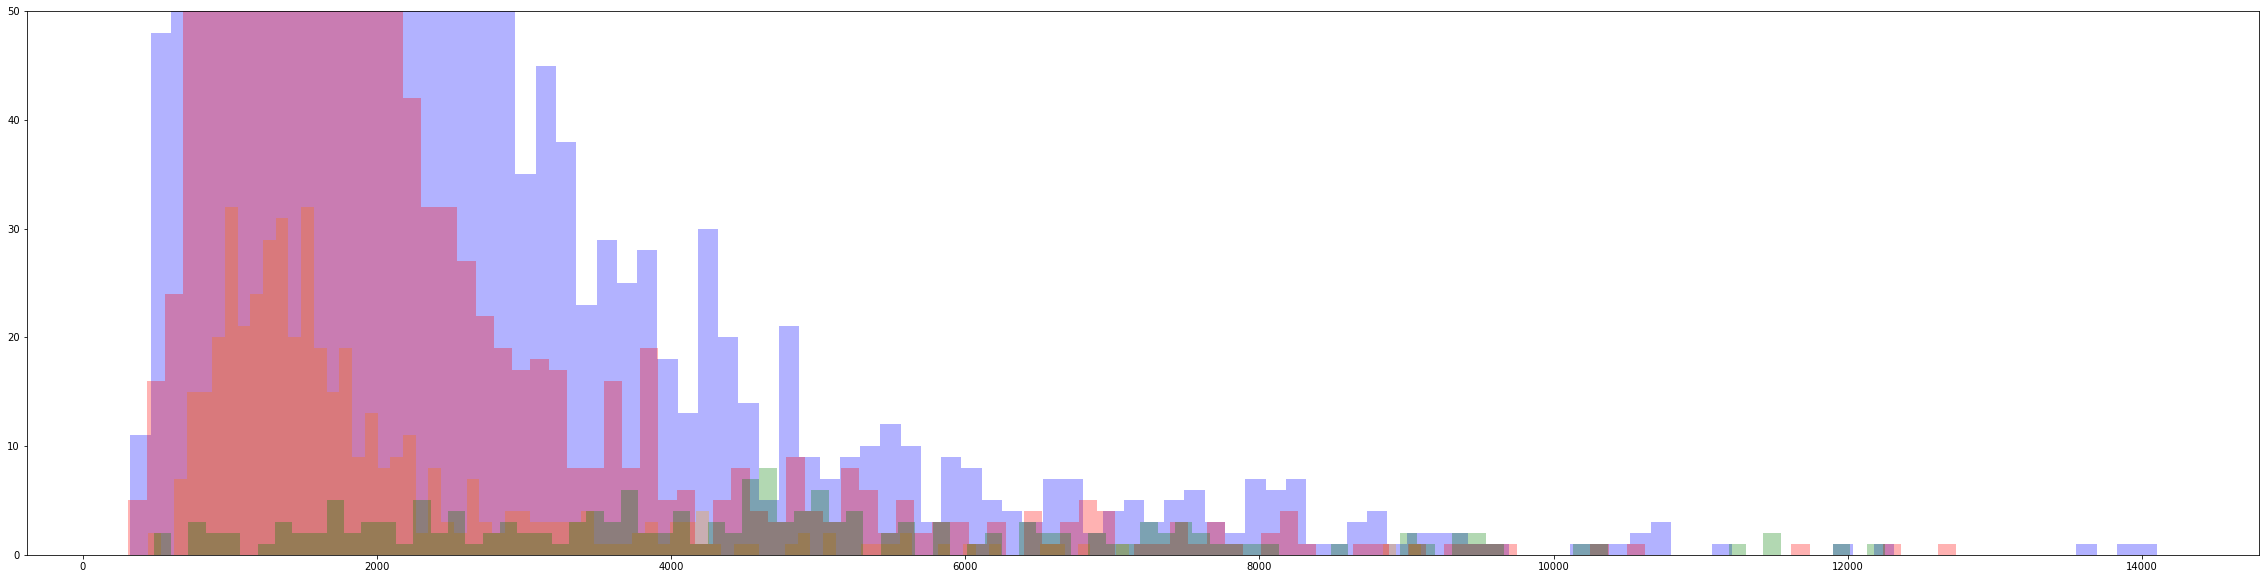

In [58]:
def get_signal_amplitude(df_signal):
    
    df_signal_amp = []
    for index, row in df_signal.iterrows():
        signal = row[row.notna()]
        signal_amp = np.max(signal) - np.min(signal)
        
        df_signal_amp.append(signal_amp)
        
    return pd.Series(df_signal_amp)

df_signal_amp_class0 = get_signal_amplitude(X_train_class0)
df_signal_amp_class1 = get_signal_amplitude(X_train_class1)
df_signal_amp_class2 = get_signal_amplitude(X_train_class2)
df_signal_amp_class3 = get_signal_amplitude(X_train_class3)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_signal_amp_class0, **kwargs, color="b", label="class0")
plt.hist(df_signal_amp_class1, **kwargs, color="orange", label="class1")
plt.hist(df_signal_amp_class2, **kwargs, color="r", label="class2")
plt.hist(df_signal_amp_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

In [31]:
df_ecg_class0 = process_df_ecg(X_train_class0, scaler=None)
df_ecg_class1 = process_df_ecg(X_train_class1, scaler=None)
df_ecg_class2 = process_df_ecg(X_train_class2, scaler=None)
df_ecg_class3 = process_df_ecg(X_train_class3, scaler=None)

# Visualize heartrate

In [160]:
def get_heartrate(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(len(df_ecg)):
        
        heartrate = pd.Series(df_ecg[i].heart_rate)
        results = results.append(heartrate, ignore_index=True)
        
    return results

In [161]:
heartrate_class0 = get_heartrate(df_ecg_class0)
heartrate_class1 = get_heartrate(df_ecg_class1)
heartrate_class2 = get_heartrate(df_ecg_class2)
heartrate_class3 = get_heartrate(df_ecg_class3)

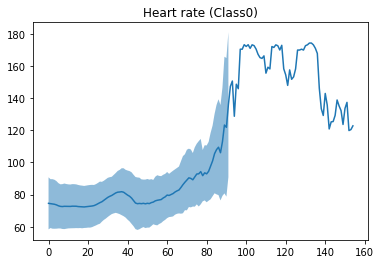

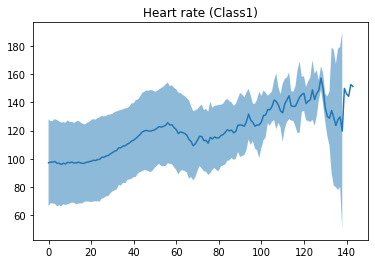

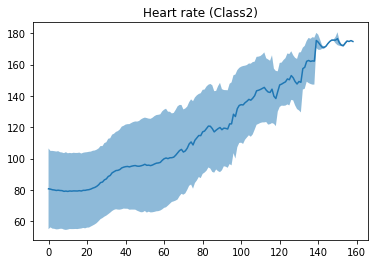

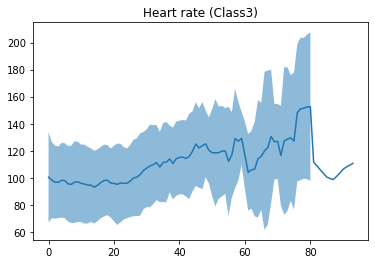

In [47]:
plot_mean(heartrate_class0, title="Heart rate (Class0)")
plot_mean(heartrate_class1, title="Heart rate (Class1)")
plot_mean(heartrate_class2, title="Heart rate (Class2)")
plot_mean(heartrate_class3, title="Heart rate (Class3)")

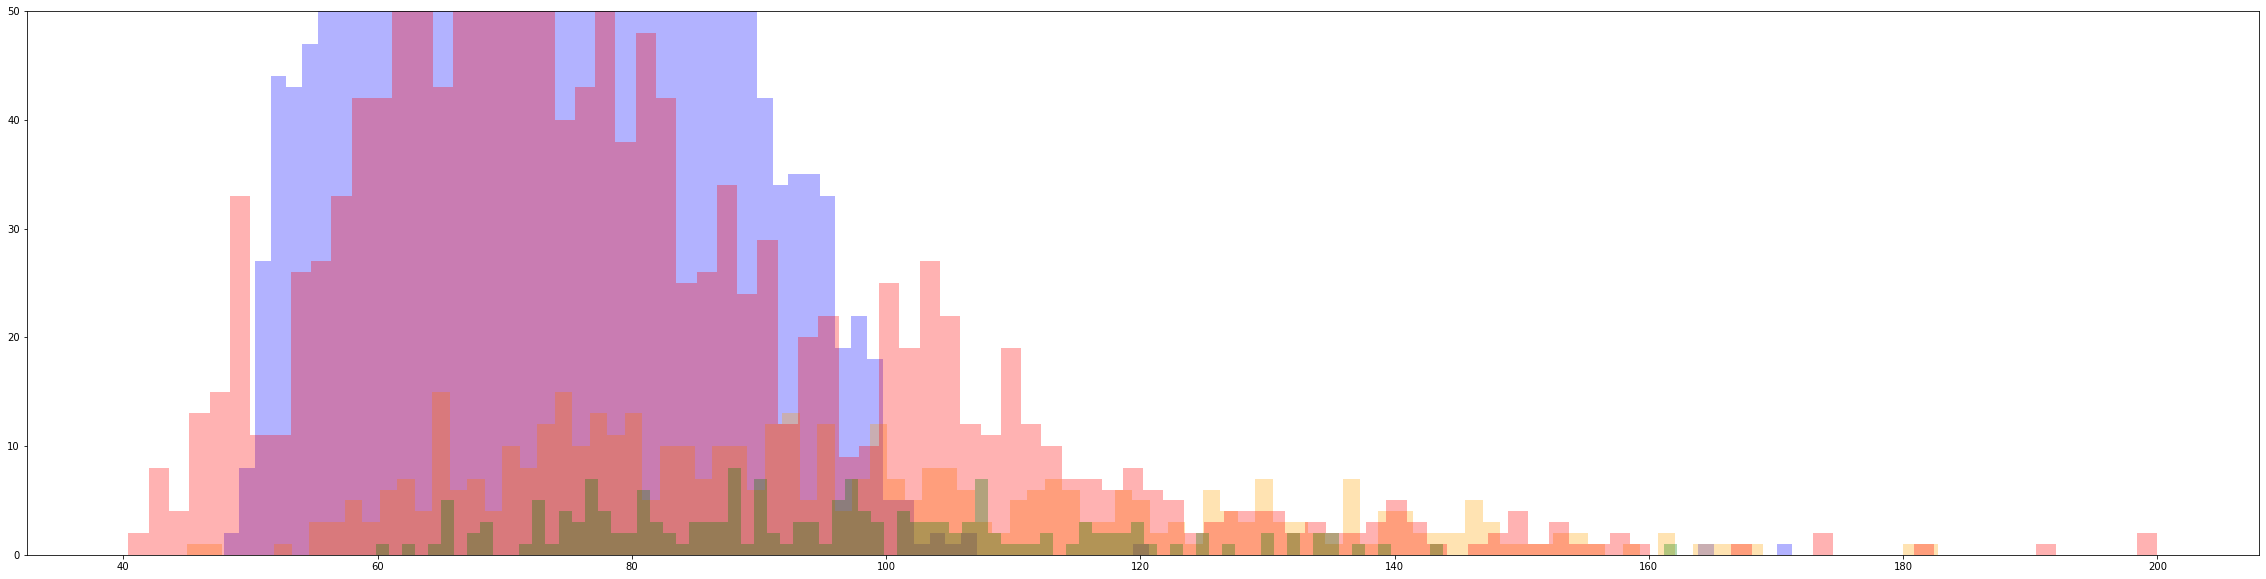

In [128]:
heartrate_mean_class0 = heartrate_class0.mean(axis=1)
heartrate_mean_class1 = heartrate_class1.mean(axis=1)
heartrate_mean_class2 = heartrate_class2.mean(axis=1)
heartrate_mean_class3 = heartrate_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(heartrate_mean_class0, **kwargs, color="b", label="class0")
plt.hist(heartrate_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(heartrate_mean_class2, **kwargs, color="r", label="class2")
plt.hist(heartrate_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

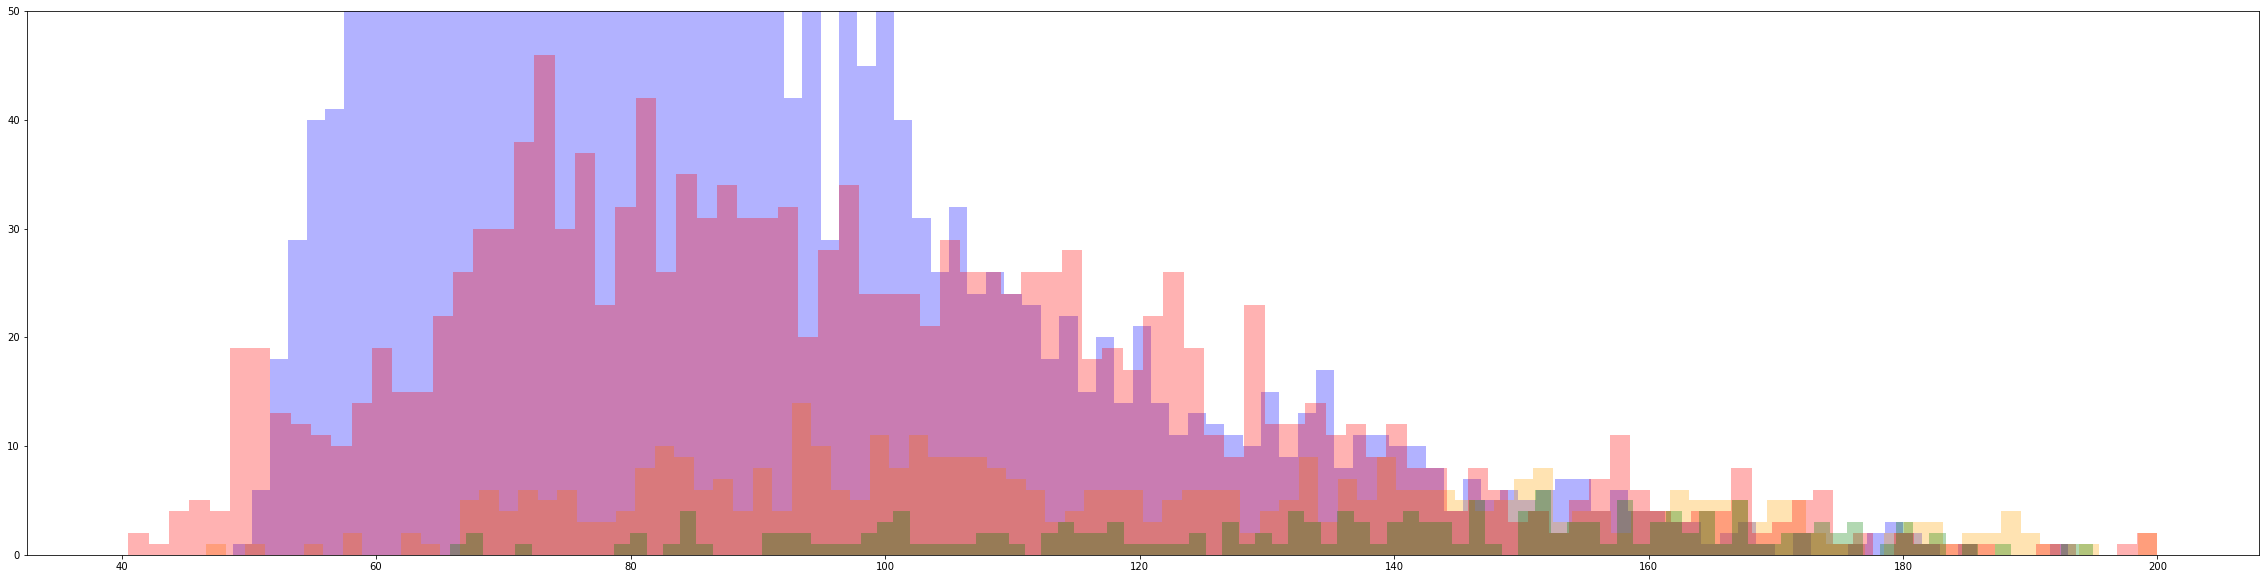

In [162]:
heartrate_max_class0 = heartrate_class0.max(axis=1)
heartrate_max_class1 = heartrate_class1.max(axis=1)
heartrate_max_class2 = heartrate_class2.max(axis=1)
heartrate_max_class3 = heartrate_class3.max(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(heartrate_max_class0, **kwargs, color="b", label="class0")
plt.hist(heartrate_max_class1, **kwargs, color="orange", label="class1")
plt.hist(heartrate_max_class2, **kwargs, color="r", label="class2")
plt.hist(heartrate_max_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

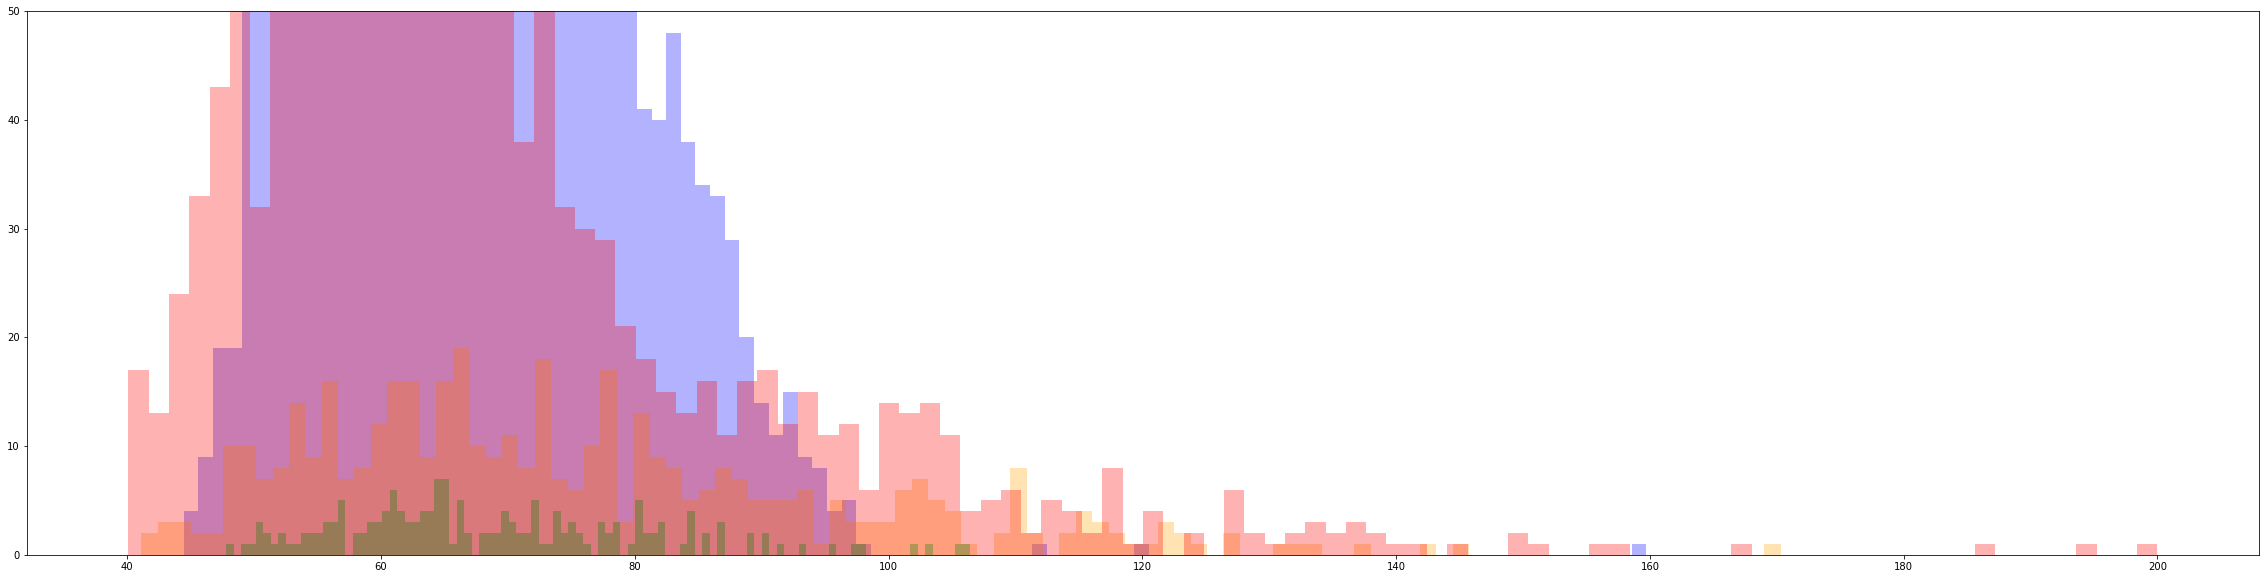

In [163]:
heartrate_min_class0 = heartrate_class0.min(axis=1)
heartrate_min_class1 = heartrate_class1.min(axis=1)
heartrate_min_class2 = heartrate_class2.min(axis=1)
heartrate_min_class3 = heartrate_class3.min(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(heartrate_min_class0, **kwargs, color="b", label="class0")
plt.hist(heartrate_min_class1, **kwargs, color="orange", label="class1")
plt.hist(heartrate_min_class2, **kwargs, color="r", label="class2")
plt.hist(heartrate_min_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

C:\Users\foong\Miniconda3\envs\machine-learning\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


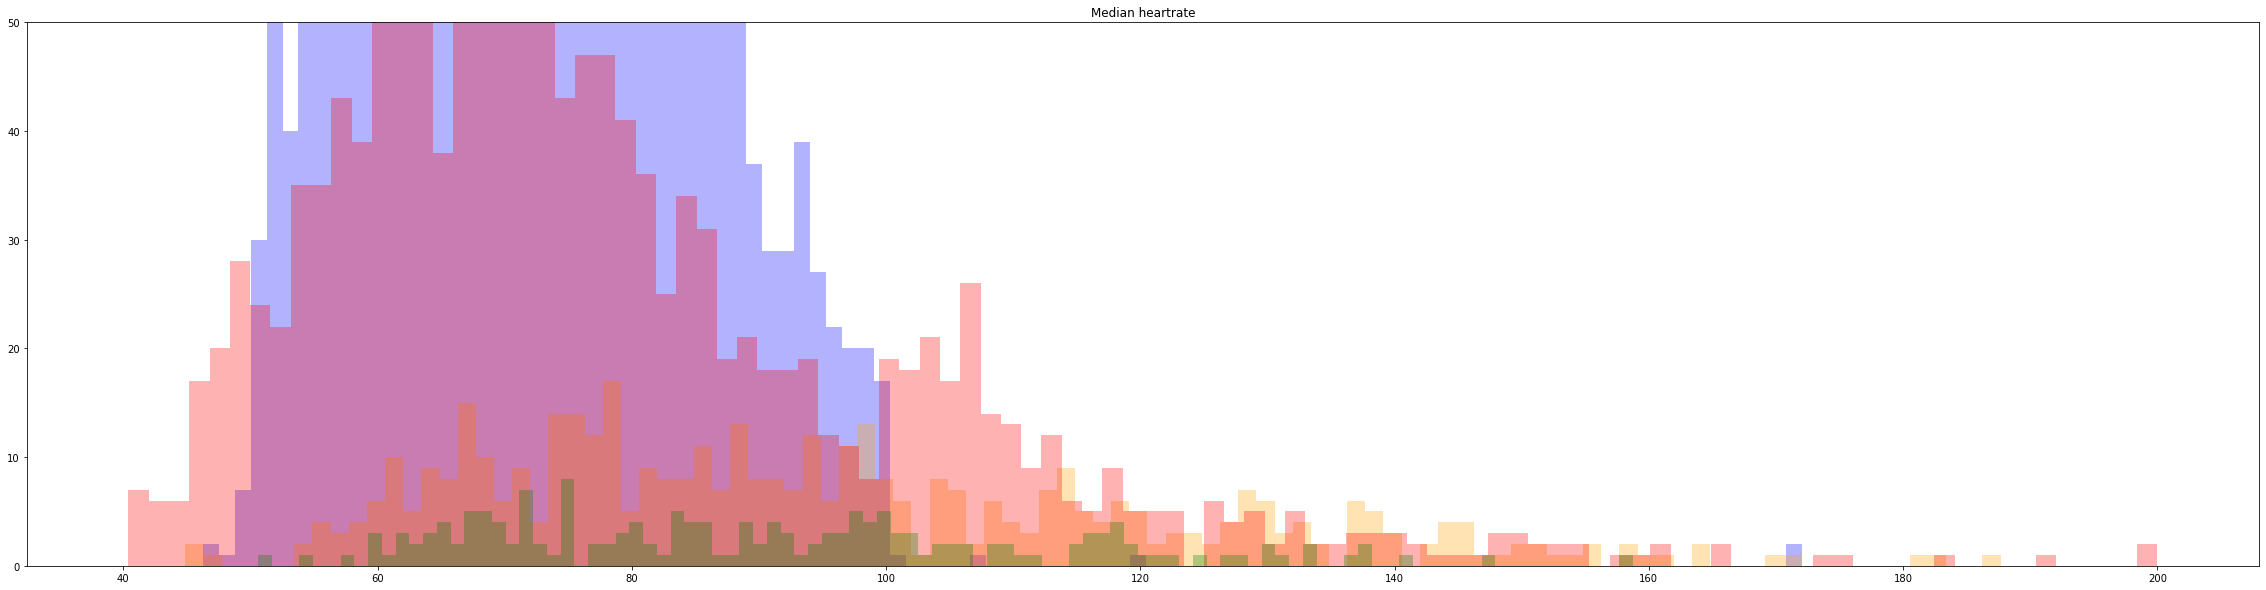

In [134]:
heartrate_median_class0 = heartrate_class0.median(axis=1)
heartrate_median_class1 = heartrate_class1.median(axis=1)
heartrate_median_class2 = heartrate_class2.median(axis=1)
heartrate_median_class3 = heartrate_class3.median(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(heartrate_median_class0, **kwargs, color="b", label="class0")
plt.hist(heartrate_median_class1, **kwargs, color="orange", label="class1")
plt.hist(heartrate_median_class2, **kwargs, color="r", label="class2")
plt.hist(heartrate_median_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.title("Median heartrate")
plt.show()

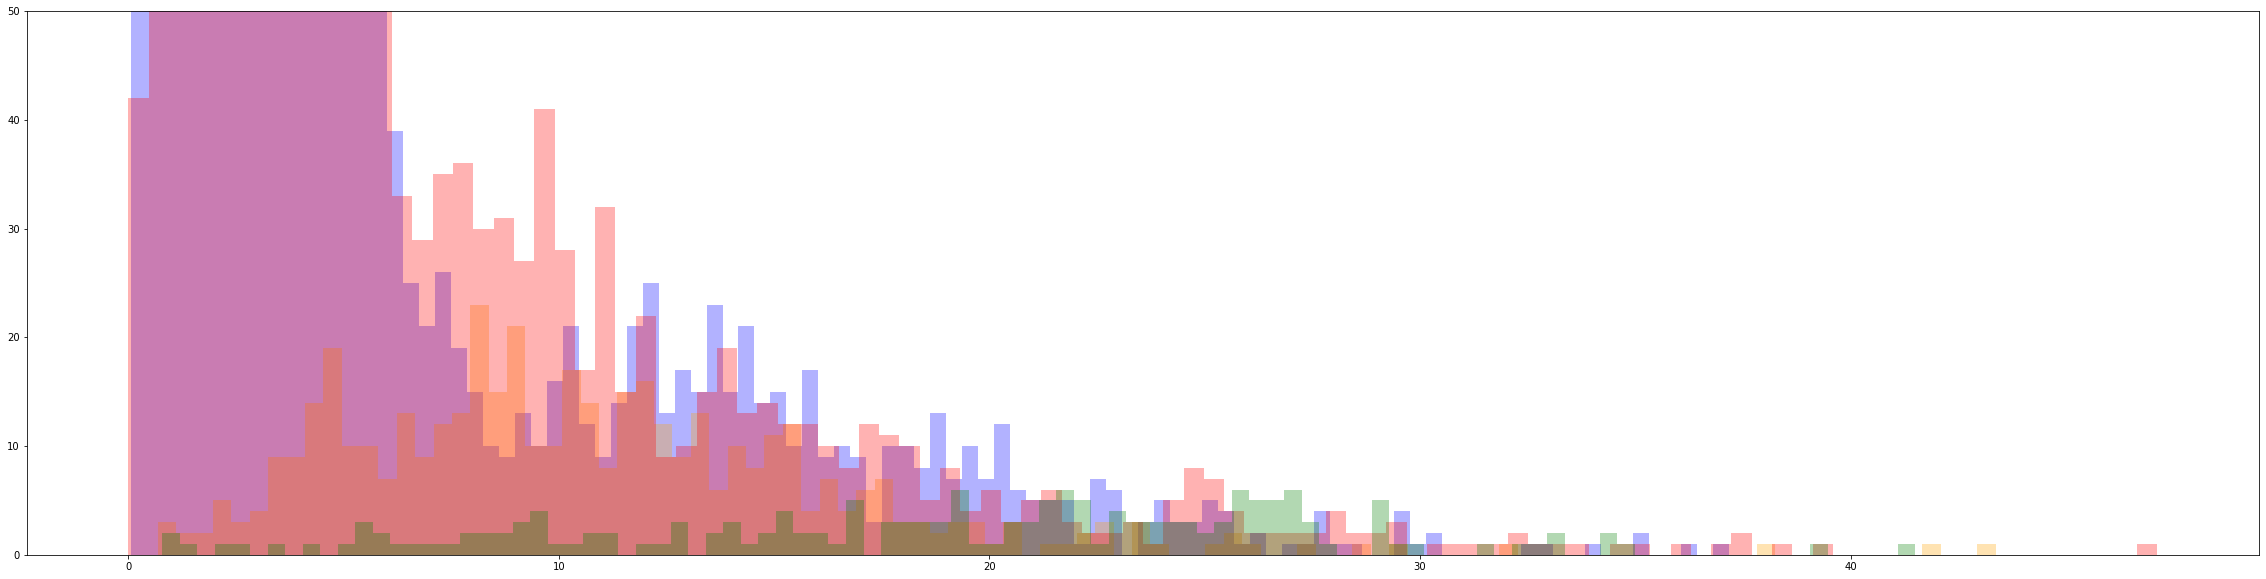

In [129]:
heartrate_std_class0 = heartrate_class0.std(axis=1)
heartrate_std_class1 = heartrate_class1.std(axis=1)
heartrate_std_class2 = heartrate_class2.std(axis=1)
heartrate_std_class3 = heartrate_class3.std(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(heartrate_std_class0, **kwargs, color="b", label="class0")
plt.hist(heartrate_std_class1, **kwargs, color="orange", label="class1")
plt.hist(heartrate_std_class2, **kwargs, color="r", label="class2")
plt.hist(heartrate_std_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

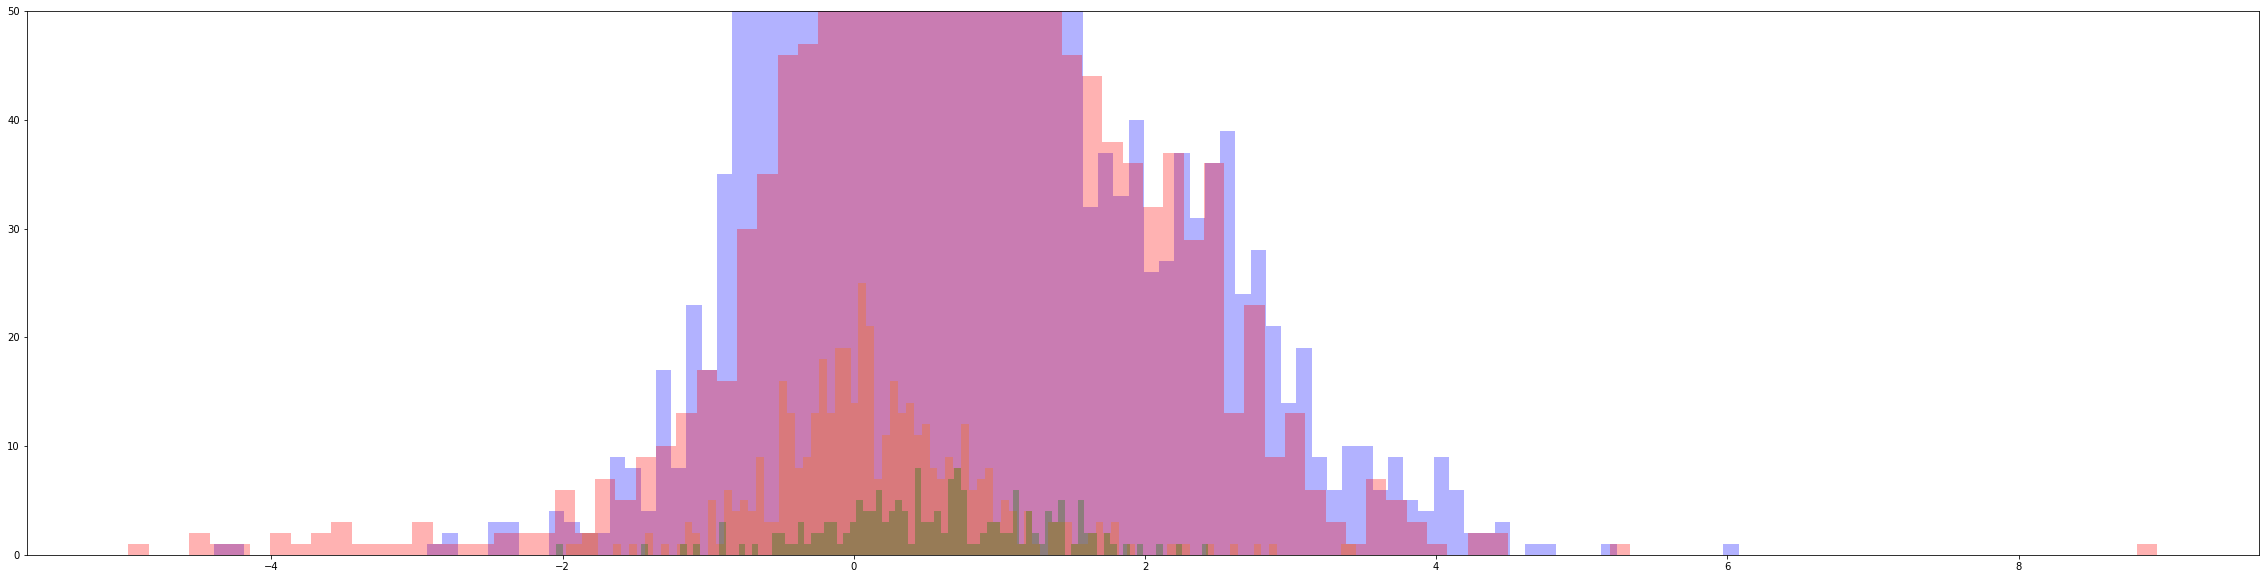

In [70]:
heartrate_skew_class0 = skew(heartrate_class0, axis=1, nan_policy="omit")
heartrate_skew_class1 = skew(heartrate_class1, axis=1, nan_policy="omit")
heartrate_skew_class2 = skew(heartrate_class2, axis=1, nan_policy="omit")
heartrate_skew_class3 = skew(heartrate_class3, axis=1, nan_policy="omit")

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(heartrate_skew_class0, **kwargs, color="b", label="class0")
plt.hist(heartrate_skew_class1, **kwargs, color="orange", label="class1")
plt.hist(heartrate_skew_class2, **kwargs, color="r", label="class2")
plt.hist(heartrate_skew_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

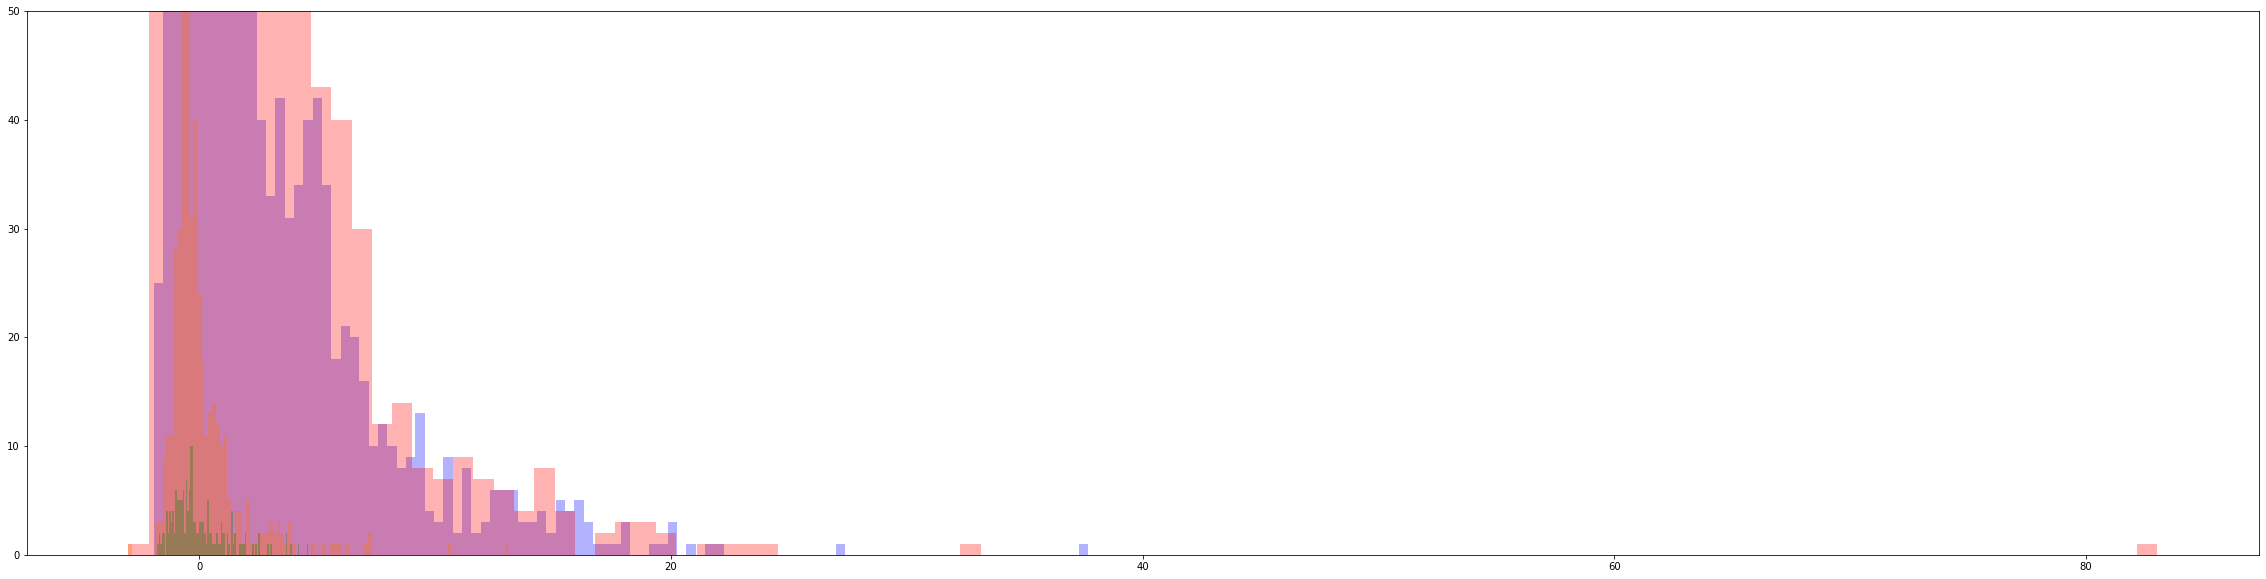

In [152]:
heartrate_kurtosis_class0 = pd.Series(kurtosis(heartrate_class0, axis=1, nan_policy="omit"))
heartrate_kurtosis_class1 = pd.Series(kurtosis(heartrate_class1, axis=1, nan_policy="omit"))
heartrate_kurtosis_class2 = pd.Series(kurtosis(heartrate_class2, axis=1, nan_policy="omit"))
heartrate_kurtosis_class3 = pd.Series(kurtosis(heartrate_class3, axis=1, nan_policy="omit"))

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(heartrate_kurtosis_class0, **kwargs, color="b", label="class0")
plt.hist(heartrate_kurtosis_class1, **kwargs, color="orange", label="class1")
plt.hist(heartrate_kurtosis_class2, **kwargs, color="r", label="class2")
plt.hist(heartrate_kurtosis_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

In [72]:
def get_chg_heartrate(df_ecg):
    
    df_heartrate = get_heartrate(df_ecg)
    
    results = pd.DataFrame()
    for i in range(len(df_heartrate)):
        result = []
        for j in range(df_heartrate.shape[1]-1):
            chg_heartrate = df_heartrate.iloc[i, j+1] - df_heartrate.iloc[i, j]
            result.append(chg_heartrate)

        results = results.append(pd.Series(result), ignore_index=True)
    
    return results

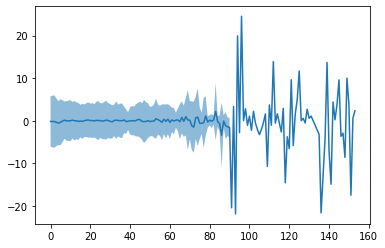

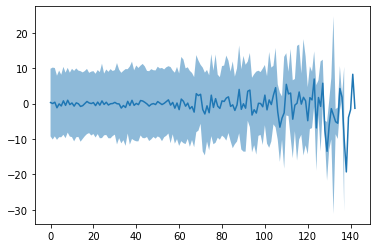

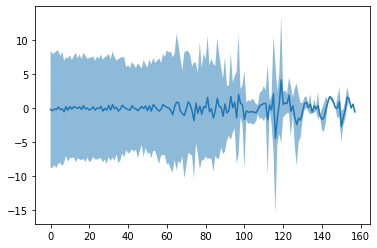

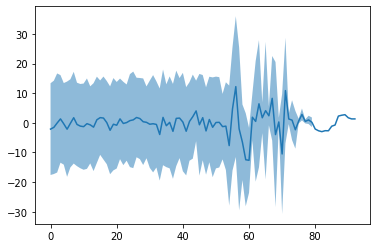

In [73]:
df_chg_heartrate_class0 = get_chg_heartrate(df_ecg_class0)
df_chg_heartrate_class1 = get_chg_heartrate(df_ecg_class1)
df_chg_heartrate_class2 = get_chg_heartrate(df_ecg_class2)
df_chg_heartrate_class3 = get_chg_heartrate(df_ecg_class3)
plot_mean(df_chg_heartrate_class0)
plot_mean(df_chg_heartrate_class1)
plot_mean(df_chg_heartrate_class2)
plot_mean(df_chg_heartrate_class3)

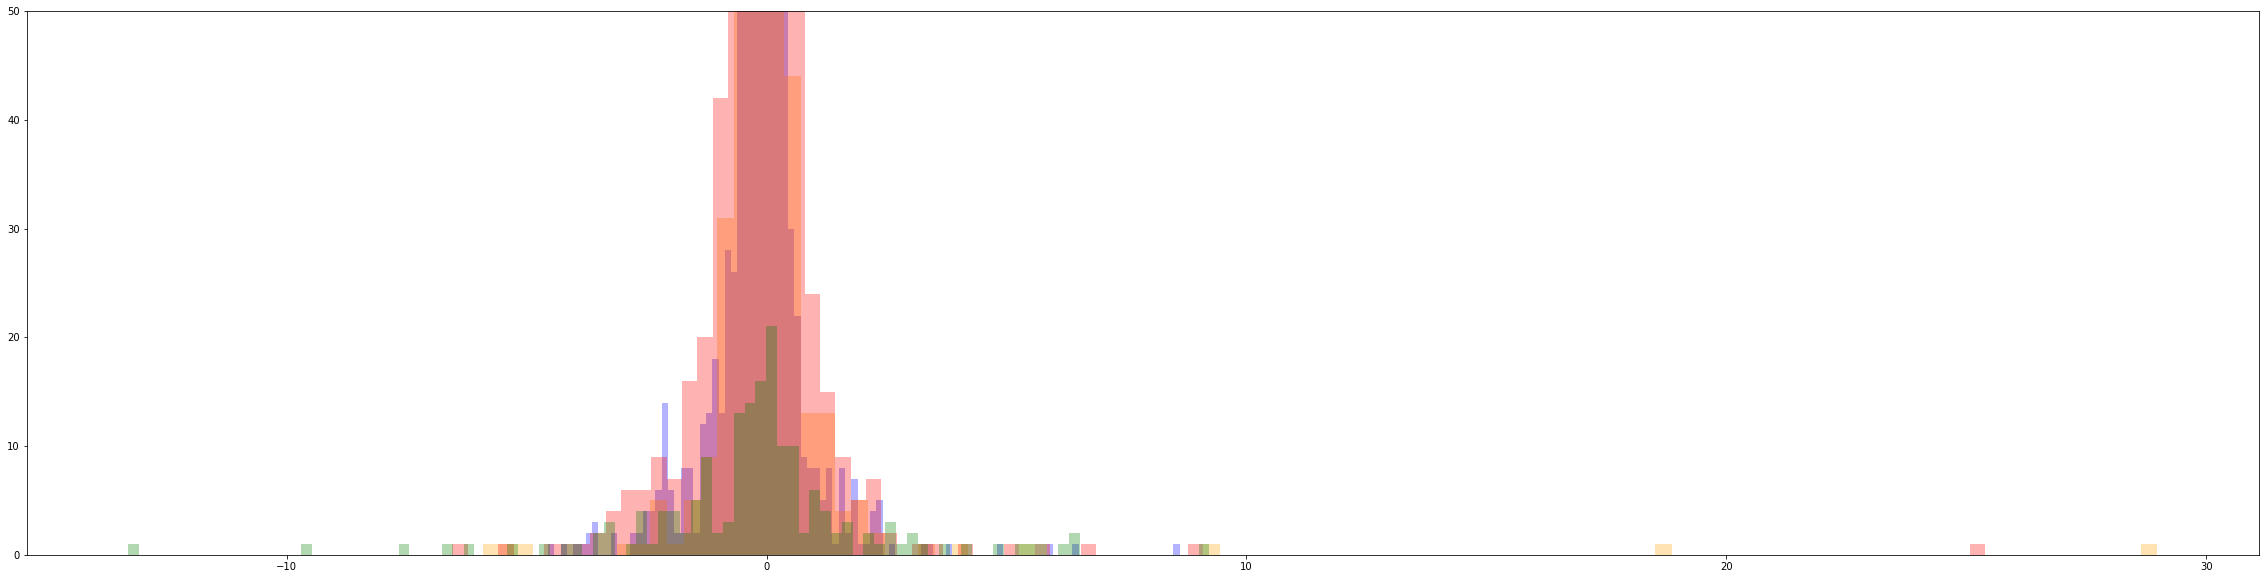

In [75]:
df_chg_heartrate_mean_class0 = df_chg_heartrate_class0.mean(axis=1)
df_chg_heartrate_mean_class1 = df_chg_heartrate_class1.mean(axis=1)
df_chg_heartrate_mean_class2 = df_chg_heartrate_class2.mean(axis=1)
df_chg_heartrate_mean_class3 = df_chg_heartrate_class3.mean(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_chg_heartrate_mean_class0, **kwargs, color="b", label="class0")
plt.hist(df_chg_heartrate_mean_class1, **kwargs, color="orange", label="class1")
plt.hist(df_chg_heartrate_mean_class2, **kwargs, color="r", label="class2")
plt.hist(df_chg_heartrate_mean_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

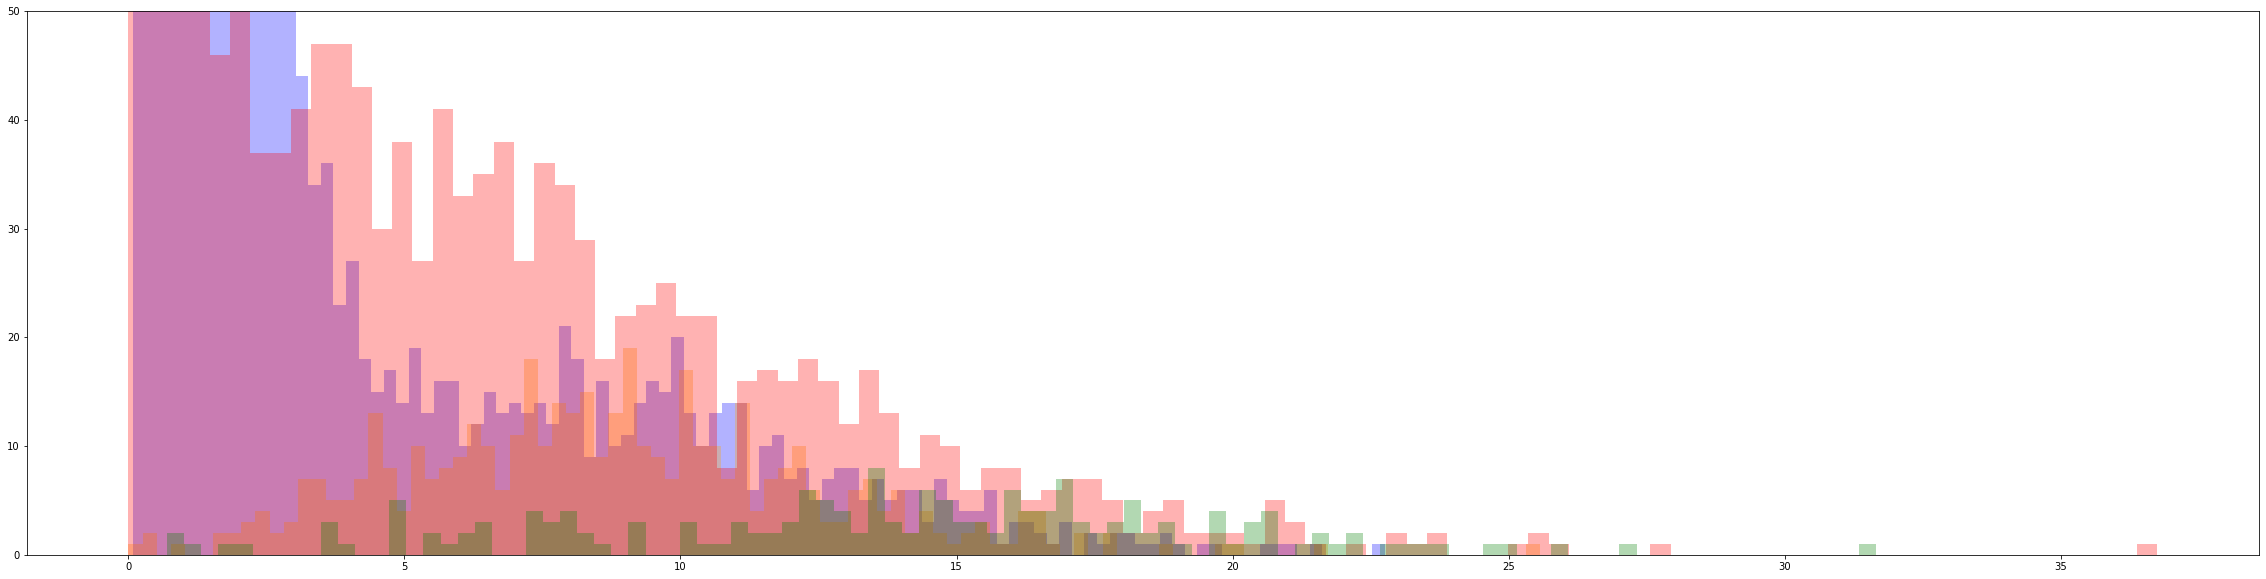

In [76]:
df_chg_heartrate_std_class0 = df_chg_heartrate_class0.std(axis=1)
df_chg_heartrate_std_class1 = df_chg_heartrate_class1.std(axis=1)
df_chg_heartrate_std_class2 = df_chg_heartrate_class2.std(axis=1)
df_chg_heartrate_std_class3 = df_chg_heartrate_class3.std(axis=1)

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_chg_heartrate_std_class0, **kwargs, color="b", label="class0")
plt.hist(df_chg_heartrate_std_class1, **kwargs, color="orange", label="class1")
plt.hist(df_chg_heartrate_std_class2, **kwargs, color="r", label="class2")
plt.hist(df_chg_heartrate_std_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

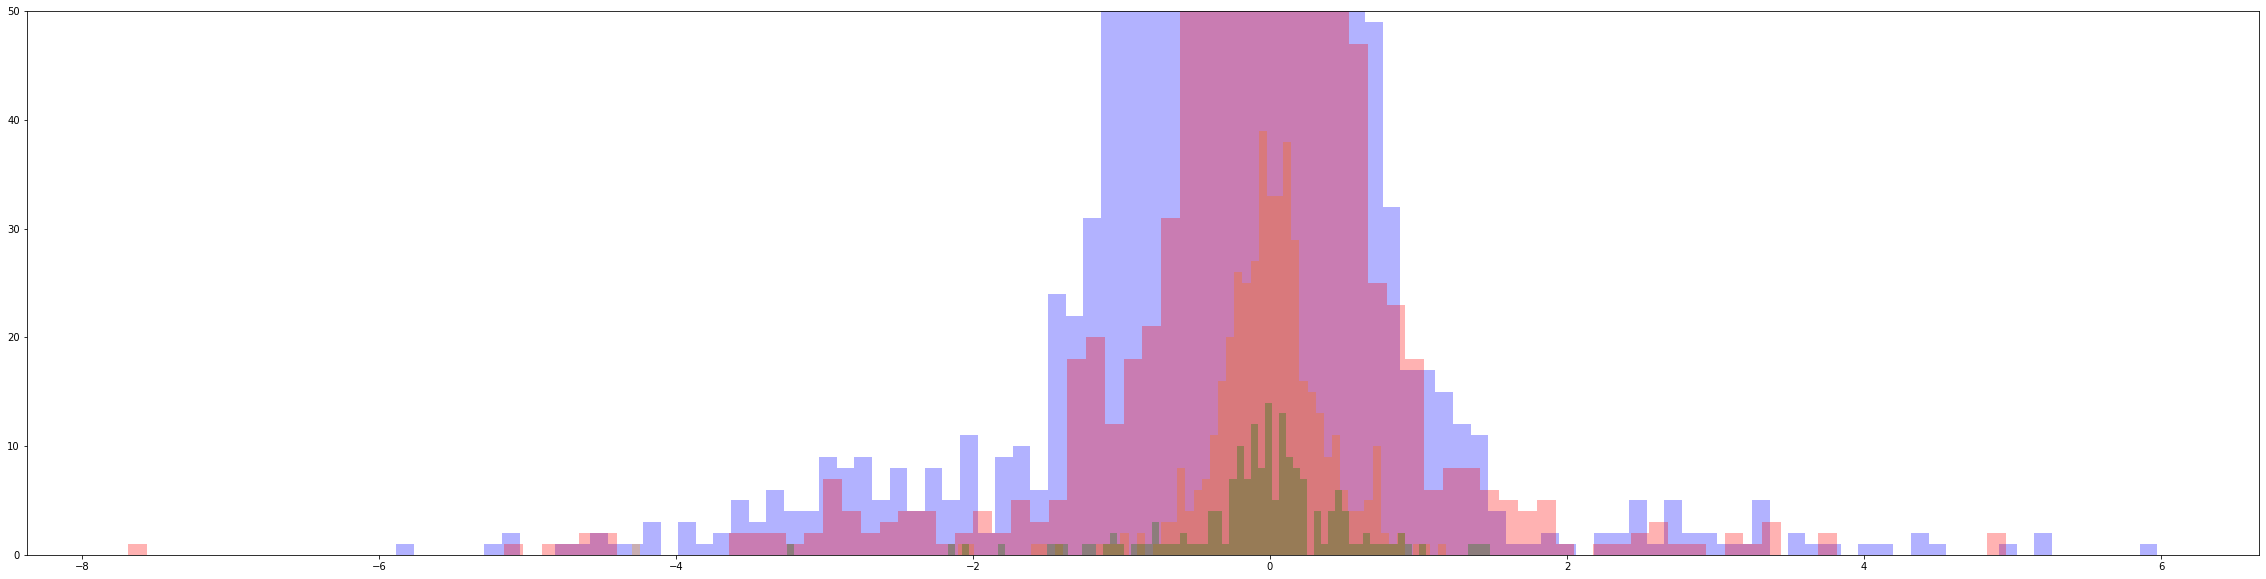

In [77]:
df_chg_heartrate_skew_class0 = skew(df_chg_heartrate_class0, axis=1, nan_policy="omit")
df_chg_heartrate_skew_class1 = skew(df_chg_heartrate_class1, axis=1, nan_policy="omit")
df_chg_heartrate_skew_class2 = skew(df_chg_heartrate_class2, axis=1, nan_policy="omit")
df_chg_heartrate_skew_class3 = skew(df_chg_heartrate_class3, axis=1, nan_policy="omit")

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_chg_heartrate_skew_class0, **kwargs, color="b", label="class0")
plt.hist(df_chg_heartrate_skew_class1, **kwargs, color="orange", label="class1")
plt.hist(df_chg_heartrate_skew_class2, **kwargs, color="r", label="class2")
plt.hist(df_chg_heartrate_skew_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

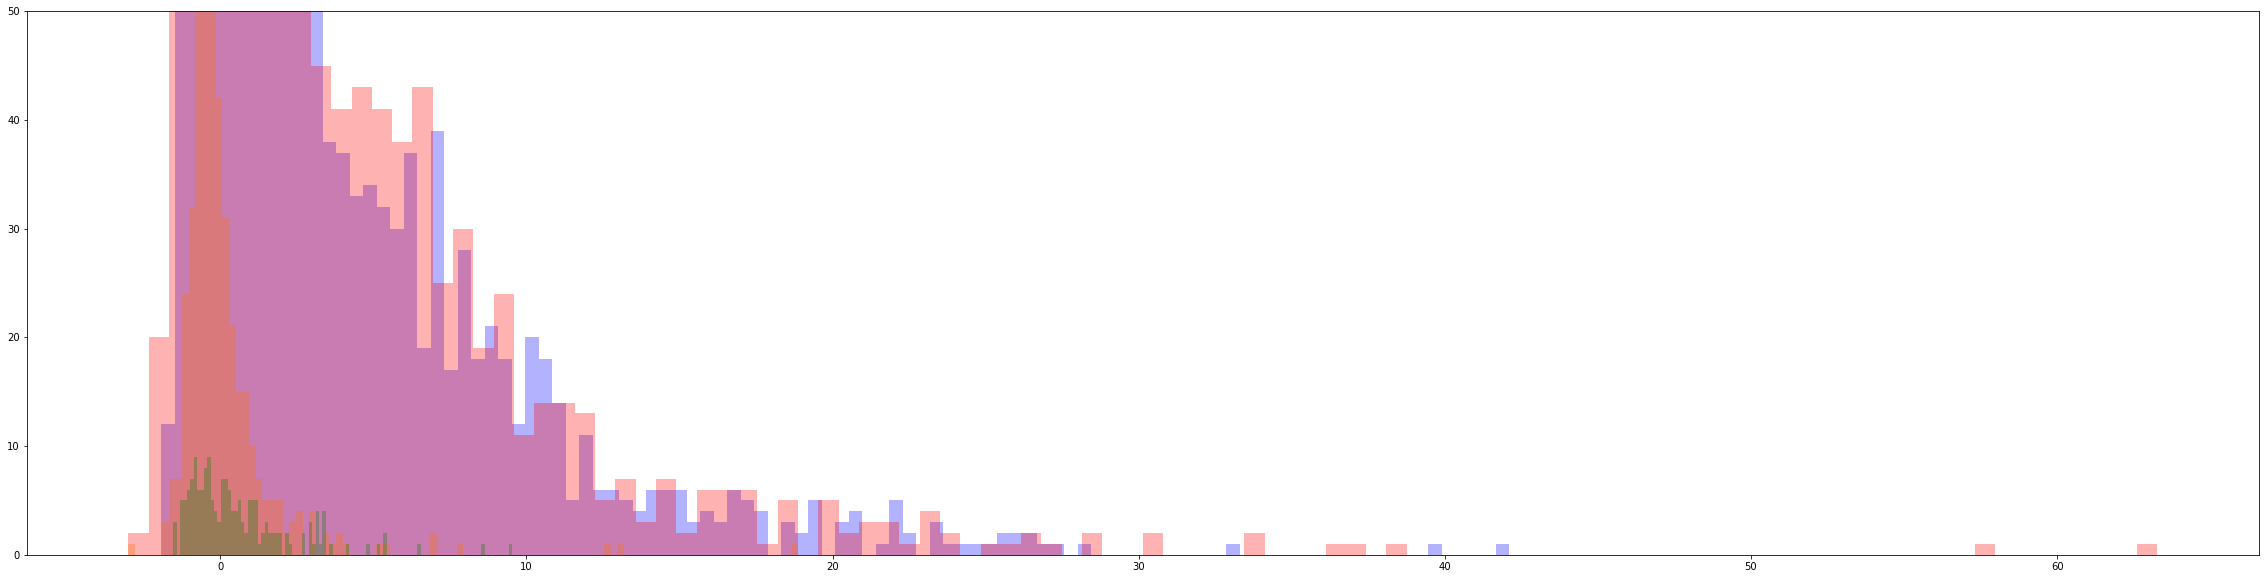

In [149]:
df_chg_heartrate_kurtosis_class0 = pd.Series(kurtosis(df_chg_heartrate_class0, axis=1, nan_policy="omit"))
df_chg_heartrate_kurtosis_class1 = pd.Series(kurtosis(df_chg_heartrate_class1, axis=1, nan_policy="omit"))
df_chg_heartrate_kurtosis_class2 = pd.Series(kurtosis(df_chg_heartrate_class2, axis=1, nan_policy="omit"))
df_chg_heartrate_kurtosis_class3 = pd.Series(kurtosis(df_chg_heartrate_class3, axis=1, nan_policy="omit"))

plt.figure(figsize=(40,10))
kwargs = dict(alpha=0.3, bins=100)
plt.hist(df_chg_heartrate_kurtosis_class0, **kwargs, color="b", label="class0")
plt.hist(df_chg_heartrate_kurtosis_class1, **kwargs, color="orange", label="class1")
plt.hist(df_chg_heartrate_kurtosis_class2, **kwargs, color="r", label="class2")
plt.hist(df_chg_heartrate_kurtosis_class3, **kwargs, color="green", label="class3")
plt.ylim(0, 50)
plt.show()

# Combine all features

In [199]:
def extract_all_features(df_ecg, feature_extractor_ecg_list, df_signal=None, feature_extractor_signal_list=None):
    out = pd.DataFrame()
    for feature_extractor in feature_extractor_ecg_list:
        out = pd.concat([out, feature_extractor(df_ecg)], axis=1)
    if feature_extractor_signal_list is not None:
        for feature_extractor in feature_extractor_signal_list:
            out = pd.concat([out, feature_extractor(df_signal)], axis=1)        
    return out

# Feature Extractor

In [121]:
def extract_heartbeat_mean(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        templates_mean = templates.mean(axis=0)

        result = pd.Series(templates_mean)
        results = results.append(result, ignore_index=True)

    return results

def extract_heartbeat_median(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        templates_median = np.median(templates,axis=0)

        result = pd.Series(templates_median)
        results = results.append(result, ignore_index=True)

    return results

def extract_heartbeat_std(df_ecg, scale=None):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        template_mean = templates.mean(axis=0)
        template_std = templates.std(axis=0)
        
        if scale == "minmax":
            template_std = template_std/(max(template_mean) - min(template_mean))

        result = pd.Series(template_std)
        results = results.append(result, ignore_index=True)

    return results

def extract_heartbeat_skew(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        templates_skew = skew(templates,axis=1)

        result = pd.Series(templates_skew)
        results = results.append(result, ignore_index=True)

    return results

def extract_heartbeat_skew_abs(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        templates_skew = skew(templates,axis=1)
        
        templates_skew = np.abs(templates_skew)

        result = pd.Series(templates_skew)
        results = results.append(result, ignore_index=True)

    return results

def extract_heartbeat_kurtosis(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        templates_kurtosis = kurtosis(templates,axis=1)

        result = pd.Series(templates_kurtosis)
        results = results.append(result, ignore_index=True)

    return results

def extract_heartbeat_mean_median_diff_abs(df_ecg, scale=None):
    
    results = pd.DataFrame()
    
    for i in range(0, len(df_ecg)):
        
        templates = df_ecg[i].templates

        template_mean = templates.mean(axis=0)
        template_median = np.median(templates, axis=0)
        
        template_mean_median_diff = template_mean - template_median
        
        if scale == "minmax":
            template_mean_median_diff = template_mean_median_diff/(max(template_mean) - min(template_mean))
            
        template_mean_median_diff_abs = [abs(val) for val in template_mean_median_diff]

        result = pd.Series(template_mean_median_diff_abs)
        results = results.append(result, ignore_index=True)
        
    return results

In [153]:
def extract_heartrate(df_ecg):
    
    results = pd.DataFrame()
    
    for i in range(len(df_ecg)):
        
        heartrate = pd.Series(df_ecg[i].heart_rate)
        results = results.append(heartrate, ignore_index=True)
        
    return results

In [166]:
def extract_mean(df, feature_name, axis=1):
    result = df.mean(axis=axis)
    result = pd.DataFrame(result, columns=[feature_name+"_mean"])
    return result

def extract_median(df, feature_name, axis=1):
    result = df.median(axis=axis)
    result = pd.DataFrame(result, columns=[feature_name+"_median"])
    return result

def extract_skew(df, feature_name, axis=1):
    result = pd.Series(skew(df, axis=axis, nan_policy="omit"))
    result = pd.DataFrame(result, columns=[feature_name+"_skew"])
    return result

def extract_kurtosis(df, feature_name, axis=1):
    result = pd.Series(kurtosis(df, axis=axis, nan_policy="omit"))
    result = pd.DataFrame(result, columns=[feature_name+"_kurtosis"])
    return result

def extract_quantile(df, feature_name, quantile=0.9, axis=1):
    result = df.quantile(q=quantile, axis=axis)
    result = pd.DataFrame(result, columns=[f"{feature_name}_quantile{quantile}"])
    return result

def extract_statistics(df, feature_name, axis=1):
    mean     = extract_mean(df, feature_name, axis=axis)
    median   = extract_median(df, feature_name, axis=axis)
    skew     = extract_skew(df, feature_name, axis=axis)
    kurtosis = extract_kurtosis(df, feature_name, axis=axis)
    
    result = pd.concat([mean, median, skew, kurtosis], axis=1)
    return result

In [154]:
def extract_heartbeat_std_statistic(df_ecg, feature_name):
    temp = extract_heartbeat_std(df_ecg)
    return extract_statistics(temp, feature_name)
#def extract_heartbeat_std_mean(df_ecg, feature_name):
#    temp = extract_heartbeat_std(df_ecg, feature_name)
#    return extract_mean(temp, "heartbeat_std_mean")
def extract_heartbeat_skew_abs_quantile(df_ecg, feature_name, lowerq=0.1, upperq=0.9):
    temp = extract_heartbeat_skew_abs(df_ecg)
    
    
def extract_heartbeat_skew_mean(df_ecg, feature_name):
    temp = extract_heartbeat_skew(df_ecg)
    return extract_mean(temp, "heartbeat_skew")

def extract_heartbeat_kurtosis_mean(df_ecg, feature_name):
    temp = extract_heartbeat_skew(df_ecg)
    return extract_mean(temp, "heartbeat_kurtosis")
def extract_heartbeat_kurtosis_median(df_ecg, feature_name):
    temp = extract_heartbeat_skew(df_ecg)
    return extract_median(temp, "heartbeat_kurtosis")

def extract_heartbeat_mean_median_diff_abs_mean(df_ecg, feature_name):
    temp = extract_heartbeat_mean_median_diff_abs(df_ecg)
    return extract_mean(temp, "heartbeat_mean_median_diff_abs")
def extract_heartbeat_mean_median_diff_abs_statistics(df_ecg, feature_name):
    temp = extract_heartbeat_mean_median_diff_abs(df_ecg)
    return extract_statistics(temp, "heartbeat_mean_median_diff_abs")

def extract_heartrate_statistic(df_ecg, feature_name):
    temp = extract_heartrate(df_ecg)
    return extract_statistics(temp, feature_name)

In [158]:
heartbeat_std_statistic = extract_heartbeat_std_statistic(df_ecg, feature_name="heartbeat_std")
heartbeat_std_mean = heartbeat_std_statistic["heartbeat_std_mean"]
heartbeat_std_skew = heartbeat_std_statistic["heartbeat_std_skew"]
heartbeat_std_kurtosis = heartbeat_std_statistic["heartbeat_std_kurtosis"]

In [124]:
heartbeat_kurtosis_median = extract_heartbeat_kurtosis_median(df_ecg, feature_name="heartbeat_kurtosis")
heartbeat_kurtosis_median

heartbeat_kurtosis_median
0                      2.945203
1                      0.972811
2                      3.178008
3                      3.311318
4                      3.058992
...                         ...
5112                   1.191403
5113                   3.149136
5114                  -2.787817
5115                   3.298838
5116                   2.693594

[5117 rows x 1 columns]

In [134]:
heartbeat_mean_median_diff_abs_statistics = extract_heartbeat_mean_median_diff_abs_statistics(df_ecg, feature_name="heartbeat_mean_median_diff_abs")
heartbeat_mean_median_diff_abs_statistics

heartbeat_mean_median_diff_abs_mean  \
0                                0.004174   
1                                0.002030   
2                                0.001019   
3                                0.007626   
4                                0.002806   
...                                   ...   
5112                             0.005121   
5113                             0.000894   
5114                             0.001959   
5115                             0.001084   
5116                             0.004239   

      heartbeat_mean_median_diff_abs_median  \
0                                  0.002242   
1                                  0.001643   
2                                  0.000739   
3                                  0.003688   
4                                  0.001771   
...                                     ...   
5112                               0.003917   
5113                               0.000698   
5114                               0.001177   
5115                               0.000888   
5116                               0.003168   

      heartbeat_mean_median_diff_abs_skew  \
0                                2.841538   
1                                1.509813   
2                                1.321727   
3                                2.931568   
4                                1.764840   
...                                   ...   
5112                             1.351585   
5113                             1.919820   
5114                             3.943431   
5115                             1.665564   
5116                             1.339764   

      heartbeat_mean_median_diff_abs_kurtosis  
0                                    8.373358  
1                                    2.365149  
2                                    1.258020  
3                                    9.803469  
4                                    3.186227  
...                                       ...  
5112                                 1.595390  
5113                                 5.411768  
5114                                17.285687  
5115                                 3.938182  
5116                                 2.131642  

[5117 rows x 4 columns]

In [155]:
heartrate_statistic = extract_heartrate_statistic(df_ecg, feature_name="heartrate")
heartrate_mean = heartrate_statistic["heartrate_mean"]

C:\Users\foong\Miniconda3\envs\machine-learning\lib\site-packages\numpy\lib\nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


heartrate_mean  heartrate_median  heartrate_skew  heartrate_kurtosis
0          80.423878         70.659447             NaN                 NaN
1          62.315326         61.370499             NaN                 NaN
2          84.979513         84.670976             NaN                 NaN
3          67.718020         68.206716             NaN                 NaN
4          57.997328         57.578310             NaN                 NaN
...              ...               ...             ...                 ...
5112       77.556893         72.171467             NaN                 NaN
5113      100.785838        101.125723             NaN                 NaN
5114       84.079317         83.989040             NaN                 NaN
5115       72.158708         71.907455             NaN                 NaN
5116       95.335056         81.210002             NaN                 NaN

[5117 rows x 4 columns]

In [135]:
X_train_features = pd.concat([heartbeat_std_statistic, heartbeat_kurtosis_median, heartbeat_mean_median_diff_abs_statistics, heartrate_statistic], axis=1)
X_train_features

heartbeat_std_mean  heartbeat_std_median  heartbeat_std_skew  \
0               0.020384              0.013560            2.561761   
1               0.020153              0.017723            2.110301   
2               0.011634              0.010316            2.599115   
3               0.018688              0.009833            2.625090   
4               0.010862              0.007777            1.995720   
...                  ...                   ...                 ...   
5112            0.030421              0.027930            1.332806   
5113            0.014685              0.011652            2.448107   
5114            0.015289              0.012165            3.073217   
5115            0.011948              0.010022            2.802907   
5116            0.038205              0.035564            0.490524   

      heartbeat_std_kurtosis  heartbeat_kurtosis_median  \
0                   7.500520                   2.945203   
1                   5.026681                   0.972811   
2                   7.125072                   3.178008   
3                   7.860759                   3.311318   
4                   3.923852                   3.058992   
...                      ...                        ...   
5112                1.612879                   1.191403   
5113                4.895080                   3.149136   
5114                9.175258                  -2.787817   
5115                7.668436                   3.298838   
5116               -0.827327                   2.693594   

      heartbeat_mean_median_diff_abs_mean  \
0                                0.004174   
1                                0.002030   
2                                0.001019   
3                                0.007626   
4                                0.002806   
...                                   ...   
5112                             0.005121   
5113                             0.000894   
5114                             0.001959   
5115                             0.001084   
5116                             0.004239   

      heartbeat_mean_median_diff_abs_median  \
0                                  0.002242   
1                                  0.001643   
2                                  0.000739   
3                                  0.003688   
4                                  0.001771   
...                                     ...   
5112                               0.003917   
5113                               0.000698   
5114                               0.001177   
5115                               0.000888   
5116                               0.003168   

      heartbeat_mean_median_diff_abs_skew  \
0                                2.841538   
1                                1.509813   
2                                1.321727   
3                                2.931568   
4                                1.764840   
...                                   ...   
5112                             1.351585   
5113                             1.919820   
5114                             3.943431   
5115                             1.665564   
5116                             1.339764   

      heartbeat_mean_median_diff_abs_kurtosis  
0                                    8.373358  
1                                    2.365149  
2                                    1.258020  
3                                    9.803469  
4                                    3.186227  
...                                       ...  
5112                                 1.595390  
5113                                 5.411768  
5114                                17.285687  
5115                                 3.938182  
5116                                 2.131642  

[5117 rows x 9 columns]

In [148]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train_features)
X_train_pca = pca.transform(X_train_features)
X_train_pca = pd.DataFrame(X_train_pca)

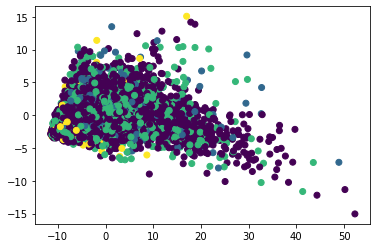

In [150]:
plt.scatter(X_train_pca.iloc[:, 0], X_train_pca.iloc[:, 1], c=y_train.values)
plt.show()

In [151]:
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train_features)
#mask = yhat != -1
#y_train[mask]
#X_train, y_train = X_train[mask, :], y_train[mask]

In [152]:
mask = yhat == -1
np.unique(y_train[mask], return_counts=True)

(array([0, 1, 2, 3], dtype=int64), array([327,  43, 134,   8], dtype=int64))

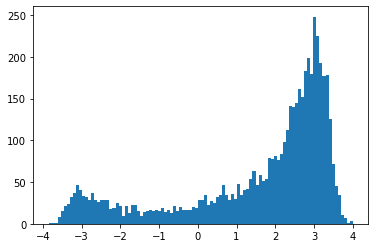

In [131]:
plt.hist(heartbeat_kurtosis_median.values, bins=100)
plt.show()

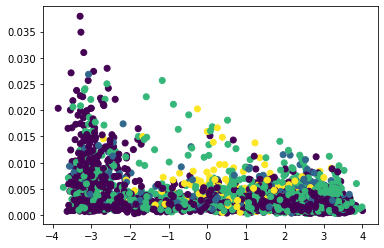

In [129]:
plt.scatter(heartbeat_kurtosis_median, heartbeat_mean_median_diff_abs_mean, c=y_train.values)
plt.show()